# Machine learning based estimates for trigger efficiency

In [2]:
import os, ROOT

ROOT.ROOT.EnableImplicitMT(1)

from ROOT import TEfficiency, TLegend, gPad, Math, VecOps
from ROOT.VecOps import Concatenate
from ROOT import TH1F, TH1D

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, log_loss
from sklearn.model_selection import RandomizedSearchCV, train_test_split, RepeatedKFold, GridSearchCV, cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import binned_statistic
from sklearn.metrics import mean_squared_error, roc_curve, auc, roc_auc_score 
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import keras_tuner as kt
#from scikeras.wrappers import KerasClassifier
import hist
from hist import Hist
import pickle
import mplhep as hep  # HEP (CMS) extensions/styling on top of mpl
#import cmsstyle as CMS
from array import array
#import unicodeit

#from skl2onnx import to_onnx

Welcome to JupyROOT 6.30/04


2024-09-15 10:23:56.908533: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-15 10:23:57.146885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Functions

In [3]:
# Functions for doing efficiency plots

def efficiency_plot(df1,df2,define,variable,label,name):
    """
    Plots the trigger efficiency as a function of the given variable and saves it as a file.
    
    Args:
        df1 (RDataframe): Dataframe containing the points that pass the trigger (numerator).
        df2 (RDataframe): Dataframe containing all the data points (denominator).
        define: A list containing the axis names, the number of bins and the ranges, e.g. ("FatJet_pt[0]",";Highest FatJet pt (GeV) ;Efficiency", range_min_pt, range_min_pt, range_max_pt)
        variable (string): The variable to use to plot the efficiency, e.g. "HighestPt" 
        label (string): Title for the plot.
        name (string): Name for the file to save the plot in.
        
    Returns:
        eff: The TEfficiency object.
    
    """
    
    h1 = df1.Histo1D(define,variable)
    h2 = df2.Histo1D(define,variable)
    
    h1_c = h1.Clone()
    h2_c = h2.Clone()
    c = ROOT.TCanvas("c", "", 700, 700)
    
    eff = TEfficiency(h1_c,h2_c)
    eff.Draw()
    eff.SetTitle(label)
    c.SaveAs(name)
    
    return eff

def efficiency_plot_same(eff1,eff2,h,xmin,xmax,xlabel,legend1,legend2,legend3,label,name):
    """
    Plots two or three efficiency plots on top of each other and saves it as a file.
    
    Args:
        eff1: The first efficiency object to plot (real efficiency).
        eff2: The second efficiency object to plot (measured efficiency).
        h: The histogram containing the trigger efficiency predicted by a ML algorithm.
        label (string): Title for the plot.
        name (string): Name for the file to save the plot in.
    
    """
    
    ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetTextFont(42)

    c = ROOT.TCanvas("c", "", 900, 700)
    #c.SetLeftMargin(0.14)
    c.SetBottomMargin(0.12)
    h.GetYaxis().SetTitle("Efficiency")
    h.GetXaxis().SetTitle(xlabel)
    h.GetXaxis().SetTitleSize(0.055)
    h.GetYaxis().SetTitleSize(0.055)
    h.GetXaxis().SetLabelSize(0.05)
    h.GetYaxis().SetLabelSize(0.05)
    h.GetYaxis().SetTitleOffset(0.9)
    h.GetXaxis().SetTitleOffset(0.98)
    h.GetXaxis().SetRangeUser(xmin,xmax)
    h.SetMarkerColor(ROOT.kBlue)
    eff1.SetLineColor(ROOT.kBlack)
    h.Draw("P*")
    eff1.Draw("same")
    if eff2 != None:
        eff2.SetLineColor(ROOT.kRed)
        eff2.Draw("same")
    legend = TLegend(0.52,0.15,0.88,0.4)  # 0.1,0.7,0.3,0.9
    le1=legend.AddEntry(eff1,legend1,"l")
    le3=legend.AddEntry(h,legend3,"l")
    if eff2 != None:
        le2=legend.AddEntry(eff2,legend2,"l")
        le2.SetTextSize(0.04)
    le1.SetTextSize(0.04)
    le3.SetTextSize(0.04)
    legend.SetBorderSize(0)
    legend.Draw()
    
    
    latex = ROOT.TLatex()
    latex.SetNDC()
    
    # Draw text inside the plot at specific coordinates
    latex.SetTextFont(42)  # Helvetica
    latex.SetTextSize(0.045)  # Base size
    if sample == "DATA":
        latex.DrawLatex(0.52, 0.47, "2018 data")
    else:
        latex.DrawLatex(0.52, 0.6, sample)
    
    # Draw text inside the plot at specific coordinates
    latex.SetTextFont(42)  # Helvetica
    latex.SetTextSize(0.045)  # Base size
    latex.DrawLatex(0.52,0.52,label)
    if sample == "DATA":
        latex.DrawLatex(0.52, 0.42, "Trained with 2018 data")
        latex.DrawLatex(0.66, 0.915, "59.8 fb^{-1}")
        
    else:
        latex.DrawLatex(0.5, 0.64, "Trained with QCD") 
    
    latex.SetTextFont(61)
    latex.SetTextSize(0.065)
    latex.DrawLatex(0.1, 0.915, "CMS")

    latex.SetTextFont(52)
    latex.SetTextSize(0.047)
    if sample == "DATA":
        latex.DrawLatex(0.21, 0.915, "Preliminary")
    else:
        latex.DrawLatex(0.21, 0.915, "Simulation Preliminary")

        
    latex.SetTextFont(42)
    latex.SetTextSize(0.047)
    latex.DrawLatex(0.78, 0.915, "(13 TeV)")
    
    c.SaveAs(name)
    
    return c


def efficiency_plot_stds(eff1,eff2,h1,h2,h3,h4,legend1,legend2,legend3,legend4,label,ymin,ymax,xmin,xmax,xlabel,name, sample):
    """
    Plots two or three efficiency plots with uncertainties on top of each other and saves it as a file.
    
    Args:
        eff1: The first efficiency object to plot (true efficiency).
        eff2: The second efficiency object to plot (measured efficiency).
        h1: The histogram containing the trigger efficiency predicted by a ML algorithm.
        h2: Upper limit uncertainties
        h3: Lower limit uncertainties
        h4: Another architecture uncertainties
        legend1,legend2,legend3,legend4: Legends for the histograms (true efficiency, measured, ML1, ML2)
        label (string): Title for the plot.
        ymin, ymax: Min and max ranges for y axis
        xmin, xmax: Min and max ranges for x axis
        name (string): Name for the file to save the plot in.
        
    Returns:
        c: The canvas object.
    
    """
    
    ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetTextFont(42)
    c = ROOT.TCanvas("c", "", 900, 700)
    h1.SetMarkerColor(ROOT.kBlue)
    h2.SetLineColor(ROOT.kViolet+1)
    h3.SetLineColor(ROOT.kBlue-7)
    h2.SetMarkerColor(ROOT.kViolet+1)
    h3.SetMarkerColor(ROOT.kBlue-7)
    eff1.SetTitle(label)
    eff1.SetLineColor(ROOT.kBlack)
    h1.GetYaxis().SetRangeUser(ymin,ymax)
    h1.GetYaxis().SetTitle("Efficiency")
    #if xlabel not in ["HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"]: 
     #   h1.GetXaxis().SetTitle(xlabel + " (GeV)")
    h1.GetXaxis().SetTitle(xlabel)
    h1.GetXaxis().SetRangeUser(xmin,xmax)
    #c.SetLeftMargin(0.14)
    c.SetBottomMargin(0.12)
    h1.GetXaxis().SetTitleSize(0.055)
    h1.GetYaxis().SetTitleSize(0.055)
    h1.GetXaxis().SetLabelSize(0.05)
    h1.GetYaxis().SetLabelSize(0.05)
    h1.GetYaxis().SetTitleOffset(0.9)
    h1.GetXaxis().SetTitleOffset(0.98)
    h1.Draw("P*")
    h2.Draw("C same")
    h3.Draw("C same")
    if eff2 != None:
        eff2.SetLineColor(ROOT.kRed)
        eff2.Draw("same")
    eff1.Draw("same")
    if h4 != None:
        h4.SetLineColor(ROOT.kGreen)
        h4.SetMarkerColor(ROOT.kGreen)
        h4.Draw("P* same")
    legend = TLegend(0.48,0.13,0.9,0.63)  # 0.1,0.7,0.3,0.9   0.65,0.1,0.9,0.4 x0, y0, x1, y1
    le1=legend.AddEntry(eff1,legend1,"l")
    le3=legend.AddEntry(h1,legend3,"l")
    le5=legend.AddEntry(h2,"GB means + STD","l")
    le6=legend.AddEntry(h3,"GB means - STD","l")
    if eff2 != None:
        le2=legend.AddEntry(eff2,legend2,"l")
        le2.SetTextSize(0.045)
    if h4 != None:
        le4=legend.AddEntry(h4,legend4,"l")
        le4.SetTextSize(0.045)
    le1.SetTextSize(0.045)
    le3.SetTextSize(0.045)
    le5.SetTextSize(0.045)
    le6.SetTextSize(0.045)
    legend.SetBorderSize(0)
    #legend.SetMargin(0.3)
    #legend.SetEntrySeparation(0.5)
    legend.Draw("same")
    
    
    # Redraw CMS text elements to ensure they are visible
    latex = ROOT.TLatex()
    latex.SetNDC()
    
    # Draw text inside the plot at specific coordinates
    latex.SetTextFont(42)  # Helvetica
    latex.SetTextSize(0.045)  # Base size
    if sample == "DATA":
        latex.DrawLatex(0.5, 0.69, "2018 data")
    else:
        latex.DrawLatex(0.5, 0.69, sample)
    
    # Draw text inside the plot at specific coordinates
    latex.SetTextFont(42)  # Helvetica
    latex.SetTextSize(0.045)  # Base size
    if sample == "DATA":
        latex.DrawLatex(0.5, 0.64, "Trained with 2018 data")
        latex.DrawLatex(0.66, 0.915, "59.8 fb^{-1}")
    else:
        latex.DrawLatex(0.5, 0.64, "Trained with QCD") 
    
    latex.SetTextFont(61)
    latex.SetTextSize(0.065)
    latex.DrawLatex(0.1, 0.915, "CMS")

    latex.SetTextFont(52)
    latex.SetTextSize(0.047)
    if sample == "DATA":
        latex.DrawLatex(0.21, 0.915, "Preliminary")
    else:
        latex.DrawLatex(0.21, 0.915, "Simulation Preliminary")
  
    latex.SetTextFont(42)
    latex.SetTextSize(0.047)
    latex.DrawLatex(0.78, 0.915, "(13 TeV)")
    
    c.SaveAs(name)
    
    return c
 
def mean_efficiency(X_test,y_prob,bin_edges,range_min,range_max):
    """
    Calculates the mean efficiency within specified bins and saves the result into a histogram.
    
    Args:
        X_test (array-like): The test portion from a machine learning algorithm.
        y_prob (array-like): The probability for every test data point to pass the trigger.
        num_bins (integer): The number of bins.
        range_min (integer): The starting point of the x-axis range.
        range_max (integer): The end point of the x-axis range.
        
    Returns:
        h_test (TH1F): A histogram containing the resulting mean efficiencies.
    
    """
    
    num_bins = len(bin_edges) - 1
    bin_width = (range_max - range_min) / num_bins
    bin_centers = [edge + bin_width / 2 for edge in bin_edges[:-1]]
    
    
    # If num_bins is a list and not an integer, use this. Otherwise uncomment commented lines
    bin_means, bin_edges, binnumber = binned_statistic(X_test,y_prob,statistic='mean', bins=bin_edges) #range=(range_min,range_max)
    print(bin_means)
    #bin_width = (range_max - range_min) / num_bins
    #bin_centers = bin_edges[:-1] + bin_width / 2
    
    #bin_std = binned_statistic(X_test, y_prob, statistic='std', bins=num_bins, range=(range_min, range_max))[0]
    #print("Bin centers:", bin_centers)
    #print("Bin means:", bin_means)

    plt.scatter(bin_centers, bin_means, c='blue', label='Mean Value')

    plt.xlabel('Range')
    plt.ylabel('Mean Value')
    plt.title('Mean values in bins')
    plt.show()

    bin_means = np.nan_to_num(bin_means)

    # If num_bins is not a list but an integer, use  h3 = TH1F("", "", num_bins, range_min, range_max)
    h3 = TH1F("", "", len(bin_edges) - 1, array('d', bin_edges))
    
    for i in range(1,num_bins+1):
        h3.SetBinContent(i,bin_means[i-1])
      
        
    h_test = h3.Clone()
    
    return h_test


def ratio_plot(ml_histo, eff_real, eff_meas, num_bins, range_min, range_max, sample, var_name):
    """
    Function for doing a ratio plot below a trigger efficinecy plot
    
    Args:
        ml_histo: Histogram containing the ML predicted efficiencies
        eff_real: TEfficiency object containing the "true" efficiencies from a simulation sample
        eff_meas: TEfficiency object containing the measured efficiencies
        num_bins: Number of bins used when plotting
        range_min, range_max: x axis ranges
        sample: The sample we use
        var_name: Name of the variable plotted
    
    """
    
    
    new_histogram = ml_histo.Clone()

    # Fill the new histogram with the efficiency values
    for i in range(1, num_bins + 1):
        numerator_value = eff_meas.GetEfficiency(i)
        denominator_value = eff_real.GetEfficiency(i)
        if denominator_value > 0:
            ratio = numerator_value / denominator_value
        else:
            ratio = 0.0
        new_histogram.SetBinContent(i, ratio)

    # Draw or save the new histogram
    canvas = ROOT.TCanvas("canvas", "Canvas", 700, 700)
    new_histogram.SetMarkerColor(1)
    new_histogram.SetMarkerStyle(8)
    new_histogram.SetMarkerSize(0.5)
    new_histogram.GetYaxis().SetRangeUser((0.0),(2.5))
    new_histogram.GetYaxis().SetTitle("Ratio")
    new_histogram.GetXaxis().SetRangeUser(range_min,range_max)
    new_histogram.Draw("P")

    canvas.Update()
    
    new_histogram1 = ml_histo.Clone()
    # Fill the new histogram with the efficiency values
    for i in range(1, num_bins + 1):
        numerator_value = ml_histo.GetBinContent(i)
        denominator_value = eff_real.GetEfficiency(i)
        if denominator_value > 0:
            ratio = numerator_value / denominator_value
        else:
            ratio = 0.0
        new_histogram1.SetBinContent(i, ratio)


    ratio_max = new_histogram1.GetMaximum()
    
    # Initialize min_value to a large value
    ratio_min = float("inf")

    # Iterate through the histogram bins and find the minimum value
    for i in range(1, new_histogram1.GetNbinsX() + 1):
        bin_content = new_histogram1.GetBinContent(i)
        if bin_content > 0 and bin_content < ratio_min:
            ratio_min = bin_content

    # Draw or save the new histogram
    canvas = ROOT.TCanvas("canvas", "Canvas", 800, 700)
    new_histogram1.SetMarkerColor(6)
    new_histogram1.SetMarkerStyle(8)
    new_histogram1.SetMarkerSize(0.5)
    new_histogram1.GetYaxis().SetRangeUser((0.0),(2.5))
    new_histogram1.GetYaxis().SetTitle("Ratio")
    new_histogram1.GetYaxis().SetTitleSize(0.15)
    new_histogram1.GetXaxis().SetRangeUser(range_min,range_max)
    new_histogram1.Draw("P")
    #canvas.SaveAs("testi2.png")
        
    
    c1 = ROOT.TCanvas("c1", "", 800, 800)

    pad_top1 = ROOT.TPad("pad_top", "Top Pad", 0.02, 0.2, 0.99, 0.99)
    pad_bottom1 = ROOT.TPad("pad_bottom", "Bottom Pad", 0.02, 0.01, 0.99, 0.2)

    pad_top1.Draw()
    pad_bottom1.Draw()

    # Adjust the position and size of the pads
    pad_top1.SetPad(0.01, 0.3, 0.99, 0.99)   # Adjust the second parameter (y1) to move the top pad upwards
    pad_bottom1.SetPad(0.01, 0.1, 0.99, 0.3)  # Adjust the fourth parameter (y2) to move the bottom pad upwards


    # Update the pads to reflect the changes
    c1.Update()

    # Redraw histograms to ensure they fit in the new pad dimensions
    pad_top1.cd()
    ml_histo.SetMarkerColor(ROOT.kBlue)
    ml_histo.GetXaxis().SetRangeUser(range_min,range_max)
    ml_histo.GetYaxis().SetRangeUser(0.01,1.03)
    ml_histo.GetXaxis().SetTitle(var_name)
    ml_histo.GetYaxis().SetLabelSize(0.04)
    #ml_histo.GetYaxis().SetTitleSize(0.05)
    ml_histo.GetYaxis().SetTitle("Efficiency")
    #ml_histo.GetYaxis().SetTitleOffset(0.4)
    legend = TLegend(0.65,0.0,0.9,0.3)  # 0.7,0.7,0.9,0.9 x0, y0, x1, y1
    le1=legend.AddEntry(eff_meas,"Measured efficiency","l")
    le3=legend.AddEntry(ml_histo,"ML efficiency","l")
    if eff_real != None:
        le2=legend.AddEntry(eff_real,"Real efficiency","l")
        le2.SetTextSize(0.03)
    le1.SetTextSize(0.03)
    le3.SetTextSize(0.03)
    ml_histo.Draw("P*")
    eff_real.Draw("same")
    eff_meas.Draw("same")
    legend.Draw("same")

    pad_top1.SetBottomMargin (0)
    pad_bottom1.cd()
    pad_bottom1.SetTopMargin (0)
    pad_bottom1.SetBottomMargin (0.25)
    new_histogram1.SetMarkerColor(ROOT.kBlue)
    new_histogram1.SetMarkerStyle(8)
    new_histogram1.SetMarkerSize(0.5)
    new_histogram1.GetXaxis().SetTitleSize(0.12)
    new_histogram1.GetXaxis().SetTitle(var_name)
    new_histogram1.GetXaxis().SetLabelSize(0.12)
    new_histogram1.GetYaxis().SetLabelSize(0.12)
    new_histogram1.GetYaxis().SetTitleSize(0.12)
    new_histogram1.GetYaxis().SetTitle("Ratio")
    new_histogram1.GetYaxis().SetTitleOffset(0.3)
    new_histogram1.GetXaxis().SetRangeUser(range_min,range_max)
    new_histogram1.GetYaxis().SetRangeUser((0.55),(1.75))
    new_histogram1.GetYaxis().SetNdivisions(207)  # 207
    new_histogram1.Draw("P")
    line = ROOT.TLine(range_min, 1, range_max, 1)
    line.SetLineColor(ROOT.kBlack)
    line.SetLineStyle(2)
    line.Draw("same")
    new_histogram.SetMarkerColor(2)
    new_histogram.SetMarkerStyle(8)
    new_histogram.SetMarkerSize(0.5)
    new_histogram.GetXaxis().SetRangeUser(range_min,range_max)
    new_histogram.Draw("P same")

    new_histogram1.GetYaxis().SetTitleSize(0.15)
    new_histogram.GetYaxis().SetTitleSize(0.15)
    c1.Update()
    c1.SaveAs(sample+var_name+"_with_ratio_"+run_name+".png") 
    

    
    
def efficiency_plot_DATA(df, df_name, signal_trigger, reference_trigger, variable,var_name_plot, var_name, label, range_min, range_max, num_bins, y_min,y_max, file_name):
    
    """
    Creates efficiency plots for data based on user-defined signal and reference triggers.
    """

    df_measured_pass = df.Filter(signal_trigger + " && " + reference_trigger, "")

    df_measured_all = df.Filter(reference_trigger, "")

    eff_measured = efficiency_plot(df_measured_pass,df_measured_all,variable,var_name,"","")
    
    ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetTextFont(42)
    c = ROOT.TCanvas(" ", "", 900, 700)
    c.SetBottomMargin(0.12)
    eff_measured.SetLineColor(ROOT.kBlack)
    eff_measured.SetMarkerColor(ROOT.kBlack)
    eff_measured.SetMarkerStyle(ROOT.kDot)
    # Draw an empty histogram to set up the frame
    h_empty = ROOT.TH1F("h_empty", " ", len(num_bins) - 1, array('d', num_bins))
    h_empty.SetStats(0)  
    h_empty.GetXaxis().SetTitle(var_name_plot)
    h_empty.GetYaxis().SetTitle("Efficiency")
    h_empty.GetXaxis().SetTitleSize(0.055)
    h_empty.GetYaxis().SetTitleSize(0.055)
    h_empty.GetXaxis().SetLabelSize(0.05)
    h_empty.GetYaxis().SetLabelSize(0.05)
    h_empty.GetYaxis().SetTitleOffset(0.9)
    h_empty.GetXaxis().SetTitleOffset(0.98)
    h_empty.Draw()
    eff_measured.Draw("same")
   
    # Redraw CMS text elements to ensure they are visible
    latex = ROOT.TLatex()
    latex.SetNDC()
    
    # Draw text inside the plot at specific coordinates
    latex.SetTextFont(42)  # Helvetica
    latex.SetTextSize(0.05)  # Base size
    latex.DrawLatex(0.6, 0.3, "HH 2018 data")
    
    # Draw text inside the plot at specific coordinates
    latex.SetTextFont(42)  # Helvetica
    latex.SetTextSize(0.045)  # Base size
    latex.DrawLatex(0.66, 0.915, "59.8 fb^{-1}")

    latex.SetTextFont(61)
    latex.SetTextSize(0.065)
    latex.DrawLatex(0.1, 0.915, "CMS")

    latex.SetTextFont(52)
    latex.SetTextSize(0.047)
    latex.DrawLatex(0.21, 0.915, "Preliminary")

    latex.SetTextFont(42)
    latex.SetTextSize(0.047)
    latex.DrawLatex(0.78, 0.915, "(13 TeV)")
    
    c.SaveAs(file_name)
    
    return eff_measured


In [23]:
# Functions for histograms 
def draw_histogram(h,label,name):
    """
    Draws a histogram and saves it into a file.
    
    Args:
        h: A histogram object.
        label: Title for the plot.
        name: Filename 
        
    Returns:
        c: The canvas object that can be saved into a file.
    
    """

    # Produce plot
    ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetTextFont(42)
    c = ROOT.TCanvas("c", "", 800, 700)
    h.GetXaxis().SetTitleSize(0.04)
    h.GetYaxis().SetTitleSize(0.04)
    # Error bars can be drawn with Draw("E")
    h.Draw("E") 
    h.SetTitle(label)

    c.SaveAs(name)
    
    return c


def draw_histograms_same(h_list,color_list,yaxis_range,legend_list,xtitle,ytitle,name):
    """
    Draws user defined number of histograms into the same plot and saves it into a file.
    
    Args:
        h_list: Histogram list
        color_list: Colors for the histograms
        yaxis_range: Rnage for the y axis
        legend_list: List of the legends for the histograms
        xtitle: x axis name
        ytitle: y axis name
        name: The filename
        
    Returns:
        c: The canvas object.
    
    """
    
    
    # Produce plot
    ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetTextFont(42)
    c = ROOT.TCanvas("c", "", 900, 700)
    c.SetLeftMargin(0.15)
    c.SetBottomMargin(0.12)
    h_list[0].GetXaxis().SetTitleSize(0.055)
    h_list[0].GetYaxis().SetTitleSize(0.055)
    h_list[0].GetXaxis().SetLabelSize(0.05)
    h_list[0].GetYaxis().SetLabelSize(0.05)
    h_list[0].GetYaxis().SetTitleOffset(1.4)
    h_list[0].GetXaxis().SetTitleOffset(0.98)
    h_list[0].GetYaxis().SetRangeUser(0,yaxis_range)
    h_list[0].GetXaxis().SetTitle(xtitle)
    h_list[0].GetYaxis().SetTitle(ytitle)
    for i in range(len(h_list)):
        h_list[i].SetLineColor(color_list[i])
    h_list[0].Draw("E")
    for i in range(len(h_list)):
        h_list[i].Draw("E same")
    if xtitle == "#Delta#phi":
         legend = TLegend(0.35,0.44,0.75,0.86)
    else:
        legend = TLegend(0.48,0.44,0.9,0.86)  # 0.1,0.7,0.3,0.9
        
    for i in range(len(legend_list)):
        le=legend.AddEntry(h_list[i],legend_list[i],"l")
        legend.AddEntry(0, "", "")
        le.SetTextSize(0.04)
    legend.SetBorderSize(0)
    #legend.SetMargin(0.3)
    #legend.SetEntrySeparation(0.5)
    legend.Draw("same")
    
    # Redraw CMS text elements to ensure they are visible
    latex = ROOT.TLatex()
    latex.SetNDC()
    
    # Draw text inside the plot at specific coordinates
    
    latex.SetTextFont(61)
    latex.SetTextSize(0.065)
    latex.DrawLatex(0.15, 0.915, "CMS")

    latex.SetTextFont(52)
    latex.SetTextSize(0.047)
    if sample == "DATA":
        latex.DrawLatex(0.26, 0.915, "Preliminary")
    else:
        latex.DrawLatex(0.26, 0.915, "Simulation Preliminary")

        
    latex.SetTextFont(42)
    latex.SetTextSize(0.047)
    latex.DrawLatex(0.78, 0.915, "(13 TeV)")

    
    c.SaveAs(name)
    
    return c

# Function to draw 2D histograms
def draw_2D_histogram(h1,x_axis_label,y_axis_label,name):
    """
    Draws a 2D plot from a predefined histogram and saves it into a file.
    
    Args:
        h1: Histogram to be drawn.
        x_axis_label: Label for the x-axis.
        y_axis_label: Label for the y-axis.
        name: Filename.
    
    """
    
    ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetTextFont(42)
    c = ROOT.TCanvas("c", "", 800, 700)
    h1.GetXaxis().SetTitleSize(0.03)
    h1.GetYaxis().SetTitleSize(0.03)
    h1.Draw("COLZ")
    h1.GetYaxis().SetRangeUser(0,5000)
    h1.SetTitle(label)
    h1.GetXaxis().SetTitle(x_axis_label)
    h1.GetYaxis().SetTitle(y_axis_label)
    
    c.SaveAs(name)
    
    return c

def numerator_and_denominator(df, df_name, signal_trigger, variable, var_name, xtitle, yaxis_range):
    """
    Creates plots of events in the trigger efficiency numerator and denominator based on user-defined signal and reference triggers.
    
    Args
        df: RDataFrame to be used
        df_name (string): Name of the dataframe
        signal_trigger (string): Signal trigger we use
        variable: 
        var_name (string): Name of the variable to plot
        xtitle: X-axis title
        yaxis_range: Y-axis range
        
    Returns
        num_real, denom_real: The histogram objects for events in the numerator and denominator
    
    """
    
    if df == df_DATA:
        df_real_pass = df.Filter(filter_pass_meas, "")
    
        num_real = df_real_pass.Histo1D(variable,var_name)
        
        num_real = num_real.GetValue()
        
        df_real_all = df.Filter(filter_all_meas, "")
    
        denom_real = df_real_all.Histo1D(variable,var_name)
        
        denom_real = denom_real.GetValue()
        
    else:
        df_real_pass = df.Filter(signal_trigger, "")
    
        num_real = df_real_pass.Histo1D(variable,var_name)
        
        # Get the TH1D histogram
        num_real = num_real.GetValue()
        
        denom_real = df.Histo1D(variable,var_name)
        
        denom_real = denom_real.GetValue()
    
    c2 = ROOT.TCanvas("c", "", 900, 700)
    c2.SetLeftMargin(0.15)
    c2.SetBottomMargin(0.12)
    denom_real.GetXaxis().SetTitleSize(0.055)
    denom_real.GetYaxis().SetTitleSize(0.055)
    denom_real.GetXaxis().SetLabelSize(0.05)
    denom_real.GetYaxis().SetLabelSize(0.05)
    denom_real.GetYaxis().SetTitleOffset(1.2)
    denom_real.GetXaxis().SetTitleOffset(0.98)
    #denom_real.SetTitle(label)
    num_real.SetLineColor(ROOT.kRed)
    #denom_real.GetYaxis().SetRangeUser(0,155000)
    denom_real.GetYaxis().SetTitle("Events")
    denom_c = denom_real.Clone()
    num_c = num_real.Clone()
    denom_real.GetXaxis().SetTitle(xtitle)
    denom_real.GetYaxis().SetRangeUser(0,yaxis_range)
    denom_real.Draw("E")
    num_real.Draw("E same")
    if xtitle == "#Delta#phi":
         legend1 = TLegend(0.35,0.44,0.75,0.86)
    else:
        legend1 = TLegend(0.45,0.6,0.89,0.89)
    
    if df == df_DATA:
        leg1=legend1.AddEntry(denom_c,"#splitline{Events passing the}{reference trigger}","l")
        leg2=legend1.AddEntry(num_c,"#splitline{Events passing the signal}{& reference trigger}","l")
    else:
        leg1=legend1.AddEntry(denom_c,"All events","l")
        leg2=legend1.AddEntry(num_c,"#splitline{Events passing the}{signal trigger}","l")
    leg1.SetTextSize(0.04)
    leg2.SetTextSize(0.04)
    legend1.SetBorderSize(0)
    legend1.Draw()    
    denom_real.SetStats(0)
    
    # Redraw CMS text elements to ensure they are visible
    latex = ROOT.TLatex()
    latex.SetNDC()
    
    # Draw text inside the plot at specific coordinates
    latex.SetTextFont(61)
    latex.SetTextSize(0.065)
    latex.DrawLatex(0.15, 0.915, "CMS")

    latex.SetTextFont(52)
    latex.SetTextSize(0.047)
    if df == df_DATA:
        latex.DrawLatex(0.26, 0.915, "Preliminary")
        latex.SetTextFont(42)  # Helvetica
        latex.SetTextSize(0.045)  # Base size
        latex.DrawLatex(0.66, 0.915, "59.8 fb^{-1}")
    else:
        latex.DrawLatex(0.26, 0.915, "Simulation Preliminary")
        
    latex.SetTextFont(42)
    latex.SetTextSize(0.047)
    latex.DrawLatex(0.78, 0.915, "(13 TeV)")
    
   # c2.Update()
    c2.SaveAs(df_name + "_" + var_name + "_" + run_name + "_both.png")
    
    return num_real, denom_real


In [38]:
# Functions for machine learning

def RD_to_pandas(df,trigger,columns,feature_names):
    """
    Creates a pandas dataframe out of RDataframe, takes only the events passing the reference trigger and returns the new dataframe and 
    a part of the dataframe containing only the feature columns.
    
    Args:
        df: RDataframe
        trigger: The reference trigger 
        columns: Columns from the original RDataframe we want to use in the new pandas dataframe
        feature_names: Names of the features as defined in the RDataframe
        
    Returns:
        pddf: The new pandas dataframe, where every event passes the reference trigger
        features: Pandas dataframe containing only the feature columns
    """

    # Filter the dataframe using the best reference trigger
    df_ref = df.Filter(trigger, "")

    # choose only the columns that are needed, since the datasets are so large that converting the whole dataframe will take a long time
    npy = df_ref.AsNumpy(columns=columns) 

    # rdf --> numpy 
    #npdf = df0.AsNumpy(columns)
    # numpy --> pandas
    pddf = pd.DataFrame(npy)

    features=pddf[feature_names]
    
    return pddf, features



def train_ML_model(pddf, trigger, feats, ml_model, test_size):
    """
    Trains a specific ML model (from scikit-learn).
    
    Args:
        trigger (string): The trigger that we want to analyze (used to define the labels for the ML model).
        feats (Pandas dataframe): Features for the ML model.
        ml_model (variable): The ML model we want to use.
        test_size (float): The size for the test sample.
        
    Returns:
        X_test: The feature test sample points.
        y_test: The label test sample points.
        y_prob: The probabilities for each data point to pass the signal trigger.
        
    
    """
    
    y = pddf[trigger].astype('bool')
    y = y*1
    y = y.astype(int).values
    
    X = feats.values 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    ml_model.fit(X_train, y_train)

    y_pred = ml_model.predict(X_test)

    y_prob = ml_model.predict_proba(X_test)[:,1]

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate the AUC
    print("AUC:",metrics.roc_auc_score(y_test,y_prob))

    # Line for random guesses
    x = (0.0,1.0)
    y = x
    
    # Plot the ROC curve and the line for random guesses
    false_positive, true_positive, _ = metrics.roc_curve(y_test,y_prob)
    plt.plot(false_positive, true_positive, label = "ROC curve")
    plt.legend()
    plt.plot(x,y,label="Line for random guesses")
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    return X_test, y_test, y_prob, ml_model, X_train, y_train



In [6]:
# Functions for dealing with two-dimensional plotting and slicing data

# Function to create an efficiency plot for a variable with data sliced with another variable (this function is used in efficiency_slices)
def two_var_comparison(df, var_slice, var_plot, b_limit, t_limit, num_bins, range_min, range_max):
    """
    Slices the data using limits for one variable, and then plots the mean efficiency of another variable from the data sliced by conditions given to the other 
    variable.
    
    Args:
        df (PandasDataFrame): Original dataframe.
        var_slice (string): Variable that is used to slice the data.
        var_plot (string): Variable to be plotted. 
        b_limit (integer): Bottom limit for the slice.
        t_limit (integer): Top limit for the slice.
        num_bins (integer): Number of the bins used in the plot.
        range_min (integer): The starting point of the x-axis range.
        range_max (integer): The end point of the x-axis range.
        
    Returns:
        h (TH1F): Histogram containing the mean efficiency plot.
    
    """
    
    ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetTextFont(42)
    c = ROOT.TCanvas("c", "", 900, 700)
    cond = df[var_slice].between(b_limit, t_limit)
    rslt_df = df[cond]
    
    
    h=mean_efficiency(rslt_df[var_plot].to_numpy(),rslt_df['Efficiency'].to_numpy(),num_bins,range_min,range_max)
    
    return h

# Function to create slices for plotting the mean efficiency of a variable as a function of another variable
def create_slices(slices_list, filter_pass1,filter_all1, filter_pass2, filter_all2):
    """
    Creates slices from a list of prenefined dataframes with conditions for the slices and adds the final slices into their own lists as well.
    
    Args:
        slice_list (list of RDataFrame objects): List of the dataframes filtered by the limits for the slices.
        filter_pass1 (string): Trigger used to filter the events passing the signal trigger.
        filter_pass2 (string): Trigger used to filter the events passing the reference and the signal trigger.
        filter_all2 (string): Trigger used to filter the events passing the reference trigger.
        
    Returns:
        list_pass (list): A list to add the dataframes containing the events which pass the signal trigger.
        list_meas_pass (list): A list to add the dataframes containing the events that pass both the signal and the reference trigger.  
        list_meas_all (list): A list to add the dataframes containing the events that pass the reference trigger.
        
    """
    
    list_pass = []
    list_all = []
    list_meas_pass=[]
    list_meas_all=[]
    
    if not filter_pass1: 
        for i in range(0, len(slices_list)):
            df_slice_meas_pass = slices_list[i].Filter(filter_pass2, "Events which pass the trigger")
            list_meas_pass.append(df_slice_meas_pass)

            df_slice_meas_all = slices_list[i].Filter(filter_all2, "All events")
            list_meas_all.append(df_slice_meas_all)
        
        return list_meas_pass, list_meas_all
    
    else:
        for i in range(0, len(slices_list)):
            df_slice_pass = slices_list[i].Filter(filter_pass1, "Events which pass the trigger")
            list_pass.append(df_slice_pass)

            df_slice_all = slices_list[i].Filter(filter_all1, "All events")
            list_all.append(df_slice_all)
        
            df_slice_meas_pass = slices_list[i].Filter(filter_pass2, "Events which pass the trigger")
            list_meas_pass.append(df_slice_meas_pass)

            df_slice_meas_all = slices_list[i].Filter(filter_all2, "All events")
            list_meas_all.append(df_slice_meas_all)
        
        return list_pass, list_all, list_meas_pass, list_meas_all
    

# Function to get the real, measured and ML efficiency plots of the slices 
def efficiency_slices(slice_test, plot_test, ml_eff, real_eff, meas_eff, var_slice, var_plot, 
                      slice_min, slice_max, num_bins, range_min, range_max, legend1, legend2, legend3,xlabel, label, file ):
    """
    Plots the real, measured and machine learning efficiencies on top of each other.
    
    Args:
        slice_test (array): The ML test values of the variable used to slice the data.
        plot_test (array): The ML test values of the variable that we want to plot.
        ml_eff (array): ML efficiencies (= probabilities for each event to pass the trigger).
        real_eff (histogram): A histogram containing the real efficiencies
        meas_eff: A histogram containing the measured efficiencies.
        var_slice: The variable that is used to slice the data. 
        var_plot: The variable that is used to plot the data.
        slice_min: The lower value for the slice range.
        slice_max: The higher value for the slice range.
        num_bins: The number of bins in the plot.
        range_min: The start point for the x-axis of the plot.
        range_max: The end point for the x-axis of the plot.
        label: Label for the plot.
        file: File name.
        
    
    """
    
    d = {var_slice : slice_test, var_plot : plot_test, 'Efficiency': ml_eff }

    df = pd.DataFrame(data=d)
    
    # Two_var_comparison used here
    h_2d = two_var_comparison(df, var_slice, var_plot, slice_min, slice_max, num_bins, range_min, range_max)
    

    if meas_eff != None:
        efficiency_plot_same(real_eff,meas_eff,h_2d,legend1,legend2,legend3,label,file)
    else:
        efficiency_plot_same(real_eff,None,h_2d,range_min,range_max,xlabel,legend1,legend2,legend3,label,file) 
    
     

In [7]:
# Functions to be used when choosing a reference trigger

def real_and_measured_efficiency_plots(df, df_name, signal_trigger, reference_trigger, variable,var_name_plot, var_name, label, range_min, range_max, num_bins, y_min,y_max, file_name):
    """
    Creates real and measured efficiency plots based on user-defined signal and reference triggers.
    """
    
    df_real_pass = df.Filter(signal_trigger, "")

    df_measured_pass = df.Filter(signal_trigger + " && " + reference_trigger, "")

    df_measured_all = df.Filter(reference_trigger, "")

    eff_real = efficiency_plot(df_real_pass,df,variable,var_name,"","")

    eff_measured = efficiency_plot(df_measured_pass,df_measured_all,variable,var_name,"","")
    
    ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetTextFont(42)
    c = ROOT.TCanvas(" ", "", 900, 700)
    c.SetBottomMargin(0.12)
    eff_measured.SetLineColor(ROOT.kRed)
    eff_measured.SetMarkerColor(ROOT.kRed)
    eff_measured.SetMarkerStyle(ROOT.kOpenCircle)
    eff_real.SetLineColor(ROOT.kBlack)
    eff_real.SetMarkerColor(ROOT.kBlack)
    eff_real.SetMarkerStyle(ROOT.kDot)
    # Draw an empty histogram to set up the frame
    h_empty = ROOT.TH1F("h_empty", " ", len(num_bins) - 1, array('d', num_bins))
    h_empty.SetStats(0)  # Hide the statistics box
    h_empty.GetXaxis().SetTitle(var_name_plot)
    h_empty.GetYaxis().SetTitle("Efficiency")
    h_empty.GetYaxis().SetRangeUser(y_min,y_max)
    h_empty.GetXaxis().SetTitleSize(0.055)
    h_empty.GetYaxis().SetTitleSize(0.055)
    h_empty.GetXaxis().SetLabelSize(0.05)
    h_empty.GetYaxis().SetLabelSize(0.05)
    h_empty.GetYaxis().SetTitleOffset(0.9)
    h_empty.GetXaxis().SetTitleOffset(0.98)
    h_empty.Draw()
    #eff_real.SetTitle(label)
    eff_measured.Draw("same")
    eff_real.Draw("same")
   # eff_measured.Draw("same")
    legend = TLegend(0.45,0.2,0.88,0.5)  # 0.1,0.7,0.3,0.9 x0, y0, x1, y1
    le1=legend.AddEntry(eff_real,"True efficiency","l")
    le2=legend.AddEntry(eff_measured,"Measured efficiency","l")
    le1.SetTextSize(0.05)
    le2.SetTextSize(0.05)
    legend.SetBorderSize(0)
    legend.Draw()
   
    # Redraw CMS text elements to ensure they are visible
    latex = ROOT.TLatex()
    latex.SetNDC()
    
    # Draw text inside the plot at specific coordinates
    latex.SetTextFont(42)  # Helvetica
    latex.SetTextSize(0.05)  # Base size
    if sample == "DATA":
        latex.DrawLatex(0.45, 0.65, "2018 data")
    else:
        latex.DrawLatex(0.46, 0.49, sample)

    
    latex.SetTextFont(61)
    latex.SetTextSize(0.065)
    latex.DrawLatex(0.1, 0.915, "CMS")

    latex.SetTextFont(52)
    latex.SetTextSize(0.047)
    if sample == "DATA":
        latex.DrawLatex(0.21, 0.915, "Preliminary")
    else:
        latex.DrawLatex(0.21, 0.915, "Simulation Preliminary")
  
    latex.SetTextFont(42)
    latex.SetTextSize(0.047)
    latex.DrawLatex(0.78, 0.915, "(13 TeV)")
    
    c.SaveAs(file_name)
    
    return eff_real, eff_measured

In [8]:
# Function for performing the mean and std deviation calculation for the gradient boosting predicted efficiencies

def mean_and_standard_deviation(models, X, y, num_bins_list, range_min_list, range_max_list):
    """
    Calculates the mean and standard deviation of the predictions made by the bootstrapped gradient boosting model
    
    Args:
        models (list): The models from the bootstrapping
        X (array): Features to be used as input for the model 
        y (array): Labels to be used in calculating the accuracies and AUC-ROC scores
        num_bins_list (list): List of the number of bins for each variable to plot
        range_min_list: List of the minimum x axis range for each variable to plot
        range_max_list: List of the maximum x axis range for each variable to plot
    
    Returns:
        mean_list: List of the histograms for each variable to plot containing the mean values from the predictions made by the bootstrapping ensemble 
        mean_plus_list: List of the histograms for each variable to plot containing the mean + std values from the predictions made by the bootstrapping ensemble  
        mean_minus_list: List of the histograms for each variable to plot containing the mean - std values from the predictions made by the bootstrapping ensemble 
    
    """
    
    # Calculate test accuracies and AUC scores for the ensemble having n models
    auc_scores = []
    test_accuracies = []

    for i in range(len(models)):
        test_predictions = models[i].predict(X)
        test_accuracy = accuracy_score(y, test_predictions)
        test_accuracies.append(test_accuracy)

        # Calculate AUC-ROC score for each model
        y_scores = models[i].predict_proba(X)[:, 1]  # Probability of positive class
        auc_score = roc_auc_score(y, y_scores)
        auc_scores.append(auc_score)

        print(f"Model {i + 1} - Test Accuracy: {test_accuracy:.4f} - AUC-ROC Score: {auc_score:.4f}")

    avg_test_accuracy = np.mean(test_accuracies)
    avg_auc_score = np.mean(auc_scores)
    print(f"\nAverage Test Accuracy across all models: {avg_test_accuracy:.4f}")
    print(f"Average AUC-ROC Score across all models: {avg_auc_score:.4f}")
    
    
    # Draw ROC curve for the ensemble
    plt.figure(figsize=(8, 6))

    # Calculate ROC curve for each model
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    for i in range(len(models)):
        y_scores = models[i].predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_scores)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    # Calculate mean and standard deviation of ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.plot(mean_fpr, mean_tpr, color='b', label=f'ROC (AUC = {avg_auc_score:.2f})', lw=2, alpha=0.8)

    # Plot the diagonal (random classifier)
    plt.plot([0, 1], [0, 1], color='darkorange', alpha=0.8, label = 'Line for random guesses') 

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #.title('ROC Curve for Ensemble of Models')
    plt.legend(loc='lower right')
    plt.show()

    
    # Calculate the means and standard deviations for each bin
    std_deviations = []
    mean_values = []
    pred_list = []

    for i in range(0,len(X)):
        # Create an empty list to store predictions from each classifier for each data point
        individual_predictions = []

        # Loop through each Gradient Boosting classifier
        for model in models:
            # Make predictions for the single data point using the current classifier
            predictions = model.predict_proba([X[i]])[:,1]
    
            individual_predictions.append(predictions)
        
        std_deviation = np.std(individual_predictions)
    
        mean = np.mean(individual_predictions)
    
        std_deviations.append(std_deviation)
    
        mean_values.append(mean)
    
        pred_list.append(individual_predictions)

    
    # Create lists to store the mean + STD and mean - STD values
    means_plus = []
    means_minus =[]

    for i in range(0,len(mean_values)):
        mean_plus_std = mean_values[i] + std_deviations[i]
        
        if mean_plus_std > 1.0:
            mean_plus_std = 1.0
    
        means_plus.append(mean_plus_std)
    
        mean_minus_std = mean_values[i] - std_deviations[i]
        
        if mean_minus_std < 0.0:
            mean_minus_std = 0.0
    
        means_minus.append(mean_minus_std)
    
    
    # Plot the means and STDs for all variables & add the histograms into lists    
    mean_list = []
    mean_plus_list = []
    mean_minus_list = []

    for i in range(0,len(num_bins_list)):    
        h_gb_means=mean_efficiency(X[:,i],mean_values, num_bins_list[i], range_min_list[i], range_max_list[i])

        h_gb_means_plus=mean_efficiency(X[:,i],means_plus, num_bins_list[i], range_min_list[i], range_max_list[i])

        h_gb_means_minus=mean_efficiency(X[:,i],means_minus, num_bins_list[i], range_min_list[i], range_max_list[i])
    
        mean_list.append(h_gb_means)
    
        mean_plus_list.append(h_gb_means_plus)
    
        mean_minus_list.append(h_gb_means_minus)
    
    return mean_list, mean_plus_list, mean_minus_list

### Parameters

In [72]:
run_name = "gradu"

# Define the sample we use
sample = "QCD" # QCD, ggF, VBF, DATA

# Ranges used for the plots of every variable in every sample
if sample == "QCD":
    range_min_pt = 250
    range_max_pt = 1100
    num_bins_pt = [250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,
                   520,540,560,580,600,620,640,660,680,700,750,800,850,900,1000,1100]

    range_min_pt1 = 170
    range_max_pt1 = 1000
    num_bins_pt1 = [170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,
                   520,540,560,580,600,620,640,660,680,700,750,800,850,900,1000]

    range_min_HT = 450
    range_max_HT = 2000
    num_bins_HT = [440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,820,840,860,880,900,920,
                   940,960,980,1000,1020,1040,1060,1080,1100,1120,1140,1160,1180,1200,1250,1300,1350,1400,1450,1500,1600,1700,1800,1900,2000]

    range_min_MET = 0
    range_max_MET = 500
    num_bins_MET = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,320,340,360,380,400,450,500]

    range_min_mHH = 400
    range_max_mHH = 4000
    num_bins_mHH = [400,450,500,550,600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500,1600,1700,1800,1900,2000,2200,2400,
                    2600,2800,3000,3500,4000]

    range_min_mass = 20
    range_max_mass = 300
    num_bins_mass = [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300]

    range_min_METfj = 400
    range_max_METfj = 2500
    num_bins_METfj = [400,450,500,550,600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500]

    range_min_eta = -3
    range_max_eta = 3
    num_bins_eta = [-3,-2,-1,0,1,2,3]

    range_min_delta = 0
    range_max_delta = 10
    num_bins_delta = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
    
    range_min_phi = -5
    range_max_phi = 5
    num_bins_phi = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
    
    y_min_list = [0,0,0,0,0,0,0,0,0,0,-0.3,-0.4,-0.6,-0.17]
    y_max_list =[1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05]

elif sample == "ggF":
    range_min_pt = 270
    range_max_pt = 1100
    num_bins_pt = [270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,
                   520,540,560,580,600,620,640,660,680,700,750,800,850,900,1000,1100]

    range_min_pt1 = 250
    range_max_pt1 = 900
    num_bins_pt1 = [200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,
                   520,540,560,580,600,620,640,660,680,700,750,800,850,900]

    range_min_HT = 450
    range_max_HT = 2000
    num_bins_HT = [440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,820,840,860,880,900,920,
                   940,960,980,1000,1020,1040,1060,1080,1100,1120,1140,1160,1180,1200,1250,1300,1350,1400,1450,1500,1600,1700,1800,1900,2000]

    range_min_MET = 0
    range_max_MET = 500
    num_bins_MET = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,320,340,360,380,400,450,500]

    range_min_mHH = 550
    range_max_mHH = 2400
    num_bins_mHH = [600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500,1600,1700,1800,1900,2000,2200,2400]

    range_min_mass = 30
    range_max_mass = 220
    num_bins_mass = [30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230]

    range_min_METfj = 600
    range_max_METfj = 2500
    num_bins_METfj = [600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500]

    range_min_eta = -3
    range_max_eta = 3
    num_bins_eta = [-3,-2,-1,0,1,2,3]

    range_min_delta = 0
    range_max_delta = 3
    num_bins_delta = [0,0.5,1,1.5,2,2.5,3]
    
    range_min_phi = -5
    range_max_phi = 8
    num_bins_phi = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
    
    y_min_list = [-0.1,0,0,0,-0.25,-0.1,-0.15,0,-0.1,0,-0.25,-0.95,-0.3,-0.7]
    y_max_list =[1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05]
    
elif sample == "VBF":
    range_min_pt = 270
    range_max_pt = 1100
    num_bins_pt = [270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,
                   520,540,560,580,600,620,640,660,680,700,750,800,850,900,1000,1100]

    range_min_pt1 = 250
    range_max_pt1 = 900
    num_bins_pt1 = [200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,
                   520,540,560,580,600,620,640,660,680,700,750,800,850,900]

    range_min_HT = 530
    range_max_HT = 2000
    num_bins_HT = [520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,820,840,860,880,900,920,
                   940,960,980,1000,1020,1040,1060,1080,1100,1120,1140,1160,1180,1200,1250,1300,1350,1400,1450,1500,1600,1700,1800,1900,2000]

    range_min_MET = 0
    range_max_MET = 500
    num_bins_MET = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,320,340,360,380,400,450,500]

    range_min_mHH = 600
    range_max_mHH = 3000
    num_bins_mHH = [550,600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500,1600,1700,1800,1900,2000,2200,2400,
                    2600,2800,3000]

    range_min_mass = 30
    range_max_mass = 300
    num_bins_mass = [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300]

    range_min_METfj = 550
    range_max_METfj = 2500
    num_bins_METfj = [500,550,600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500]

    range_min_eta = -3
    range_max_eta = 3
    num_bins_eta = [-3,-2,-1,0,1,2,3]

    range_min_delta = 0
    range_max_delta = 4.5
    num_bins_delta = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5]
    
    range_min_phi = -5
    range_max_phi = 5
    num_bins_phi = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
    
    y_min_list = [0,0,0.7,0.15,-0.25,0.4,0,0,0,0,0,0,-0.3,0]
    y_max_list =[1.05,1.05,1.02,1.05,1.05,1.02,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05]
    
elif sample == "DATA":
    range_min_pt = 250
    range_max_pt = 1100
    num_bins_pt = [250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,
                   520,540,560,580,600,620,640,660,680,700,750,800,850,900,1000,1100]

    range_min_pt1 = 160
    range_max_pt1 = 1000
    num_bins_pt1 = [200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,
                   520,540,560,580,600,620,640,660,680,700,750,800,850,900,1000]

    range_min_HT = 380
    range_max_HT = 2000
    num_bins_HT = [360,380,400,420,440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,820,840,860,880,900,920,
                   940,960,980,1000,1020,1040,1060,1080,1100,1120,1140,1160,1180,1200,1250,1300,1350,1400,1450,1500,1600,1700,1800,1900,2000]

    range_min_MET = 0
    range_max_MET = 500
    num_bins_MET = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,320,340,360,380,400,450,500]

    range_min_mHH = 400
    range_max_mHH = 4000
    num_bins_mHH = [400,450,500,550,600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500,1600,1700,1800,1900,2000,2200,2400,
                    2600,2800,3000,3500,4000]

    range_min_mass = 20
    range_max_mass = 300
    num_bins_mass = [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300]

    range_min_METfj = 400
    range_max_METfj = 2500
    num_bins_METfj = [500,550,600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500]

    range_min_eta = -3
    range_max_eta = 3
    num_bins_eta = [-3,-2,-1,0,1,2,3]

    range_min_delta = 0
    range_max_delta = 5
    num_bins_delta = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
    
    range_min_phi = -5
    range_max_phi = 5
    num_bins_phi = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
    
    y_min_list = [0,0,0,0,0,0,0,0,0,0,-0.5,-0.5,-0.6,-0.5]
    y_max_list =[1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,0.95,0.95,0.95,1.05]
    
elif sample == "dist":
    range_min_pt = 250
    range_max_pt = 1500
    num_bins_pt = [250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,
                   520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,
                   810,820,830,840,850,860,870,880,890,900,910,920,930,940,950,960,970,980,1000,1010,1020,1030,1040,1050,1060,1070,1080,1090,1100,1110,1120,1130,
                  1140,1150,1160,1170,1180,1190,1200,1210,1220,1230,1240,1250,1260,1270,1280,1290,1300,1310,1320,1330,1340,1350,1360,1370,1380,1390,1400] 
    # 1410,1420,1430,1440,1450,1460,1470,1480,1490,1500,1510,1520,1530,1540,1550,1560,1570,1580,1590,1600

    range_min_pt1 = 150
    range_max_pt1 = 900
    num_bins_pt1 = [150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,
                   520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,
                   810,820,830,840,850,860,870,880,890,900,910,920,930,940,950,960,970,980,1000,1010,1020,1030,1040,1050,1060,1070,1080,1090,1100]

    range_min_HT = 400
    range_max_HT = 2400
    num_bins_HT = [400,420,440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,820,840,860,880,900,920,
                   940,960,980,1000,1020,1040,1060,1080,1100,1120,1140,1160,1180,1200,1220,1240,1260,1280,1300,1320,1340,1360,1380,1400,
                   1420,1440,1460,1480,1500,1520,1540,1560,1580,1600,1620,1640,1660,1680,1700,1720,1740,1760,1780,1800,1820,1840,1860,1880,1900,
                   1920,1940,1960,1980,2000,2020,2040,2060,2080,2100,2120,2140,2160,2180,2200,2220,2240,2260,2280,2300,2320,2340,2360,2380,2400,2420,2440,2460,
                  2480,2500] # 2520,2540,2560,2580,2600,2620,2640,2660,2680,2700

    range_min_MET = 0
    range_max_MET = 500
    num_bins_MET = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,
                    360,370,380,390,400] # 410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,780,790,800

    range_min_mHH = 400
    range_max_mHH = 3500
    num_bins_mHH = [450,500,550,600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500,1550,1600,1650,1700,1750,
                    1800,1850,1900,1950,2000,2050,2100,2150,2200,2250,2300,2350,2400,2450,2500,2550,2600,2650,2700,2750,2800,2850,2900,2950,3000,3050,3100,3150,3200,
                   3250,3300,3350,3400,3450,3500]

    range_min_mass = 30
    range_max_mass = 350
    num_bins_mass = [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300] #,310,320,330,340,350

    range_min_METfj = 420
    range_max_METfj = 3000
    num_bins_METfj = [420,450,500,550,600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,
                      1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000,2050,2100,2150,2200,2250,2300,2350,2400,2450,2500,2550,2600,2650,2700,
                     2750,2800,2850,2900,2950,3000]

    range_min_eta = -3
    range_max_eta = 3
    num_bins_eta = [-3,-2,-1,0,1,2,3,4,5,6,7]

    range_min_delta = 0
    range_max_delta = 5
    num_bins_delta = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
    
    range_min_phi = -5
    range_max_phi = 5
    num_bins_phi = [-5,-4,-3,-2,-1,0,1,2,3,4,5]

    

range_min_list = [range_min_pt,range_min_HT,range_min_MET,range_min_mHH,range_min_mass,range_min_pt1,
                  range_min_mass,range_min_HT,range_min_METfj,range_min_mHH,range_min_eta,range_min_eta,range_min_delta,range_min_phi] 
range_max_list = [range_max_pt,range_max_HT,range_max_MET,range_max_mHH,range_max_mass,range_max_pt1,range_max_mass,range_max_HT,
                  range_max_METfj,range_max_mHH,range_max_eta,range_max_eta,range_max_delta,range_max_phi] 
num_bins_list = [num_bins_pt,num_bins_HT,num_bins_MET,num_bins_mHH,num_bins_mass,num_bins_pt1,num_bins_mass,num_bins_HT,
                 num_bins_METfj,num_bins_mHH,num_bins_eta,num_bins_eta,num_bins_delta,num_bins_phi]


# Default values used in histogram plotting
pt = ("FatJet_pt[0]","; p_{T0} [GeV] ;Efficiency", len(num_bins_pt) - 1, array('d', num_bins_pt))
HT = ("HT",";HT [GeV] ;Efficiency", len(num_bins_HT) - 1, array('d', num_bins_HT))
MET = ("MET","; p_{T}^{miss} [GeV] ;Efficiency", len(num_bins_MET) - 1, array('d', num_bins_MET))
mHH = ("mHH",";m_{HH} [GeV];Efficiency", len(num_bins_mHH) - 1, array('d', num_bins_mHH))
mass = ("Mass[0]",";m_{0} [GeV] ;Efficiency", len(num_bins_mass) - 1, array('d', num_bins_mass))
pt1 = ("FatJet_pt[1]",";p_{T1} [GeV] ;Efficiency",len(num_bins_pt1) - 1, array('d', num_bins_pt1))
mass1 = ("Mass[1]",";m_{1} [GeV] ;Efficiency", len(num_bins_mass) - 1, array('d', num_bins_mass))
FJHT = ("FatJet HT",";LR HT [GeV] ;Efficiency", len(num_bins_HT) - 1, array('d', num_bins_HT))
METfj = ("MET_FatJet",";p_{T}^{miss}+p_{T0}+p_{T1} [GeV] ;Efficiency", len(num_bins_METfj) - 1, array('d', num_bins_METfj))
mHHwMET = ("mHHwithMET",";m_{HH}+p_{T}^{miss} [GeV];Efficiency", len(num_bins_mHH) - 1, array('d', num_bins_mHH))
eta = ("Eta[0]","; η_{0} ;Efficiency", len(num_bins_eta) - 1, array('d', num_bins_eta))
eta1 = ("Eta[1]",";η_{1} ;Efficiency", len(num_bins_eta) - 1, array('d', num_bins_eta))
deltaeta = ("DeltaEta",";Δη ;Efficiency", len(num_bins_delta) - 1, array('d', num_bins_delta))
deltaphi = ("DeltaPhi",";Δφ ;Efficiency", len(num_bins_phi) - 1, array('d', num_bins_phi))

variable_list = [pt,HT,MET,mHH,mass,pt1,mass1,FJHT,METfj, mHHwMET,eta,eta1,deltaeta,deltaphi] 
names_list = ["HighestPt","HT","MET_pt","mHH","HighestMass","SecondHighestPt","SecondHighestMass","FatHT","MET_FatJet","mHHwithMET","HighestEta","SecondHighestEta","DeltaEta","DeltaPhi"] 

names_list_and_signal_trigger = ["HighestPt", "HT", "MET_pt", "mHH","HighestMass","SecondHighestPt", "SecondHighestMass", "FatHT", "MET_FatJet", "mHHwithMET", "HighestEta", "SecondHighestEta", 
                                 "DeltaEta", "DeltaPhi","Combo"]


names_list_plot = ["p_{T0} [GeV]","H_{T} [GeV]","p_{T}^{miss} [GeV]", "m_{HH} [GeV]","m_{0} [GeV]","p_{T1} [GeV]", "m_{1} [GeV]",
                   "H_{T}^{LR} [GeV]", "p_{T}^{miss}+p_{T0}+p_{T1} [GeV]","m_{HH}+p_{T}^{miss} [GeV]","#eta_{0}", "#eta_{1}", "#Delta#eta", "#Delta#phi"] # "mHH","FatJet_mass[0]","FatJet_pt[1]", "FatJet_mass[1]", "FatHT", "MET_FatJet","mHHwithMET","FatJet_eta[0]", "FatJet_eta[1]", "DeltaEta", "DeltaPhi"


In [51]:
signal_trigger = "Combo"
ref_trigger_list = ["HLT_AK8PFJet260"]

filter_pass_real = signal_trigger
filter_pass_meas = signal_trigger + "&& HLT_AK8PFJet260"
filter_all_meas = "HLT_AK8PFJet260"

all_columns = ["HighestPt", "HT", "MET_pt", "mHH","HighestMass","SecondHighestPt", "SecondHighestMass", "FatHT", "MET_FatJet", "mHHwithMET", "HighestEta", "SecondHighestEta", 
                "DeltaEta", "DeltaPhi","Combo","HLT_AK8PFJet260"]

# The procedure

Signal triggers (the final trigger condition is OR of all of these):
<br> HLT_AK8PFHT800_TrimMass50
<br> HLT_AK8PFJet400_TrimMass30 
<br> HLT_AK8PFJet500 
<br> HLT_PFJet500 
<br> HLT_PFHT1050 
<br> HLT_PFHT500_PFMET100_PFMHT100_IDTight
<br> HLT_PFHT700_PFMET85_PFMHT85_IDTight
<br> HLT_PFHT800_PFMET75_PFMHT75_IDTight

Possible reference triggers:
<br> HLT_IsoMu24 or HLT_Mu50
<br> HLT_Ele32_WPTight_Gsf or HLT_Ele115_CaloIdVT_GsfTrkIdT
<br> HLT_Photon200
<br> HLT_Ele32_WPTight_Gsf or HLT_Ele115_CaloIdVT_GsfTrkIdT or HLT_Photon200





NB! Suggest to do this gradually, e.g. 2D (FatJet[0],HT), then 3D (adding MET), then... 7D?

1) Make comparison plots of variables of interest for different samples

2) Choice of the reference trigger
<br> Compare simulated efficiencies and the "measured" efficiencies for the QCD, VBF, and ggF samples, with the different possible reference triggers
--> choose reference trigger that gives the best agreement across all variables of interest

3) "Closure test" for the MVA method with MC (use e.g. QCD MC samples)

3a) Measure trigger efficiency in MC using the best reference trigger

3b) Train MVA using part of the the MC sample, pretending that it's real data: use only events passing the reference trigger, and either passing or failing the signal trigger !!!

3c) Run the validation plots, using all MC samples:
<br>-1D and "2D"/binned-1D plots as a function of the variables of interest:
<br>   -trigger efficiency (using the average of MVA weights as the per-bin efficiency)
<br>   -distributions of events passing the trigger, MVA-weighted vs. directly selected
<br>-In these plots, overlay:
<br>   -MC-predicted efficiency = "real" efficiency
<br>   -prediction with measured efficiency (from 3a)
<br>   -MVA efficiency (from MC trained MVA)
<br>--> If the method works, all these are supposed to agree.

4) The real deal: use the MVA method to estimate the efficiency in DATA


4a) Measure trigger efficiency in DATA using the best reference trigger

4b) Train MVA using part of the the DATA sample: use events passing the reference trigger, and either passing or failing the signal trigger

4c) Run the validation plots, using both data and each MC sample separately (QCD, VBF, ggF):
<br>-1D and "2D"/binned-1D plots as a function of the variables of interest
<br>-trigger efficiency (using the average of MVA weights as the per-bin efficiency)
<br> -distributions of events passing the trigger, MVA-weighted vs. directly selected
<br>-In these plots, overlay:
<br>-(MC-predicted efficiency )
<br>-prediction with measured efficiency (from 4a)
<br>-MVA prediction
<br>--> The two latter should agree, while the "MC-only" prediction is NOT expected to agree anymore.

## Load the data

In [11]:
ROOT.gInterpreter.Declare("""
float mass_3(float pt1,
             float eta1,
             float phi1,
             float m1,
             float pt2,
             float eta2,
             float phi2,
             float m2,
             float pt3,
             float eta3,
             float phi3,
             float m3) {
  typedef ROOT::Math::LorentzVector<ROOT::Math::PtEtaPhiM4D<double>> PtEtaPhiMVector;
  PtEtaPhiMVector p41(pt1, eta1, phi1, m1);
  PtEtaPhiMVector p42(pt2, eta2, phi2, m2);
  PtEtaPhiMVector p43(pt3, eta3, phi3, m3);
  return (p41 + p42 + p43).M();
}
""")


True

In [12]:
df_QCD = ROOT.RDataFrame("NewQCD", "NewQCD.root")

In [16]:

# Originally the QCD sample was in several different files each with different HT ranges

# Loading the data into a dataframe
df_QCD1 = ROOT.RDataFrame("Events", "../../HHbbtautau/QCD_HT200to300_TuneCP5_13TeV-madgraphMLM-pythia8_tree.root")
df_QCD2 = ROOT.RDataFrame("Events", "../../HHbbtautau/QCD_HT300to500_TuneCP5_13TeV-madgraphMLM-pythia8_tree.root")
df_QCD3 = ROOT.RDataFrame("Events", "../../HHbbtautau/QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8_tree.root")
df_QCD4 = ROOT.RDataFrame("Events", "../../HHbbtautau/QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8_tree.root")
df_QCD5 = ROOT.RDataFrame("Events", "../../HHbbtautau/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_tree.root")
df_QCD6 = ROOT.RDataFrame("Events", "../../HHbbtautau/QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_tree.root")
df_QCD7 = ROOT.RDataFrame("Events", "../../HHbbtautau/QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_tree.root")

df_list=[df_QCD1,df_QCD2,df_QCD3,df_QCD4,df_QCD5,df_QCD6,df_QCD7]

df_QCD_list=[]

for df in df_list:
    df = df.Filter("nFatJet>=2")

    df = df.Define("HighestPt", "FatJet_pt[0]")
    df = df.Define("SecondHighestPt", "FatJet_pt[1]")
    df = df.Define("SelectedMass", "FatJet_mass[abs(FatJet_eta) < 2.4]")
    df = df.Define("HighestMass", "SelectedMass[0]")
    df = df.Define("SecondHighestMass", "SelectedMass[1]")
    df = df.Define("mHH", "InvariantMass(Take(FatJet_pt, 2),Take(FatJet_eta, 2),Take(FatJet_phi, 2),Take(FatJet_mass, 2))") 
    df = df.Define("SelectedJets_pt", "Jet_pt[Jet_pt > 30 && abs(Jet_eta) < 2.4]")
    df = df.Filter("SelectedJets_pt.size() >= 2")
    df = df.Define("HT", "Sum(SelectedJets_pt)")
    df = df.Define("SelectedFatJets_pt", "FatJet_pt[abs(FatJet_eta) < 2.4]")
    df = df.Filter("SelectedFatJets_pt.size() >= 2")
    df = df.Define("FatHT", "Sum(SelectedFatJets_pt)")
    df = df.Define("MET_FatJet", "(FatJet_pt[0]+FatJet_pt[1]+MET_pt)")
    df = df.Define("mHHwithMET","mass_3(FatJet_pt[0],FatJet_eta[0],FatJet_phi[0],FatJet_mass[0],FatJet_pt[1],FatJet_eta[1],FatJet_phi[1],FatJet_mass[1],MET_pt,0.0,MET_phi,0.0)")
    df = df.Define("Combo", "HLT_AK8PFHT800_TrimMass50 or HLT_AK8PFJet400_TrimMass30 or HLT_AK8PFJet500 or HLT_PFJet500 or HLT_PFHT1050 or HLT_PFHT500_PFMET100_PFMHT100_IDTight or HLT_PFHT700_PFMET85_PFMHT85_IDTight or HLT_PFHT800_PFMET75_PFMHT75_IDTight")
    df = df.Define("SelectedEta","FatJet_eta[abs(FatJet_eta) < 2.4]")
    df = df.Define("HighestEta", "SelectedEta[0]")
    df = df.Define("SecondHighestEta" , "SelectedEta[1]")
    df = df.Define("SelectedPhi","FatJet_phi[abs(FatJet_eta) < 2.4]")
    df = df.Define("DeltaPhi", "SelectedPhi[0]-SelectedPhi[1]")
    df = df.Define("DeltaEta", "abs(HighestEta-SecondHighestEta)")
    
    df_QCD_list.append(df)



In [16]:
df_ggF = ROOT.RDataFrame("Events", "../../HHbbtautau/GluGluToHHTo2B2Tau_node_cHHH1_TuneCP5_13TeV-powheg-pythia8_tree.root")
df_ggF = df_ggF.Filter("nFatJet>=2", "All events")

df_ggF = df_ggF.Define("HighestPt", "FatJet_pt[0]")
df_ggF = df_ggF.Define("SecondHighestPt", "FatJet_pt[1]")
df_ggF = df_ggF.Define("HighestMass", "FatJet_mass[0]")
df_ggF = df_ggF.Define("SecondHighestMass", "FatJet_mass[1]")
df_ggF = df_ggF.Define("mHH", "InvariantMass(Take(FatJet_pt, 2),Take(FatJet_eta, 2),Take(FatJet_phi, 2),Take(FatJet_mass, 2))") 
df_ggF = df_ggF.Define("SelectedJets_pt", "Jet_pt[Jet_pt > 30 && abs(Jet_eta) < 2.4]")
df_ggF = df_ggF.Filter("SelectedJets_pt.size() >= 2")
df_ggF = df_ggF.Define("HT", "Sum(SelectedJets_pt)")
df_ggF = df_ggF.Define("SelectedFatJets_pt", "FatJet_pt[abs(FatJet_eta) < 2.4]")
df_ggF = df_ggF.Filter("SelectedFatJets_pt.size() >= 2")
df_ggF = df_ggF.Define("FatHT", "Sum(SelectedFatJets_pt)")
df_ggF = df_ggF.Define("MET_FatJet", "(FatJet_pt[0]+FatJet_pt[1]+MET_pt)")
df_ggF = df_ggF.Define("mHHwithMET","mass_3(FatJet_pt[0],FatJet_eta[0],FatJet_phi[0],FatJet_mass[0],FatJet_pt[1],FatJet_eta[1],FatJet_phi[1],FatJet_mass[1],MET_pt,0.0,MET_phi,0.0)")
df_ggF = df_ggF.Define("Combo", "HLT_AK8PFHT800_TrimMass50 or HLT_AK8PFJet400_TrimMass30 or HLT_AK8PFJet500 or HLT_PFJet500 or HLT_PFHT1050 or HLT_PFHT500_PFMET100_PFMHT100_IDTight or HLT_PFHT700_PFMET85_PFMHT85_IDTight or HLT_PFHT800_PFMET75_PFMHT75_IDTight")
df_ggF = df_ggF.Define("SelectedEta","FatJet_eta[abs(FatJet_eta) < 2.4]")
df_ggF = df_ggF.Define("HighestEta", "SelectedEta[0]")
df_ggF = df_ggF.Define("SecondHighestEta" , "SelectedEta[1]")
df_ggF = df_ggF.Define("SelectedPhi","FatJet_phi[abs(FatJet_eta) < 2.4]")
df_ggF = df_ggF.Define("DeltaPhi", "SelectedPhi[0]-SelectedPhi[1]")
df_ggF = df_ggF.Define("DeltaEta", "abs(HighestEta-SecondHighestEta)")
df_ggF = df_ggF.Filter("(FatJet_particleNet_XbbVsQCD[0]  > 0.9 or FatJet_particleNet_XttVsQCD[0] > 0.9) and (FatJet_particleNet_XbbVsQCD[1] > 0.9 or FatJet_particleNet_XttVsQCD[1] >0.9)")

In [17]:
# Loading the data into a dataframe and defining necessary variables
df_VBF = ROOT.RDataFrame("Events", "../../HHbbtautau/VBF_HHTo2B2Tau_CV_1_C2V_0_C3_1_TuneCP5_13TeV-powheg-pythia8_tree.root")
df_VBF = df_VBF.Filter("nFatJet>=2", "All events")

df_VBF = df_VBF.Define("HighestPt", "FatJet_pt[0]")
df_VBF = df_VBF.Define("SecondHighestPt", "FatJet_pt[1]")
df_VBF = df_VBF.Define("HighestMass", "FatJet_mass[0]")
df_VBF = df_VBF.Define("SecondHighestMass", "FatJet_mass[1]")
df_VBF = df_VBF.Define("mHH", "InvariantMass(Take(FatJet_pt, 2),Take(FatJet_eta, 2),Take(FatJet_phi, 2),Take(FatJet_mass, 2))") 
df_VBF = df_VBF.Define("SelectedJets_pt", "Jet_pt[Jet_pt > 30 && abs(Jet_eta) < 2.4]")
df_VBF = df_VBF.Filter("SelectedJets_pt.size() >= 2")
df_VBF = df_VBF.Define("HT", "Sum(SelectedJets_pt)")
df_VBF = df_VBF.Define("SelectedFatJets_pt", "FatJet_pt[abs(FatJet_eta) < 2.4]")
df_VBF = df_VBF.Filter("SelectedFatJets_pt.size() >= 2")
df_VBF = df_VBF.Define("FatHT", "Sum(SelectedFatJets_pt)")
df_VBF = df_VBF.Define("MET_FatJet", "(FatJet_pt[0]+FatJet_pt[1]+MET_pt)")
df_VBF = df_VBF.Define("mHHwithMET","mass_3(FatJet_pt[0],FatJet_eta[0],FatJet_phi[0],FatJet_mass[0],FatJet_pt[1],FatJet_eta[1],FatJet_phi[1],FatJet_mass[1],MET_pt,0.0,MET_phi,0.0)")
df_VBF = df_VBF.Define("Combo", "HLT_AK8PFHT800_TrimMass50 or HLT_AK8PFJet400_TrimMass30 or HLT_AK8PFJet500 or HLT_PFJet500 or HLT_PFHT1050 or HLT_PFHT500_PFMET100_PFMHT100_IDTight or HLT_PFHT700_PFMET85_PFMHT85_IDTight or HLT_PFHT800_PFMET75_PFMHT75_IDTight")
df_VBF = df_VBF.Define("SelectedEta","FatJet_eta[abs(FatJet_eta) < 2.4]")
df_VBF = df_VBF.Define("HighestEta", "SelectedEta[0]")
df_VBF = df_VBF.Define("SecondHighestEta" , "SelectedEta[1]")
df_VBF = df_VBF.Define("SelectedPhi","FatJet_phi[abs(FatJet_eta) < 2.4]")
df_VBF = df_VBF.Define("DeltaPhi", "SelectedPhi[0]-SelectedPhi[1]")
df_VBF = df_VBF.Define("DeltaEta", "abs(HighestEta-SecondHighestEta)")
df_VBF = df_VBF.Filter("(FatJet_particleNet_XbbVsQCD[0]  > 0.9 or FatJet_particleNet_XttVsQCD[0] > 0.9) and (FatJet_particleNet_XbbVsQCD[1] > 0.9 or FatJet_particleNet_XttVsQCD[1] >0.9)")


In [20]:
# Download the data and define the new variables
df_DATA = ROOT.RDataFrame("Events", "../../HHbbtautau/JetHT_tree.root")
df_DATA = df_DATA.Filter("nFatJet>=2", "All events")

df_DATA = df_DATA.Define("HighestPt", "FatJet_pt[0]")
df_DATA = df_DATA.Define("SecondHighestPt", "FatJet_pt[1]")
df_DATA = df_DATA.Define("HighestMass", "FatJet_mass[0]")
df_DATA = df_DATA.Define("SecondHighestMass", "FatJet_mass[1]")
df_DATA = df_DATA.Define("mHH", "InvariantMass(Take(FatJet_pt, 2),Take(FatJet_eta, 2),Take(FatJet_phi, 2),Take(FatJet_mass, 2))") #*FatJet_particleNet_massCorr
df_DATA = df_DATA.Define("SelectedJets_pt", "Jet_pt[Jet_pt > 30 && abs(Jet_eta) < 2.4]")
df_DATA = df_DATA.Filter("SelectedJets_pt.size() >= 2")
df_DATA = df_DATA.Define("HT", "Sum(SelectedJets_pt)")
df_DATA = df_DATA.Define("SelectedFatJets_pt", "FatJet_pt[abs(FatJet_eta) < 2.4]")
df_DATA = df_DATA.Filter("SelectedFatJets_pt.size() >= 2")
df_DATA = df_DATA.Define("FatHT", "Sum(SelectedFatJets_pt)")
df_DATA = df_DATA.Define("MET_FatJet", "(FatJet_pt[0]+FatJet_pt[1]+MET_pt)")
df_DATA = df_DATA.Define("mHHwithMET","mass_3(FatJet_pt[0],FatJet_eta[0],FatJet_phi[0],FatJet_mass[0],FatJet_pt[1],FatJet_eta[1],FatJet_phi[1],FatJet_mass[1],MET_pt,0.0,MET_phi,0.0)")
df_DATA = df_DATA.Define("Combo", "(HLT_AK8PFHT800_TrimMass50 or HLT_AK8PFJet400_TrimMass30 or HLT_AK8PFJet500 or HLT_PFJet500 or HLT_PFHT1050 or HLT_PFHT500_PFMET100_PFMHT100_IDTight or HLT_PFHT700_PFMET85_PFMHT85_IDTight or HLT_PFHT800_PFMET75_PFMHT75_IDTight)")
df_DATA = df_DATA.Define("DeltaPhi", "(FatJet_phi[0]-FatJet_phi[1])")
df_DATA = df_DATA.Define("DeltaEta", "abs(FatJet_eta[0]-FatJet_eta[1])")
df_DATA = df_DATA.Define("HighestEta","FatJet_eta[0]")
df_DATA = df_DATA.Define("SecondHighestEta" , "FatJet_eta[1]")
df_DATA = df_DATA.Filter("HLT_AK8PFJet260")


In [19]:

df_ggF_filtered = df_ggF.Filter("HighestPt > 300")
df_ggF_filtered = df_ggF_filtered.Filter("SecondHighestPt > 250")
df_ggF_filtered = df_ggF_filtered.Filter("SecondHighestMass > 30")
df_ggF_filtered = df_ggF_filtered.Filter("HighestMass > 30")

df_VBF_filtered = df_VBF.Filter("HighestPt > 300")
df_VBF_filtered = df_VBF_filtered.Filter("SecondHighestPt > 250")
df_VBF_filtered = df_VBF_filtered.Filter("SecondHighestMass > 30")
df_VBF_filtered = df_VBF_filtered.Filter("HighestMass > 30")


In [70]:
# Sampling the new QCD file based on the HT distribution of data. We can either choose to take only events passing the reference trigger to the new QCD file, or
# also events which do not pass the reference trigger to illustrate the difference between "true efficiency" and "measured efficiency" when plotting the results

# If True, we choose only events passing the reference trigger
all_pass_ref_trigger=False

pddf_list=[]

if all_pass_ref_trigger==True:
    for df in df_QCD_list:
        pddf,_ = RD_to_pandas(df,filter_all_meas, all_columns, names_list)
        pddf_list.append(pddf)           
elif all_pass_ref_trigger==False:
    for df in df_QCD_list:
        pddf=pd.DataFrame(df.AsNumpy(all_columns))
        pddf_list.append(pddf)

result = pd.concat(pddf_list, axis=0, ignore_index=True)

# HT distribution of the data sample
hist = df_DATA.Histo1D(("HT","; HT (GeV);Events", 165, 450, 2100),"HT")
draw_histogram(hist,"","HT_DATA.png")

# Get values per interval 
values_per_interval = [hist.GetBinContent(hist.FindBin(interval)) for interval in np.arange(450, 2110, 10)]

# Select values for each interval for all columns
selected_values = pd.DataFrame()
for interval, num_values in zip(np.arange(450, 2110, 10), values_per_interval):
    subset = result.loc[(result['HT'] >= interval) & (result['HT'] < interval + 10)]
    selected_subset = pd.DataFrame()
    
    for column in result.columns:
        selected_subset[column] = subset[column].sample(int(num_values), random_state=42).values
    
    selected_values = pd.concat([selected_values, selected_subset])
    
# Convert the pandas array columns into cpp vectors so they can be converted into an RDataframe
numpy_array = selected_values.values
cpp_vector_list=[]
for i in range(0,len(all_columns)):
    cpp_vector = numpy_array[:,i].astype(dtype=np.float64)
    cpp_vector_list.append(cpp_vector)


df_QCD = ROOT.RDF.FromNumpy({"HighestPt": cpp_vector_list[0], "HT" : cpp_vector_list[1], "MET_pt" : cpp_vector_list[2], "mHH" : cpp_vector_list[3],
                             "HighestMass" : cpp_vector_list[4], "SecondHighestPt" : cpp_vector_list[5], "SecondHighestMass" : cpp_vector_list[6], 
                             "FatHT" : cpp_vector_list[7], "MET_FatJet" : cpp_vector_list[8], "mHHwithMET" : cpp_vector_list[9],
                             "HighestEta" : cpp_vector_list[10],"SecondHighestEta" : cpp_vector_list[11],  "DeltaEta" : cpp_vector_list[12], 
                             "DeltaPhi" : cpp_vector_list[13], "Combo" : cpp_vector_list[14], "HLT_AK8PFJet260" : cpp_vector_list[15]})

# Define the name of the output tree and the output file
#output_tree_name = "NewQCD"
#output_file_name = "NewQCD.root"
    
# Use the Snapshot method to save the dataframe to a ROOT file
#df_QCD.Snapshot(output_tree_name, output_file_name)

/tmp/ipykernel_456/949988560.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  result = pd.concat(pddf_list, axis=0, ignore_index=True)
Info in <TCanvas::Print>: png file HT_DATA.png has been created


## 1) Comparison plots

In [22]:
# Create lists for distributions of events passing the signal trigger and all events in the simulation samples

num_QCD_list = []
denom_QCD_list = []
num_ggF_list = []
denom_ggF_list = []
num_VBF_list = []
denom_VBF_list = []
all_nums_and_denoms = []

for j in range(len(range_min_list)):    
    num_QCD, denom_QCD = numerator_and_denominator(df_QCD, "QCD", signal_trigger, variable_list[j], names_list[j],names_list[j],1000)
    num_QCD_list.append(num_QCD)
    denom_QCD_list.append(denom_QCD)
    num_ggF, denom_ggF = numerator_and_denominator(df_ggF, "ggF", signal_trigger, variable_list[j], names_list[j],names_list[j],1000)
    num_ggF_list.append(num_ggF)
    denom_ggF_list.append(denom_ggF)
    num_VBF, denom_VBF = numerator_and_denominator(df_VBF, "VBF", signal_trigger, variable_list[j], names_list[j],names_list[j],1000)
    num_VBF_list.append(num_VBF)
    denom_VBF_list.append(denom_VBF)
    
    # Combine all nums and denoms for this iteration into a single list and append to all_nums_and_denoms
    combined_list = [num_QCD, denom_QCD, num_ggF, denom_ggF, num_VBF, denom_VBF]
    all_nums_and_denoms.append(combined_list)
    


Info in <TCanvas::Print>: png file QCD_HighestPt_gradu_both.png has been created
Info in <TCanvas::Print>: png file ggF_HighestPt_gradu_both.png has been created
Info in <TCanvas::Print>: png file VBF_HighestPt_gradu_both.png has been created
Info in <TCanvas::Print>: png file QCD_HT_gradu_both.png has been created
Info in <TCanvas::Print>: png file ggF_HT_gradu_both.png has been created
Info in <TCanvas::Print>: png file VBF_HT_gradu_both.png has been created
Info in <TCanvas::Print>: png file QCD_MET_pt_gradu_both.png has been created
Info in <TCanvas::Print>: png file ggF_MET_pt_gradu_both.png has been created
Info in <TCanvas::Print>: png file VBF_MET_pt_gradu_both.png has been created
Info in <TCanvas::Print>: png file QCD_mHH_gradu_both.png has been created
Info in <TCanvas::Print>: png file ggF_mHH_gradu_both.png has been created
Info in <TCanvas::Print>: png file VBF_mHH_gradu_both.png has been created
Info in <TCanvas::Print>: png file QCD_HighestMass_gradu_both.png has been c

In [32]:
# Distributions of all the simulation samples in the same plot

y_range_list = [1100,1200,2700,2500,10000,1300,5400,1200,2700,2300,20000,25000,17000,12000]

color_list = [ROOT.kViolet,ROOT.kAzure-5,ROOT.kRed+1,ROOT.kOrange+2,ROOT.kGray+3,ROOT.kGreen+2]

legend_list = ["#splitline{QCD events passing the}{signal trigger}","QCD all events","#splitline{ggF events passing the}{signal trigger}",
               "ggF all events","#splitline{VBF events passing the}{signal trigger}","VBF all events"]

for i in range(len(num_QCD_list)):
    draw_histograms_same(all_nums_and_denoms[i],color_list,y_range_list[i],legend_list,names_list_plot[i],"Events", "Distribution_MC_"+names_list[i]+".png")
    
    

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file Distribution_MC_HighestPt.png has been created
Info in <TCanvas::Print>: png file Distribution_MC_HT.png has been created
Info in <TCanvas::Print>: png file Distribution_MC_MET_pt.png has been created
Info in <TCanvas::Print>: png file Distribution_MC_mHH.png has been created
Info in <TCanvas::Print>: png file Distribution_MC_HighestMass.png has been created
Info in <TCanvas::Print>: png file Distribution_MC_SecondHighestPt.png has been created
Info in <TCanvas::Print>: png file Distribution_MC_SecondHighestMass.png has been created
Info in <TCanvas::Print>: png file Distribution_MC_FatHT.png has been created
Info in <TCanvas::Print>: png file Distribution_MC_MET_FatJet.png has been created
Info in <TCanvas::Print>: png file Distribution_MC_mHHwithMET.png has been created
Info in <TCanvas::Print>: png file Distribution_MC_HighestEta.png has been created
Info in <TCanvas::Print>: png 

In [203]:
# Distributions of event passing the reference trigger and signal and reference trigger for the data sample

y_range_list = [700,600,2300,1300,6000,800,4100,600,1600,1200,7000,7000,5000,9000]

num_DATA_list = []
denom_DATA_list = []
for j in range(len(range_min_list)):
    num_DATA, denom_DATA = numerator_and_denominator(df_DATA, "DATA", signal_trigger, variable_list[j], names_list[j], names_list_plot[j],y_range_list[j])
    num_DATA_list.append(num_DATA)
    denom_DATA_list.append(denom_DATA)

Info in <TCanvas::Print>: png file DATA_HighestPt_dist_both.png has been created
Info in <TCanvas::Print>: png file DATA_HT_dist_both.png has been created
Info in <TCanvas::Print>: png file DATA_MET_pt_dist_both.png has been created
Info in <TCanvas::Print>: png file DATA_mHH_dist_both.png has been created
Info in <TCanvas::Print>: png file DATA_HighestMass_dist_both.png has been created
Info in <TCanvas::Print>: png file DATA_SecondHighestPt_dist_both.png has been created
Info in <TCanvas::Print>: png file DATA_SecondHighestMass_dist_both.png has been created
Info in <TCanvas::Print>: png file DATA_FatHT_dist_both.png has been created
Info in <TCanvas::Print>: png file DATA_MET_FatJet_dist_both.png has been created
Info in <TCanvas::Print>: png file DATA_mHHwithMET_dist_both.png has been created
Info in <TCanvas::Print>: png file DATA_HighestEta_dist_both.png has been created
Info in <TCanvas::Print>: png file DATA_SecondHighestEta_dist_both.png has been created
Info in <TCanvas::Prin

## 2) Choice of the reference trigger

We will plot the "true" and measured trigger efficiencies for every variable of interest in the different simulated samples, using four possible reference trigger combinations to see which one is closest to the real efficiency.

In [73]:
# Create real and measured trigger efficiency plots for all the samples and all the possible reference triggers


if sample == "QCD":    
    eff_real_list_QCD = []
    eff_meas_list_QCD = []
    for j in range(0,len(variable_list)):
        eff_real_QCD, eff_measured_QCD = real_and_measured_efficiency_plots(df_QCD,sample,signal_trigger,ref_trigger_list[0],variable_list[j], names_list_plot[j], names_list[j],"", range_min_list[j],range_max_list[j],num_bins_list[j],y_min_list[j],y_max_list[j],
                                       sample+"_TEfficiency_"+names_list[j]+"_"+ref_trigger_list[0] +"_"+run_name+".png")
        eff_real_list_QCD.append(eff_real_QCD)
        eff_meas_list_QCD.append(eff_measured_QCD)
elif sample == "ggF":
    eff_real_list_ggF = []
    eff_meas_list_ggF = []
    for j in range(0,len(variable_list)):
        eff_real_ggF, eff_measured_ggF = real_and_measured_efficiency_plots(df_ggF,sample,signal_trigger,ref_trigger_list[0],variable_list[j], names_list_plot[j], names_list[j],"", range_min_list[j],range_max_list[j],num_bins_list[j],0,y_max_list[j],
                                       sample+"_TEfficiency_"+names_list[j]+"_"+ref_trigger_list[0] +"_"+run_name+".png")
        eff_real_list_ggF.append(eff_real_ggF)
        eff_meas_list_ggF.append(eff_measured_ggF)
elif sample == "VBF":
    eff_real_list_VBF = []
    eff_meas_list_VBF = []
    for j in range(0,len(variable_list)):
        eff_real_VBF, eff_measured_VBF = real_and_measured_efficiency_plots(df_VBF,sample,signal_trigger,ref_trigger_list[0],variable_list[j], names_list_plot[j], names_list[j],"", range_min_list[j],range_max_list[j],num_bins_list[j],y_min_list[j],y_max_list[j],
                                       sample+"_TEfficiency_"+names_list[j]+"_"+ref_trigger_list[0] +"_"+run_name+".png")
        eff_real_list_VBF.append(eff_real_VBF)
        eff_meas_list_VBF.append(eff_measured_VBF)

Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: png file QCD_TEfficiency_HighestPt_HLT_AK8PFJet260_gradu.png has been created
Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: png file QCD_TEfficiency_HT_HLT_AK8PFJet260_gradu.png has been created
Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: png file QCD_TEfficiency_MET_pt_HLT_AK8PFJet260_gradu.png has been created
Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: png file QCD_TEfficiency_mHH_HLT_AK8PFJet260_gradu.png has been created
Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: png file QCD_T

## 3) Closure test 

### Development stage

In [25]:
"""
# Initial model training stage

pddf,features= RD_to_pandas(df_QCD, filter_all_meas, ["HighestPt", "HT", "MET_pt", "mHH","HighestMass","SecondHighestPt", 
                                                           "SecondHighestMass", "FatHT", "MET_FatJet", "mHHwithMET", "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi","Combo"],
                             ["HighestPt", "HT","MET_pt", "mHH","HighestMass","SecondHighestPt", "SecondHighestMass", "FatHT", "MET_FatJet","mHHwithMET", "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"])

y = pddf["Combo"].astype('bool')
y = y*1
y = y.astype(int).values
    
X = features.values 

n_samples = 20

models = []
indices_x = []

for i in range(n_samples):
    index_x = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
    indices_x.append(index_x)
    X_sample = X[index_x, :]

    y_sample = y[index_x]
    
     # Split the data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X_sample, y_sample, test_size=0.2, random_state=1)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

    model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.25, max_depth=2, random_state=0).fit(X_train, y_train)
    models.append(model)

    y_pred = model.predict(X_test)
    
    # Monitor the model's performance on the validation set for early stopping
    val_predictions = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    print(f"Iteration {i + 1} - Validation Accuracy: {val_accuracy:.4f}")
    
# Evaluate the final model(s) on the test set
for i, model in enumerate(models):
    test_predictions = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    print(f"Model {i + 1} - Test Accuracy: {test_accuracy:.4f}")
    
"""

Iteration 1 - Validation Accuracy: 0.9080
Iteration 2 - Validation Accuracy: 0.9013
Iteration 3 - Validation Accuracy: 0.8935
Iteration 4 - Validation Accuracy: 0.9057
Iteration 5 - Validation Accuracy: 0.9046
Iteration 6 - Validation Accuracy: 0.9085
Iteration 7 - Validation Accuracy: 0.9069
Iteration 8 - Validation Accuracy: 0.8979
Iteration 9 - Validation Accuracy: 0.9102
Iteration 10 - Validation Accuracy: 0.9024
Iteration 11 - Validation Accuracy: 0.8946
Iteration 12 - Validation Accuracy: 0.9030
Iteration 13 - Validation Accuracy: 0.8963
Iteration 14 - Validation Accuracy: 0.9041
Iteration 15 - Validation Accuracy: 0.8985
Iteration 16 - Validation Accuracy: 0.9080
Iteration 17 - Validation Accuracy: 0.8879
Iteration 18 - Validation Accuracy: 0.8979
Iteration 19 - Validation Accuracy: 0.9074
Iteration 20 - Validation Accuracy: 0.8918
Model 1 - Test Accuracy: 0.8996
Model 2 - Test Accuracy: 0.8963
Model 3 - Test Accuracy: 0.9007
Model 4 - Test Accuracy: 0.8968
Model 5 - Test Accura

### Using the model

In [74]:
filename = 'gb_models_gradu_NEWEST.sav'
#pickle.dump(models, open(filename, 'wb'))
 
# load the model from disk
models = pickle.load(open(filename, 'rb'))

Model 1 - Test Accuracy: 0.9111 - AUC-ROC Score: 0.9604
Model 2 - Test Accuracy: 0.9100 - AUC-ROC Score: 0.9598
Model 3 - Test Accuracy: 0.9102 - AUC-ROC Score: 0.9593
Model 4 - Test Accuracy: 0.9091 - AUC-ROC Score: 0.9606
Model 5 - Test Accuracy: 0.9092 - AUC-ROC Score: 0.9579
Model 6 - Test Accuracy: 0.9112 - AUC-ROC Score: 0.9587
Model 7 - Test Accuracy: 0.9106 - AUC-ROC Score: 0.9602
Model 8 - Test Accuracy: 0.9114 - AUC-ROC Score: 0.9592
Model 9 - Test Accuracy: 0.9100 - AUC-ROC Score: 0.9594
Model 10 - Test Accuracy: 0.9102 - AUC-ROC Score: 0.9589
Model 11 - Test Accuracy: 0.9104 - AUC-ROC Score: 0.9597
Model 12 - Test Accuracy: 0.9096 - AUC-ROC Score: 0.9588
Model 13 - Test Accuracy: 0.9080 - AUC-ROC Score: 0.9593
Model 14 - Test Accuracy: 0.9106 - AUC-ROC Score: 0.9603
Model 15 - Test Accuracy: 0.9110 - AUC-ROC Score: 0.9596
Model 16 - Test Accuracy: 0.9097 - AUC-ROC Score: 0.9588
Model 17 - Test Accuracy: 0.9080 - AUC-ROC Score: 0.9588
Model 18 - Test Accuracy: 0.9104 - AUC-R

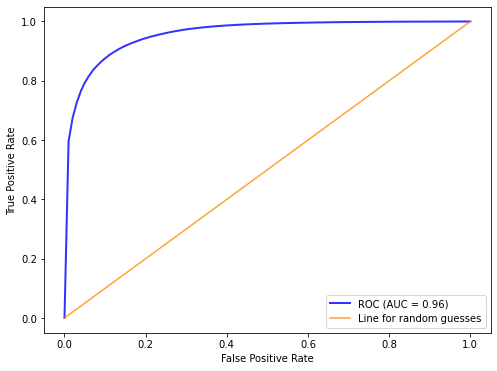

[0.06901981 0.17605403 0.09734983 0.11719654 0.0956333  0.11566208
 0.13065746 0.13723452 0.16323474 0.16783587 0.18632483 0.22359573
 0.22649386 0.31849663 0.41664797 0.47225073 0.61755102 0.72994271
 0.79435014 0.82653639 0.86034826 0.86552    0.89595721 0.90923882
 0.91615481 0.93252775 0.95981194 0.9758451  0.98108853 0.98747546
 0.99133664 0.99084505 0.99290182 0.99324906 0.995263   0.99541444
 0.99592253 0.99675178 0.99652339 0.99583787 0.99755897]


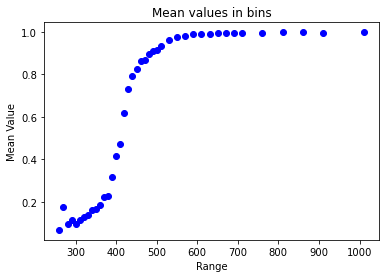

[0.12603305 0.32851268 0.1587265  0.16771124 0.13280355 0.16008856
 0.17464336 0.18542359 0.21315033 0.21914262 0.23727778 0.28367665
 0.28615572 0.39564636 0.50371919 0.56655273 0.71048219 0.80492813
 0.85764638 0.87911206 0.90615015 0.91016083 0.93231932 0.94261854
 0.94747568 0.96045414 0.97845711 0.98766776 0.99166549 0.99458364
 0.99590003 0.9962123  0.99658342 0.99699596 0.99777921 0.9980287
 0.99822989 0.99851896 0.99853265 0.99874488 0.99913939]


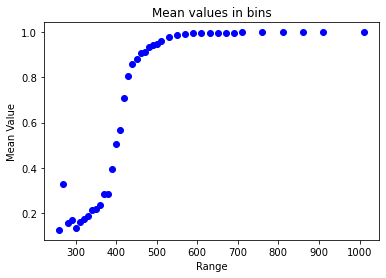

[0.01285175 0.05306364 0.04038431 0.06853032 0.05905927 0.07160291
 0.08765835 0.08919794 0.11390424 0.11681433 0.13559134 0.16363946
 0.16696846 0.24137257 0.32944543 0.37788752 0.5242283  0.65427071
 0.73011581 0.77339143 0.81372903 0.81970592 0.85739971 0.8753669
 0.88347988 0.90294312 0.93948692 0.96216252 0.96752537 0.97822357
 0.9854231  0.98357862 0.98848883 0.98826614 0.99141316 0.99179841
 0.99237987 0.9938287  0.99271129 0.99270053 0.99497991]


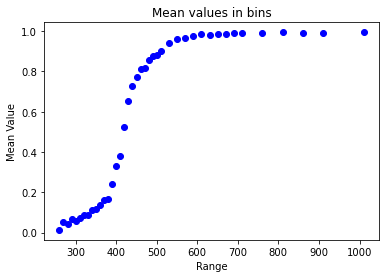

[0.32944519 0.21821606 0.35483172 0.32510815 0.24439938 0.23875258
 0.27736168 0.29706175 0.29382975 0.30054591 0.31631033 0.34409837
 0.30485925 0.38057005 0.42403188 0.47719932 0.5331258  0.66024646
 0.69948012 0.75440088 0.78776126 0.81657013 0.83513775 0.85731883
 0.87785405 0.9015959  0.92870381 0.93853371 0.95432229 0.95927628
 0.96468206 0.97379476 0.98007725 0.97663137 0.99261459 0.9922934
 0.99325364 0.99446937 0.99287441 0.99472466 0.99508939 0.99553999
 0.99587344 0.99726576 0.99725904 0.99670553 0.99756003 0.99753829
 0.99835534]


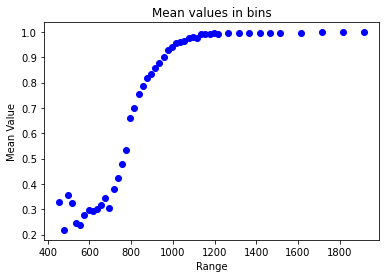

[0.43106795 0.31067959 0.42147936 0.38165114 0.29738137 0.28259988
 0.32600597 0.34543607 0.34523214 0.35344259 0.37454273 0.40265392
 0.36425023 0.44305693 0.50049636 0.55090422 0.61031696 0.73692531
 0.77205574 0.81617458 0.84640921 0.87041906 0.88708043 0.90446812
 0.92203663 0.93852597 0.95939473 0.96456655 0.97447539 0.977818
 0.9837478  0.98825635 0.9929335  0.9928935  0.99618569 0.99662461
 0.99662581 0.99698303 0.99681702 0.99744692 0.99764369 0.99771203
 0.99830842 0.99854041 0.99855379 0.99867844 0.99888365 0.99874416
 0.99920945]


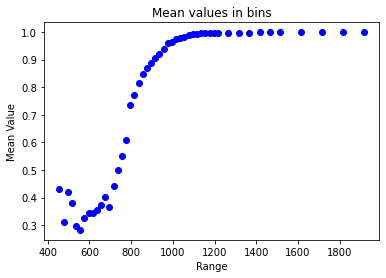

[0.22757758 0.13331689 0.28970347 0.27289965 0.19235465 0.19540271
 0.22902601 0.24882853 0.24234092 0.24791278 0.2581577  0.28560584
 0.24556719 0.3180953  0.34738251 0.40305561 0.45595825 0.58351632
 0.62687408 0.69216175 0.7286025  0.76259905 0.78251262 0.80942765
 0.83288633 0.86424868 0.89575962 0.91104324 0.93291438 0.93976233
 0.94322243 0.95695375 0.9572278  0.95184378 0.98865372 0.98561176
 0.98931928 0.99184746 0.98762939 0.9914284  0.99137241 0.99324295
 0.99143953 0.99566911 0.99576963 0.9925101  0.99534815 0.99593394
 0.99735381]


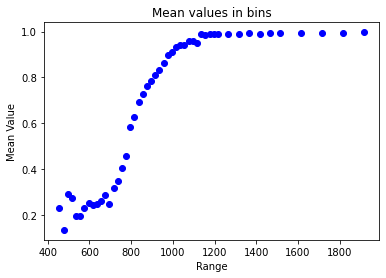

[0.72214109 0.70459745 0.71125749 0.71206128 0.72827405 0.73942962
 0.77138197 0.77936709 0.78760074 0.79090893 0.83486676 0.84860897
 0.85379445 0.87420532 0.87312679 0.89088611 0.89105559 0.90231871
 0.92025547 0.92345626 0.9191954  0.92968157 0.9479621  0.93871733
 0.95030948 0.96943966 0.96122669 0.96859707 0.95705477 0.96898599
 0.98529054 0.99284039 0.97955819 0.97052461 0.97489869 0.9915808
 0.94451497]


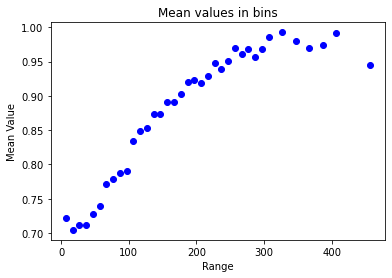

[0.76018405 0.7390437  0.74208733 0.74423787 0.76079116 0.77272529
 0.80788599 0.81476603 0.8273609  0.83219038 0.87811854 0.8922599
 0.9027792  0.91978923 0.92193481 0.93646576 0.93377665 0.94694891
 0.96890272 0.96768692 0.9797671  0.98385404 0.98772846 0.97688388
 0.97943975 0.99045654 0.98506192 0.9886358  0.98494772 0.99521711
 0.99599531 0.99705535 0.99360514 0.99618158 0.98908354 0.99606189
 0.97673762]


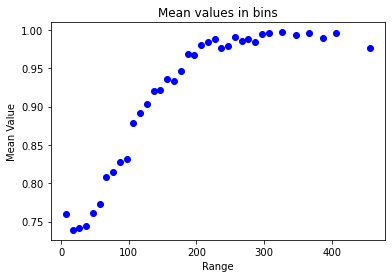

[0.68267951 0.66899917 0.67994273 0.67919864 0.69531737 0.70546182
 0.7342859  0.74308475 0.74697007 0.74849361 0.79084026 0.80377452
 0.80364892 0.82819123 0.82400109 0.84304569 0.84824429 0.85535198
 0.85132257 0.87880773 0.8544267  0.85775808 0.90619641 0.89976622
 0.92004402 0.94784503 0.93686577 0.94855833 0.9286503  0.93052494
 0.97434083 0.98862543 0.96401335 0.94486765 0.96048009 0.98694897
 0.91229233]


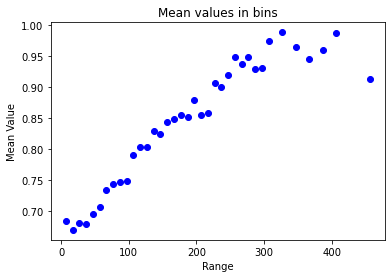

[0.43852052 0.16660951 0.18279076 0.22797088 0.29834138 0.33508068
 0.39306102 0.45595135 0.55022257 0.67181577 0.74315264 0.75063845
 0.81650042 0.82938438 0.85129143 0.87634037 0.87133663 0.88303471
 0.87433684 0.88186932 0.88092952 0.89781124 0.896563   0.90549446
 0.92516491 0.90967794 0.91948349 0.9264964  0.92235724 0.94510842
 0.93557423 0.94478077 0.92013794 0.94353307]


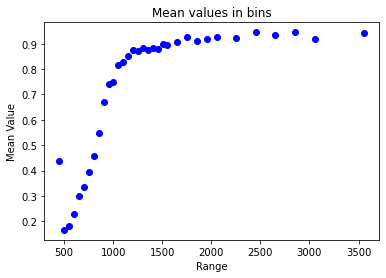

[0.58047815 0.24951031 0.26866754 0.29255404 0.35783972 0.39422622
 0.45339371 0.52102974 0.61449628 0.72645016 0.79162291 0.79619648
 0.85385003 0.85884506 0.87830407 0.90155344 0.89477189 0.90691229
 0.89516322 0.90287036 0.90431816 0.91846669 0.91907377 0.9257936
 0.94355607 0.92851456 0.93674185 0.94281948 0.94118425 0.96593825
 0.95119619 0.96269625 0.94085474 0.96470131]


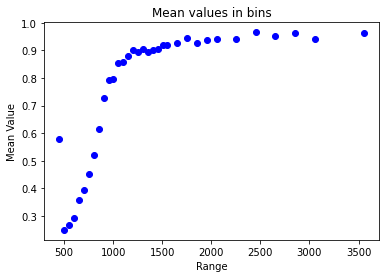

[0.3017035  0.07991675 0.10069488 0.16500036 0.2393754  0.27617616
 0.3330286  0.39060561 0.48558575 0.61644517 0.69441984 0.70435549
 0.77737927 0.79912081 0.8228416  0.84944994 0.8457221  0.85821697
 0.85210212 0.85970265 0.85651766 0.87521467 0.87258266 0.88428475
 0.90499552 0.8893886  0.90113047 0.90825494 0.90247313 0.92351562
 0.9185924  0.92559511 0.89832151 0.92202256]


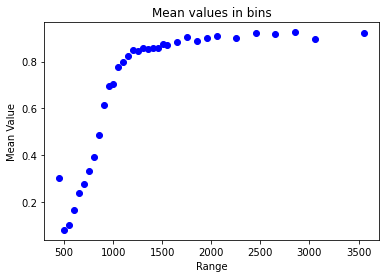

[0.42602648 0.61808773 0.67727498 0.6902378  0.75359346 0.80934607
 0.84185813 0.87088412 0.89432928 0.90526084 0.90999166 0.91355131
 0.93791015 0.94650011 0.96980605 0.96854787 0.9754843  0.99061616
 0.99072553 0.98530809 0.99303727 0.99438877 0.99516185 0.99870155
 0.99849858 0.99859101 0.99904288 0.99924311]


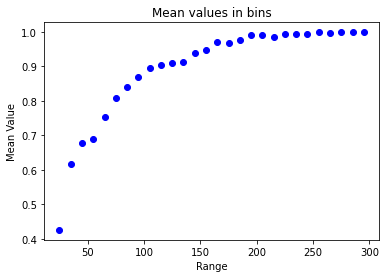

[0.49887471 0.67125265 0.72148824 0.73174822 0.79125884 0.83926553
 0.87055738 0.89609187 0.91800535 0.92618582 0.93111822 0.93273766
 0.95614213 0.96404248 0.98065234 0.97887398 0.98539509 0.99542189
 0.99578196 0.99189779 0.9969973  0.99840749 0.99715611 0.99931325
 0.9992441  0.99936158 0.99942612 0.99950157]


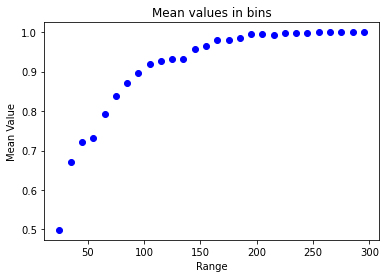

[0.3540243  0.564074   0.63210184 0.64784274 0.71511784 0.77850982
 0.81237372 0.84432526 0.8689605  0.88334802 0.88805081 0.89354483
 0.91883359 0.92635954 0.95756416 0.95782563 0.9652017  0.98362912
 0.98217424 0.977992   0.98905581 0.98246545 0.99316759 0.99801401
 0.99775307 0.99782044 0.99865964 0.99898465]


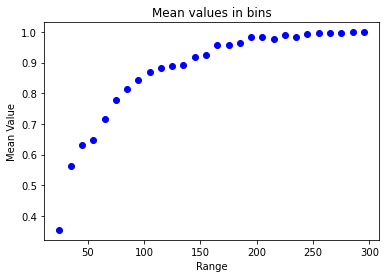

[0.24753548 0.47974525 0.3269096  0.35353095 0.3928696  0.44468071
 0.44184888 0.42985802 0.43814367 0.46383157 0.47154418 0.43805977
 0.44908783 0.46269732 0.49149243 0.51865319 0.56244599 0.58170032
 0.64910713 0.65249604 0.73201195 0.77015776 0.82379691 0.85414724
 0.88801042 0.9085632  0.91686471 0.93964907 0.94190954 0.9554269
 0.96461961 0.96931833 0.98240123 0.98959498 0.99313422 0.994586
 0.99526058 0.9963912  0.99706168 0.99694235 0.99726141 0.99720868
 0.99764602 0.99757589 0.99801333 0.99843449 0.99793541 0.99837298]


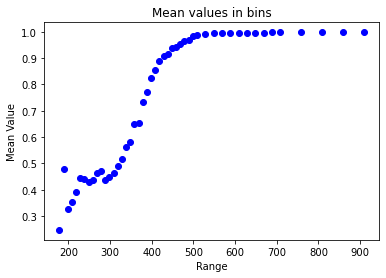

[0.34560726 0.56494596 0.41794398 0.42794318 0.46398651 0.52023156
 0.51115666 0.50111212 0.5016188  0.52807998 0.52879863 0.48932843
 0.50589202 0.51685019 0.54366206 0.57224971 0.61684689 0.6368065
 0.70294432 0.70850043 0.7857835  0.82236153 0.86969797 0.89607043
 0.92383131 0.93836594 0.94387335 0.96162806 0.96548438 0.97429063
 0.98146863 0.98482995 0.99286199 0.99516942 0.99659198 0.99774868
 0.99786561 0.99807747 0.99846677 0.99842975 0.99849246 0.99854275
 0.99888135 0.99890185 0.99900604 0.99909066 0.9991573  0.99907857]


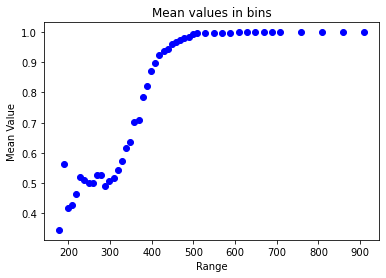

[0.14964791 0.39563994 0.23765725 0.28026811 0.32214546 0.37009649
 0.37291817 0.35926664 0.37515904 0.40009971 0.41429623 0.38590444
 0.39199793 0.4083394  0.43915614 0.46445669 0.50763267 0.52590806
 0.59496923 0.59633431 0.67680324 0.71736411 0.77629794 0.81020694
 0.85084304 0.87754761 0.8891379  0.91651213 0.91664588 0.93481485
 0.94596975 0.95172352 0.9693321  0.98194079 0.98775521 0.98798335
 0.99017421 0.99408127 0.99545352 0.99457146 0.99599297 0.995694
 0.99511935 0.9953536  0.9961176  0.99773889 0.99469682 0.99764788]


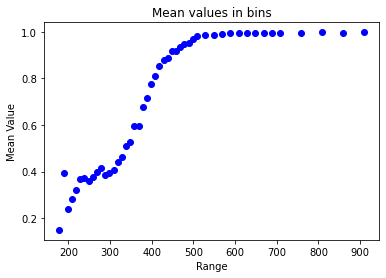

[0.56491107 0.62042791 0.64252613 0.69159234 0.75267389 0.79420344
 0.80148516 0.83045082 0.84845814 0.87608216 0.89620801 0.93356884
 0.95200026 0.95507792 0.96455072 0.98600496 0.98948253 0.99335716
 0.99762002 0.99594475 0.99767126 0.99873581 0.9990034  0.99878243
 0.99852306 0.99828985 0.99914591 0.99922845]


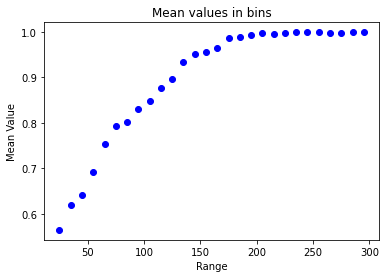

[0.63514325 0.67660295 0.68805901 0.73215285 0.78826594 0.82691152
 0.83277996 0.86011578 0.87757608 0.90087571 0.91941975 0.94876994
 0.96562851 0.97098288 0.97491683 0.99397389 0.99337633 0.99598755
 0.99876255 0.99855625 0.99879035 0.99936869 0.9994278  0.99930888
 0.99919195 0.99945088 0.99949884 0.9995561 ]


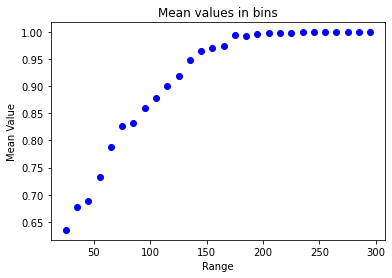

[0.4942891  0.56364107 0.59664447 0.65027791 0.71612063 0.76020154
 0.76978473 0.79993266 0.81795224 0.84960641 0.87041111 0.91643213
 0.93793513 0.93735791 0.9523348  0.97450918 0.98542428 0.99056052
 0.99647749 0.98803711 0.99613085 0.99810293 0.99857899 0.99825598
 0.99785416 0.99704605 0.99879298 0.9989008 ]


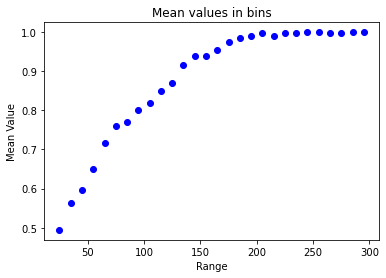

[0.45239718 0.28828165 0.27401775 0.24161209 0.19531403 0.20666596
 0.19380073 0.22806792 0.23721926 0.23968923 0.30555898 0.29655703
 0.33403135 0.39137574 0.45160498 0.48424495 0.590091   0.63706022
 0.72613763 0.77386061 0.83066586 0.85490312 0.86827311 0.88435564
 0.89997412 0.9077222  0.92937613 0.945893   0.95935826 0.97297351
 0.97760994 0.98385525 0.98561019 0.9843432  0.98609562 0.98942949
 0.99268856 0.99376057 0.99375115 0.99417702 0.99549139 0.99548599
 0.99553063 0.99645716 0.99686546 0.99668222 0.99730934 0.997753
 0.99777448]


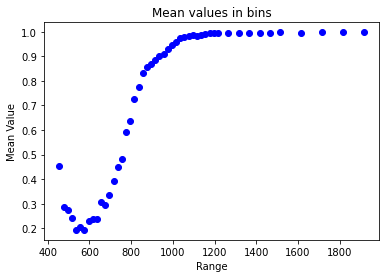

[0.52279528 0.34862745 0.36051541 0.32856326 0.25237059 0.24653164
 0.23777522 0.27804894 0.28901702 0.29480101 0.3646462  0.35576759
 0.3992628  0.46099247 0.52223619 0.56544445 0.66782985 0.71438322
 0.79523356 0.8380429  0.8831707  0.89965537 0.91046004 0.92496428
 0.93777894 0.9428595  0.96011894 0.97170101 0.98040546 0.98749582
 0.98970065 0.99340874 0.99386988 0.99297742 0.99502737 0.99550994
 0.9963647  0.99690604 0.99701981 0.99756039 0.99761474 0.99772578
 0.99812562 0.99827224 0.99845731 0.99870335 0.99877253 0.99900972
 0.99883489]


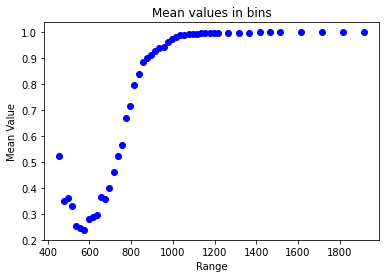

[0.38704754 0.23013578 0.19109901 0.1598657  0.14101519 0.16723473
 0.15028956 0.17872571 0.18564189 0.18469648 0.24638222 0.23721667
 0.2688218  0.3213724  0.38083075 0.40287201 0.51233438 0.55974822
 0.65699137 0.70951565 0.77757733 0.80943462 0.82551284 0.84304864
 0.86112034 0.87092057 0.89713888 0.91855347 0.93617894 0.95613567
 0.96291164 0.97117863 0.97496711 0.97130699 0.97146911 0.97825844
 0.98845265 0.98905233 0.98917125 0.99017577 0.99319091 0.99256045
 0.99148897 0.99385907 0.994672   0.9926481  0.99462244 0.99521638
 0.99660223]


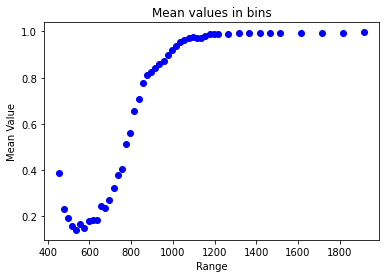

[       nan 0.05477254 0.05630448 0.07313624 0.10194604 0.19572109
 0.35755046 0.52084397 0.67416574 0.81431835 0.88035329 0.9195757
 0.94488244 0.97354235 0.98333741 0.98846384 0.99181637 0.99446039
 0.99442604 0.9954124  0.99644007 0.99683597 0.99688468 0.99569617
 0.99793196 0.99212014 0.99641974 0.99837626 0.99596381 0.99746341
 0.99342785]


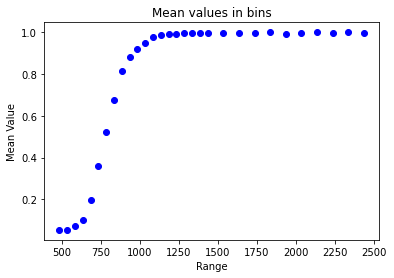

[       nan 0.10805416 0.10829675 0.11931063 0.14732583 0.25606434
 0.42463555 0.59403698 0.74570614 0.86776524 0.91963843 0.94837619
 0.96817162 0.98698571 0.99202176 0.99529481 0.99641734 0.9976434
 0.99759756 0.99800154 0.99831391 0.99851334 0.99875651 0.99871026
 0.99907582 0.99842278 0.99915906 0.99922046 0.99924255 0.99997897
 0.99660084]


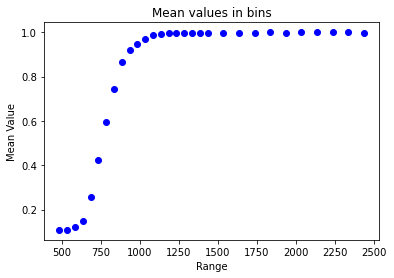

[       nan 0.0086466  0.01138165 0.02939076 0.05711641 0.1354705
 0.29019256 0.44736867 0.60230515 0.76021853 0.83999008 0.88906354
 0.92022027 0.95839068 0.97165042 0.97900931 0.98558445 0.99041379
 0.98947771 0.99144954 0.99411739 0.99470228 0.99323671 0.98967594
 0.9953938  0.98576795 0.9913398  0.99733497 0.98444681 0.99420239
 0.99025487]


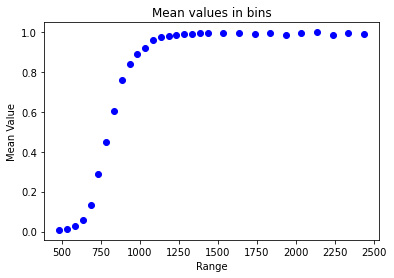

[       nan 0.35134818 0.08419405 0.05366414 0.14037868 0.15753609
 0.23585874 0.30052643 0.39631004 0.50940858 0.60488472 0.68686701
 0.73267186 0.78160082 0.79842281 0.84367046 0.87170649 0.86070188
 0.88702152 0.86748113 0.88953529 0.88094151 0.9002766  0.90243274
 0.91135984 0.93449135 0.91782373 0.91756307 0.92816305 0.95566912
 0.94080205 0.93075022 0.93557719 0.92645123]


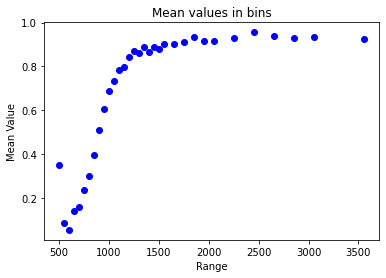

[       nan 0.48164869 0.16376668 0.09841021 0.19714894 0.20292926
 0.28773575 0.35511659 0.45792198 0.575552   0.66654056 0.74350176
 0.78310728 0.82341075 0.83763022 0.87620331 0.8996269  0.8887143
 0.91278909 0.89082141 0.91245698 0.90486656 0.92257508 0.92533109
 0.93062336 0.95150876 0.93546928 0.9351814  0.94651966 0.97393489
 0.95875225 0.9488346  0.95433751 0.94926896]


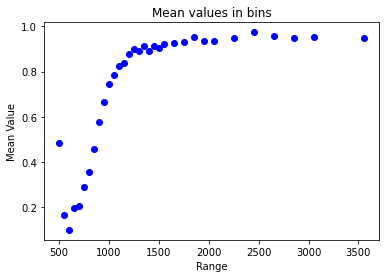

[       nan 0.2030419  0.00932021 0.0124586  0.0878205  0.11254352
 0.18464554 0.24609789 0.33479119 0.44328412 0.54255811 0.62987109
 0.68140879 0.73925524 0.75854579 0.8094957  0.84154818 0.83167506
 0.85952859 0.84277847 0.86488729 0.85639815 0.87678159 0.8780223
 0.89132028 0.9145645  0.89976944 0.89848102 0.90846093 0.93604292
 0.92138366 0.91021628 0.91517886 0.90328692]


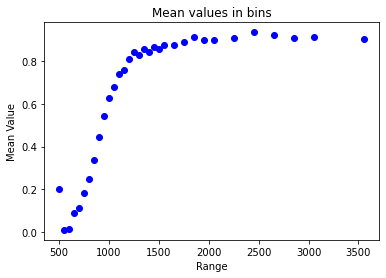

[0.69255345 0.73820893 0.78304871 0.78293756 0.74034159 0.72466284]


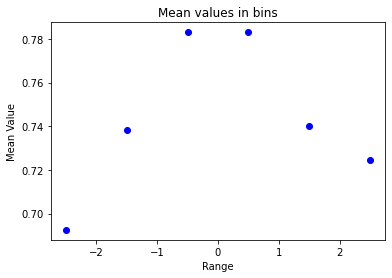

[0.74538819 0.7750662  0.81683641 0.81639899 0.77627478 0.76739797]


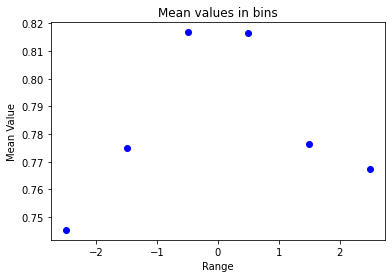

[0.63892911 0.70072924 0.74837571 0.74833715 0.70341855 0.68052994]


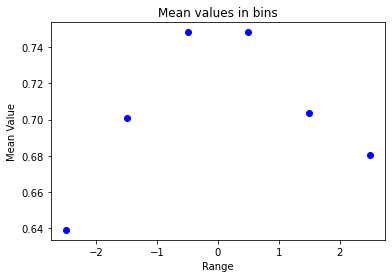

[0.70645509 0.75643967 0.76185101 0.76887603 0.75775291 0.73213804]


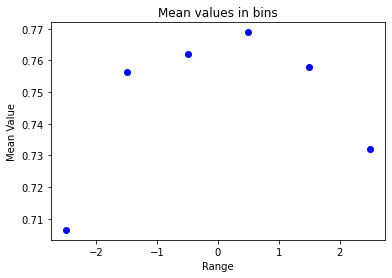

[0.75995937 0.79142621 0.7948695  0.80192042 0.79592674 0.78284788]


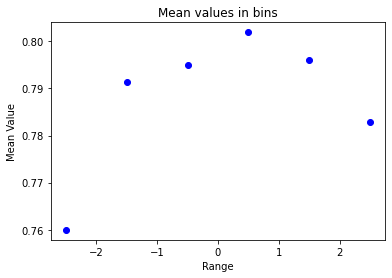

[0.6514637  0.72061912 0.72793998 0.73481361 0.71863231 0.68092143]


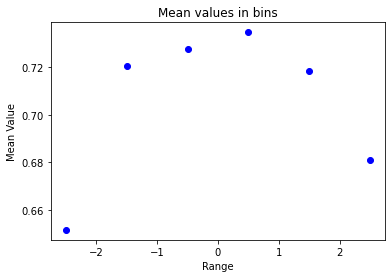

[0.75988783 0.75841374 0.75770837 0.77031417 0.76380566 0.74571098
 0.73003221 0.75968592 0.65699945 0.70021873]


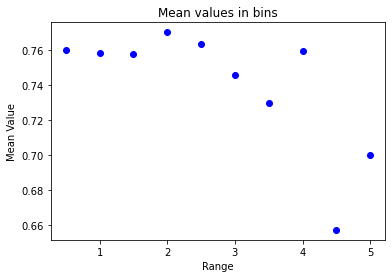

[0.79674558 0.79288521 0.79198979 0.804728   0.79895486 0.78301503
 0.77425199 0.809893   0.70955859 0.74509314]


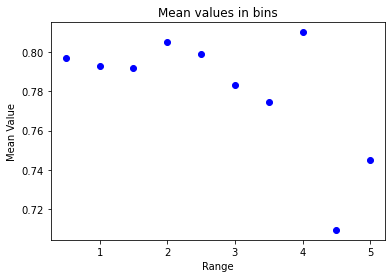

[0.72236211 0.72305901 0.72228036 0.73491079 0.72756238 0.70764124
 0.68442419 0.7084904  0.60399571 0.65595351]


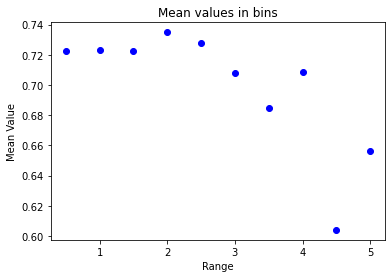

[0.83079753 0.75511817 0.77974743 0.80403523 0.91348967 0.8809449
 0.82574593 0.77022929 0.74969298 0.7721466 ]


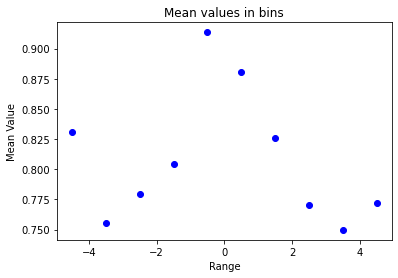

[0.90669697 0.79049787 0.81616453 0.86424575 0.94504068 0.93825045
 0.89112593 0.80600216 0.78413688 0.85257513]


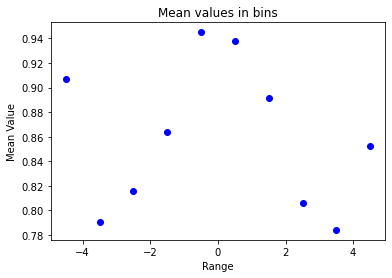

[0.75053165 0.71911856 0.74230569 0.7421882  0.88172045 0.82279842
 0.76026093 0.73358465 0.71407397 0.68956536]


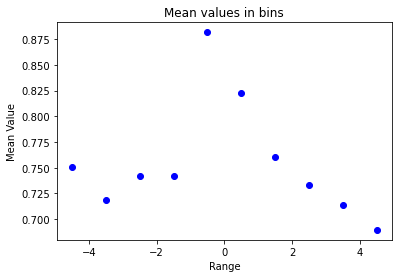

In [75]:
if sample == "QCD":
    
    pddf,features= RD_to_pandas(df_QCD, filter_all_meas, names_list_and_signal_trigger, names_list)


    y = pddf[signal_trigger].astype('bool')
    y = y*1
    y = y.astype(int).values
    
    X = features.values 
    
    # Get the gradient boosting predicted efficiencies and uncertainties
    mean_list_QCD, mean_plus_list_QCD, mean_minus_list_QCD = mean_and_standard_deviation(models, X, y, num_bins_list, range_min_list, range_max_list)

In [23]:
auc_scores = []
test_accuracies = []

n_samples = 20

for i in range(n_samples):
    test_predictions = models[i].predict(X)
    test_accuracy = accuracy_score(y, test_predictions)
    test_accuracies.append(test_accuracy)

    # Calculate AUC-ROC score for each model
    y_scores = models[i].predict_proba(X)[:, 1]  # Probability of positive class
    auc_score = roc_auc_score(y, y_scores)
    auc_scores.append(auc_score)

    print(f"Model {i + 1} - Test Accuracy: {test_accuracy:.4f} - AUC-ROC Score: {auc_score:.4f}")

avg_test_accuracy = np.mean(test_accuracies)
avg_auc_score = np.mean(auc_scores)
print(f"\nAverage Test Accuracy across all models: {avg_test_accuracy:.4f}")
print(f"Average AUC-ROC Score across all models: {avg_auc_score:.4f}")



Model 1 - Test Accuracy: 0.9111 - AUC-ROC Score: 0.9604
Model 2 - Test Accuracy: 0.9100 - AUC-ROC Score: 0.9598
Model 3 - Test Accuracy: 0.9102 - AUC-ROC Score: 0.9593
Model 4 - Test Accuracy: 0.9091 - AUC-ROC Score: 0.9606
Model 5 - Test Accuracy: 0.9092 - AUC-ROC Score: 0.9579
Model 6 - Test Accuracy: 0.9112 - AUC-ROC Score: 0.9587
Model 7 - Test Accuracy: 0.9106 - AUC-ROC Score: 0.9602
Model 8 - Test Accuracy: 0.9114 - AUC-ROC Score: 0.9592
Model 9 - Test Accuracy: 0.9100 - AUC-ROC Score: 0.9594
Model 10 - Test Accuracy: 0.9102 - AUC-ROC Score: 0.9589
Model 11 - Test Accuracy: 0.9104 - AUC-ROC Score: 0.9597
Model 12 - Test Accuracy: 0.9096 - AUC-ROC Score: 0.9588
Model 13 - Test Accuracy: 0.9080 - AUC-ROC Score: 0.9593
Model 14 - Test Accuracy: 0.9106 - AUC-ROC Score: 0.9603
Model 15 - Test Accuracy: 0.9110 - AUC-ROC Score: 0.9596
Model 16 - Test Accuracy: 0.9097 - AUC-ROC Score: 0.9588
Model 17 - Test Accuracy: 0.9080 - AUC-ROC Score: 0.9588
Model 18 - Test Accuracy: 0.9104 - AUC-R

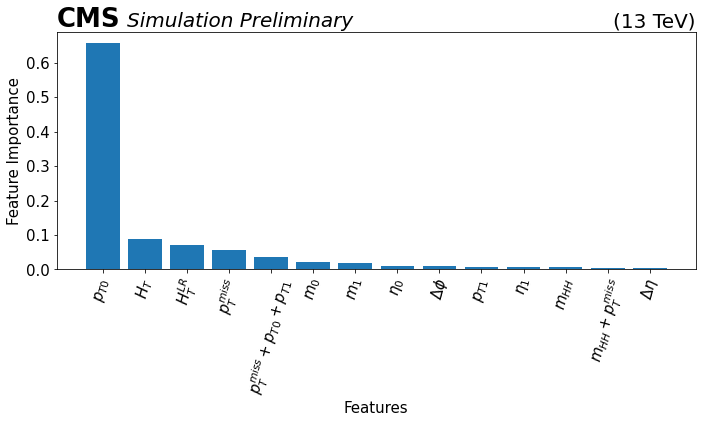

In [39]:
# Draw the feature importance ranking plot

custom_feature_names = [f'Feature {i}' for i in range(1, 11)]

new_names = [r'$p_{T0}$',r'$H_T$',r"$p_{T}^{miss}$",r"$m_{HH}$", r"$m_{0}$",r"$p_{T1}$", r"$m_{1}$",
                   r"$H_T^{LR}$", r"$p_{T}^{miss}+p_{T0}+p_{T1}$",r"$m_{HH}+p_{T}^{miss}$",r"$\eta_{0}$", r"$\eta_{1}$", r"$\Delta\eta$", r"$\Delta\phi$"]

# Feature Importance Ranking
feature_importance = np.zeros(X.shape[1])

for model in models:
    feature_importance += model.feature_importances_

average_feature_importance = feature_importance / len(models)

# Sort features by importance
sorted_indices = np.argsort(average_feature_importance)[::-1]
sorted_features = [new_names[i] for i in sorted_indices]
sorted_importance = average_feature_importance[sorted_indices]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), sorted_importance, align='center')
plt.xticks(range(X.shape[1]), sorted_features, rotation=75,size=15)
    
# Add text to the plot similar to ROOT
plt.text(0, 1.02, "CMS", fontdict={'fontsize': 26, 'fontweight': 'bold'}, transform=plt.gca().transAxes)
if sample == "DATA":
    plt.text(0.11, 1.02, "Preliminary", fontdict={'fontsize': 20, 'style': 'italic'}, transform=plt.gca().transAxes)
    plt.text(0.72, 1.02, "59.8 fb$^{-1}$", fontdict={'fontsize': 20}, transform=plt.gca().transAxes)
else:
    plt.text(0.11, 1.02, "Simulation Preliminary", fontdict={'fontsize': 20, 'style': 'italic'}, transform=plt.gca().transAxes)

plt.text(0.87, 1.02, "(13 TeV)", fontdict={'fontsize': 20}, transform=plt.gca().transAxes)
plt.yticks(size=15)
plt.xlabel('Features',size=15)
plt.ylabel('Feature Importance',size=15)
#plt.title('Feature Importance Ranking')
plt.tight_layout()
plt.show()

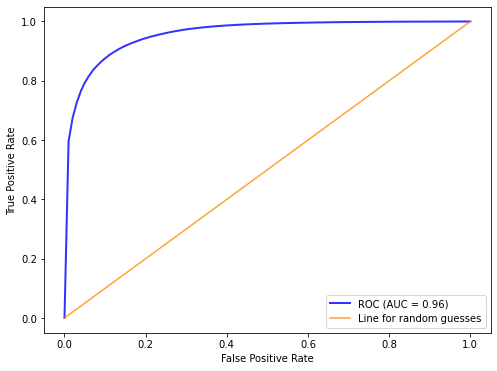

In [40]:
# Draw ROC curve for the ensemble
plt.figure(figsize=(8, 6))

# Calculate ROC curve for each model
mean_fpr = np.linspace(0, 1, 100)
tprs = []
for i in range(n_samples):
    y_scores = models[i].predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_scores)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

# Calculate mean and standard deviation of ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
std_tpr = np.std(tprs, axis=0)

plt.plot(mean_fpr, mean_tpr, color='b', label=f'ROC (AUC = {avg_auc_score:.2f})', lw=2, alpha=0.8)

# Plot the diagonal (random classifier)
plt.plot([0, 1], [0, 1], color='darkorange', alpha=0.8, label = 'Line for random guesses') 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#.title('ROC Curve for Ensemble of Models')
plt.legend(loc='lower right')
plt.show()

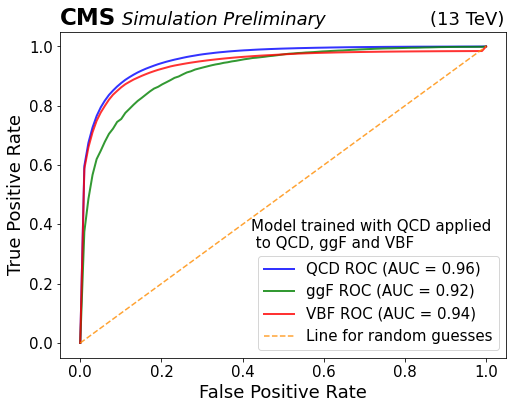

In [51]:
# ROC curve with all samples
plt.figure(figsize=(8, 6))

# Plot ROC curve for the ensemble
plt.plot(mean_fpr, mean_tpr, color='b', label=f'QCD ROC (AUC = {avg_auc_score:.2f})', lw=2, alpha=0.8)

# Plot ROC curve for model 1
plt.plot(mean_fpr_ggF, mean_tpr_ggF, color='g', label=f'ggF ROC (AUC = {avg_auc_score_ggF:.2f})', lw=2, alpha=0.8)

# Plot ROC curve for model 2
plt.plot(mean_fpr_VBF, mean_tpr_VBF, color='r', label=f'VBF ROC (AUC = {avg_auc_score_VBF:.2f})', lw=2, alpha=0.8)

# Plot the diagonal (random classifier)
plt.plot([0, 1], [0, 1], color='darkorange', alpha=0.8, linestyle='--', label='Line for random guesses')



plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
    
# Add text to the plot similar to ROOT
plt.text(0, 1.02, "CMS", fontdict={'fontsize': 23, 'fontweight': 'bold'}, transform=plt.gca().transAxes)
if sample == "DATA":
    plt.text(0.15, 1.02, "Preliminary", fontdict={'fontsize': 20, 'style': 'italic'}, transform=plt.gca().transAxes)
    plt.text(0.61, 1.02, "59.8 fb$^{-1}$", fontdict={'fontsize': 20}, transform=plt.gca().transAxes)
else:
    plt.text(0.14, 1.02, "Simulation Preliminary", fontdict={'fontsize': 18, 'style': 'italic'}, transform=plt.gca().transAxes)
    plt.text(0.42,0.32, "Model trained with QCD applied \n to QCD, ggF and VBF",fontdict={'fontsize': 15})

plt.text(0.83, 1.02, "(13 TeV)", fontdict={'fontsize': 18}, transform=plt.gca().transAxes)
    
plt.legend(loc='lower right', fontsize=15)
plt.show()

### DNN

In [3]:
"""
Initial training of the DNN model

pddf,features= RD_to_pandas(df_QCD, filter_all_meas, [ "HighestPt", "HT", "MET_pt", "mHH","HighestMass","SecondHighestPt", 
                                                           "SecondHighestMass", "Combo", "FatHT", "MET_FatJet", "mHHwithMET", "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"],
                             [ "HighestPt", "HT","MET_pt", "mHH","HighestMass","SecondHighestPt", "SecondHighestMass", "FatHT", "MET_FatJet","mHHwithMET",
                              "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"])


features=pddf[[ "HighestPt", "HT","MET_pt", "mHH","HighestMass","SecondHighestPt", "SecondHighestMass", "FatHT", "MET_FatJet","mHHwithMET",
                              "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"]]



y_dnn = pddf["Combo"].astype('bool')
y_dnn = y_dnn*1
y_dnn = y_dnn.astype(int).values
X_dnn = features.values # tähän nFatJet, FatJet_pt[0], HT

X_train_dnn, X_test_dnn, y_train_dnn, y_test_dnn = train_test_split(X_dnn, y_dnn, test_size=0.3)

# define the keras model
dnn_model = Sequential()
dnn_model.add(Dense(12, input_shape=(None,14), activation='relu'))
dnn_model.add(Dense(10, activation='relu'))
dnn_model.add(Dense(8, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))
# compile the keras model
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
dnn_model.fit(X_train_dnn, y_train_dnn, epochs=60, batch_size=10)
# evaluate the keras model
_, accuracy = dnn_model.evaluate(X_test_dnn, y_test_dnn)
print('Accuracy: %.2f' % (accuracy*100))

y_pred_dnn = dnn_model.predict(X_test_dnn)

plt.plot(X_test_dnn[:,1],y_pred_dnn, "o")
plt.xlim(0,1500)

"""


'\nInitial training of the DNN model\n\npddf,features= RD_to_pandas(df_QCD, filter_all_meas, [ "HighestPt", "HT", "MET_pt", "mHH","HighestMass","SecondHighestPt", \n                                                           "SecondHighestMass", "Combo", "FatHT", "MET_FatJet", "mHHwithMET", "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"],\n                             [ "HighestPt", "HT","MET_pt", "mHH","HighestMass","SecondHighestPt", "SecondHighestMass", "FatHT", "MET_FatJet","mHHwithMET",\n                              "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"])\n\n\nfeatures=pddf[[ "HighestPt", "HT","MET_pt", "mHH","HighestMass","SecondHighestPt", "SecondHighestMass", "FatHT", "MET_FatJet","mHHwithMET",\n                              "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"]]\n\n\n\ny_dnn = pddf["Combo"].astype(\'bool\')\ny_dnn = y_dnn*1\ny_dnn = y_dnn.astype(int).values\nX_dnn = features.values # tähän nFatJet, FatJet_pt[0], HT\n\nX_train_dn

In [213]:
#dnn_model.save("dnn_model_gradu_NEW.keras")

dnn_model = tf.keras.models.load_model("dnn_model_gradu_NEW.keras")

In [214]:

pddf,features= RD_to_pandas(df_QCD, filter_all_meas, ["HighestPt", "HT", "MET_pt", "mHH","HighestMass","SecondHighestPt", 
                                                           "SecondHighestMass", "FatHT", "MET_FatJet", "mHHwithMET", "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi","Combo"],
                             [ "HighestPt", "HT","MET_pt", "mHH","HighestMass","SecondHighestPt", "SecondHighestMass", "FatHT", "MET_FatJet","mHHwithMET",
                              "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"])



y_dnn = pddf["Combo"].astype('bool')
y_dnn = y_dnn*1
y_dnn = y_dnn.astype(int).values
X_dnn = features.values 

y_pred_dnn = dnn_model.predict(X_dnn)

561/561 [==============================] - 1s 968us/step


[0.01856595 0.07304292 0.05791829 0.0701041  0.06817229 0.09907219
 0.12235163 0.13629104 0.17624644 0.19180539 0.24448806 0.29356951
 0.34125614 0.40773532 0.47824536 0.50817387 0.57270375 0.64049462
 0.70752468 0.75608682 0.80385273 0.84194334 0.87893352 0.904345
 0.92050013 0.9454467  0.96622828 0.97916045 0.98743945 0.99297005
 0.99573855 0.99746798 0.99847887 0.99920825 0.99951603 0.99980708
 0.99994686 0.99998577 0.99999555 0.99999949 0.99999998]


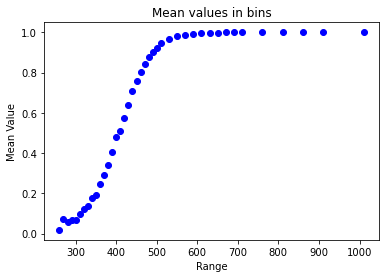

[0.27514598 0.20431317 0.32768733 0.32316634 0.22122384 0.221761
 0.24546644 0.2545277  0.26400415 0.28254188 0.3166442  0.36781654
 0.35014033 0.42863913 0.46319371 0.49844612 0.55322847 0.62902127
 0.66502042 0.72203497 0.76174594 0.7964254  0.82879149 0.85588922
 0.88169896 0.90653994 0.92818204 0.9337888  0.94643682 0.95857877
 0.96503179 0.97064179 0.97789921 0.97967367 0.98496146 0.9888503
 0.9909219  0.99368274 0.99531806 0.99767284 0.99883114 0.9993396
 0.99962964 0.99986383 0.9999298  0.99998017 0.99999498 0.99999845
 0.99999978]


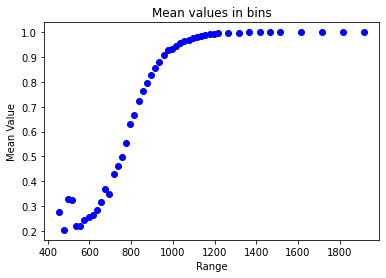

[0.73091829 0.71994863 0.7248386  0.72464623 0.73695473 0.74817903
 0.76263133 0.77081874 0.77205386 0.77161941 0.79856513 0.8046379
 0.81280219 0.79494666 0.82602053 0.83570167 0.87214403 0.86143881
 0.9096926  0.91096589 0.93753347 0.94928121 0.94744282 0.97517075
 0.98551681 0.99217758 0.99538367 0.99789903 0.99496991 0.99804843
 0.99922406 0.99934156 0.99952234 0.99996517 0.99999334 0.99998862
 0.99999352]


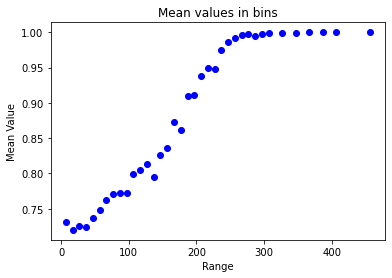

[0.27231537 0.11846466 0.13132564 0.21909317 0.28107578 0.33965548
 0.41879499 0.50265347 0.58129411 0.67158696 0.7424476  0.7595414
 0.81670939 0.82839642 0.84295625 0.86739129 0.85933728 0.875641
 0.86721938 0.87463316 0.87250568 0.88893229 0.8883572  0.89340426
 0.91117529 0.89129036 0.90779674 0.91085283 0.90325521 0.92214837
 0.92056744 0.93387502 0.90902458 0.9280377 ]


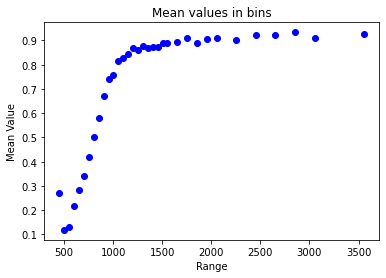

[0.37677713 0.57556601 0.66505546 0.69959303 0.76734894 0.81592427
 0.83565614 0.8452567  0.86352859 0.88311684 0.89868128 0.90697038
 0.9333087  0.94086223 0.96538369 0.96424123 0.97710671 0.99046523
 0.99479913 0.99291747 0.99642401 0.99905843 0.9984068  0.99954247
 0.99987011 0.99994123 0.99993734 0.99999979]


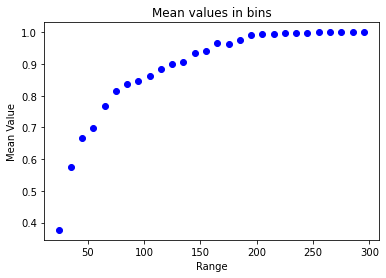

[0.27424191 0.43815258 0.27323883 0.33751257 0.37521655 0.37695793
 0.38856177 0.4074961  0.40445499 0.44147647 0.45398854 0.43489068
 0.44961037 0.48196676 0.51067574 0.55082388 0.58698247 0.60950561
 0.68129475 0.69254681 0.74521071 0.76957283 0.8044571  0.82676081
 0.86091685 0.87719893 0.90186431 0.93050157 0.93892279 0.95411419
 0.96576909 0.96954705 0.97848229 0.98323415 0.98987034 0.99387022
 0.99655676 0.9979758  0.99893034 0.99941903 0.99965248 0.99980942
 0.99990121 0.99994716 0.99998678 0.99999665 0.99999935 0.99999987]


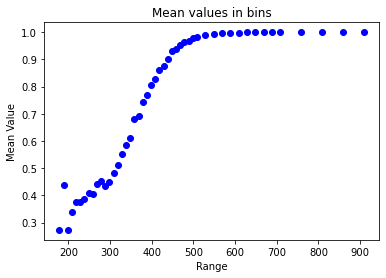

[0.52240528 0.61630322 0.6660011  0.69611893 0.74755449 0.77292835
 0.79240321 0.82487792 0.84936178 0.88419611 0.89964975 0.93222172
 0.94706375 0.96204191 0.97444507 0.9879237  0.99193447 0.99524452
 0.99911903 0.99944332 0.9992898  0.99957698 0.9998724  0.99999159
 0.99997756 0.99998609 0.99999765 0.99999791]


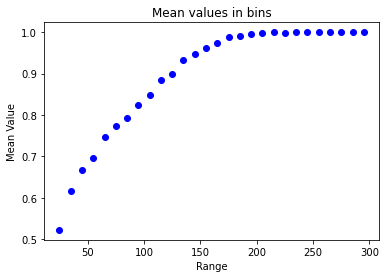

[0.33870633 0.20503476 0.18267699 0.16006772 0.14088285 0.18623795
 0.18255903 0.20774062 0.23192189 0.24456069 0.29559356 0.32332141
 0.37557151 0.43969358 0.50278608 0.53066933 0.60288862 0.63341423
 0.6923527  0.73549795 0.78140675 0.81602562 0.85465471 0.87587935
 0.90374139 0.91796392 0.93515918 0.94533027 0.95766874 0.96402845
 0.96993957 0.97908263 0.98179808 0.98285841 0.98686116 0.98939028
 0.99334879 0.99481746 0.99560102 0.99743254 0.99887845 0.99937641
 0.99955081 0.99962902 0.99977961 0.9999772  0.99999505 0.99999911
 0.99999969]


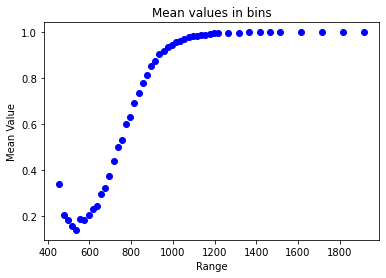

[       nan 0.03091322 0.04895151 0.08399542 0.14433369 0.24174456
 0.37145022 0.52216736 0.65002998 0.76627743 0.85404653 0.92005154
 0.95420657 0.97497022 0.98608904 0.99287563 0.99614684 0.99822263
 0.99904137 0.99959215 0.99980837 0.99994813 0.99998554 0.99999599
 0.99999919 0.99999981 0.99999993 1.         1.         1.
 1.        ]


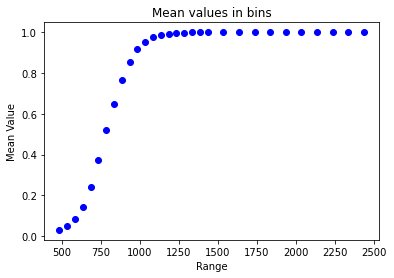

[       nan 0.34538803 0.08323273 0.06385051 0.15427012 0.20041798
 0.27333014 0.34581086 0.42672896 0.53068924 0.60533608 0.67806411
 0.72451838 0.78045589 0.79559779 0.83590724 0.86415194 0.85170704
 0.88055781 0.86097363 0.88142541 0.87406669 0.88963063 0.89564051
 0.89772064 0.920866   0.90172077 0.90242443 0.91353971 0.93416657
 0.92981194 0.91726822 0.9239367  0.91213615]


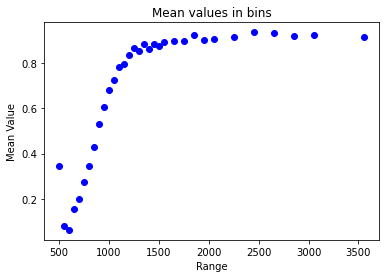

[0.67936102 0.7506835  0.76914932 0.77677334 0.74592073 0.71810707]


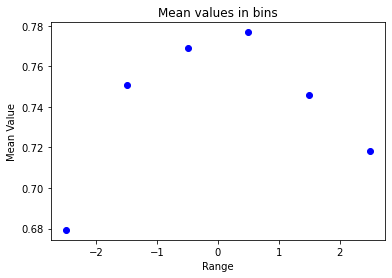

[0.69160687 0.74655329 0.76521023 0.77548394 0.75307203 0.70248571]


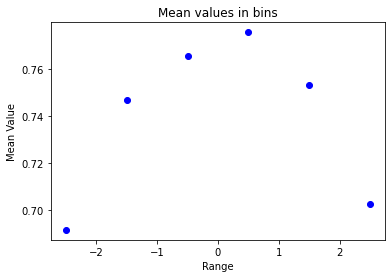

[0.76876523 0.76569799 0.75877336 0.76036295 0.75647987 0.72621726
 0.70062026 0.70490152 0.6275871  0.67385353]


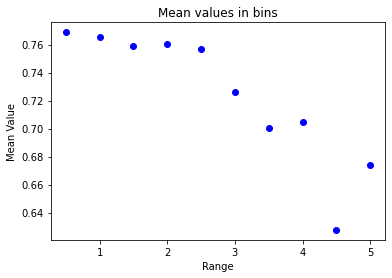

[0.72426604 0.75532398 0.77312546 0.73153789 0.88674438 0.79475937
 0.74655548 0.76014185 0.75321411 0.71933533]


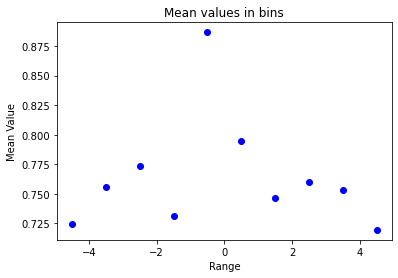

In [215]:
h_dnn_pt_QCD=mean_efficiency(X_dnn[:,0],y_pred_dnn[:,0], num_bins_pt, range_min_pt, range_max_pt)

h_dnn_HT_QCD=mean_efficiency(X_dnn[:,1],y_pred_dnn[:,0], num_bins_HT, range_min_HT, range_max_HT)

h_dnn_MET_QCD=mean_efficiency(X_dnn[:,2],y_pred_dnn[:,0], num_bins_MET, range_min_MET, range_max_MET)

h_dnn_mHH_QCD=mean_efficiency(X_dnn[:,3],y_pred_dnn[:,0], num_bins_mHH, range_min_mHH, range_max_mHH)

h_dnn_mass_QCD=mean_efficiency(X_dnn[:,4],y_pred_dnn[:,0], num_bins_mass, range_min_mass, range_max_mass)

h_dnn_pt1_QCD=mean_efficiency(X_dnn[:,5],y_pred_dnn[:,0], num_bins_pt1, range_min_pt1, range_max_pt1)

h_dnn_mass1_QCD=mean_efficiency(X_dnn[:,6],y_pred_dnn[:,0], num_bins_mass, range_min_mass, range_max_mass)

h_dnn_FJHT_QCD=mean_efficiency(X_dnn[:,7],y_pred_dnn[:,0], num_bins_HT, range_min_HT, range_max_HT)

h_dnn_METfj_QCD=mean_efficiency(X_dnn[:,8],y_pred_dnn[:,0], num_bins_METfj, range_min_METfj, range_max_METfj)

h_dnn_mHHwMET_QCD=mean_efficiency(X_dnn[:,9],y_pred_dnn[:,0], num_bins_mHH, range_min_mHH, range_max_mHH)

h_dnn_eta_QCD=mean_efficiency(X_dnn[:,10],y_pred_dnn[:,0], num_bins_eta, range_min_eta, range_max_eta)

h_dnn_eta1_QCD=mean_efficiency(X_dnn[:,11],y_pred_dnn[:,0], num_bins_eta, range_min_eta, range_max_eta)

h_dnn_deltaeta_QCD=mean_efficiency(X_dnn[:,12],y_pred_dnn[:,0], num_bins_delta, 0, range_max_delta)

h_dnn_deltaphi_QCD=mean_efficiency(X_dnn[:,13],y_pred_dnn[:,0], num_bins_phi, range_min_phi, range_max_phi)

DNN_QCD = [h_dnn_pt_QCD, h_dnn_HT_QCD,h_dnn_MET_QCD, h_dnn_mHH_QCD, h_dnn_mass_QCD, h_dnn_pt1_QCD, h_dnn_mass1_QCD,h_dnn_FJHT_QCD,
           h_dnn_METfj_QCD,h_dnn_mHHwMET_QCD,h_dnn_eta_QCD,h_dnn_eta1_QCD,h_dnn_deltaeta_QCD,h_dnn_deltaphi_QCD]

#DNN_QCD2 = [h_dnn_FJHT_QCD,h_dnn_METfj_QCD,h_dnn_mHHwMET_QCD,h_dnn_eta_QCD,h_dnn_eta1_QCD,h_dnn_deltaeta_QCD,h_dnn_deltaphi_QCD]

### STD plots

Remember to change run_name if needed!

In [217]:

for j in range(0,len(num_bins_list)):    
    efficiency_plot_stds(eff_real_list_QCD[j],eff_meas_list_QCD[j], mean_list_QCD[j], mean_plus_list_QCD[j], mean_minus_list_QCD[j], DNN_QCD[j], "True efficiency","Measured efficiency", 
                         "GB mean efficiency","DNN efficiency","",y_min_list[j], y_max_list[j], range_min_list[j],range_max_list[j], names_list_plot[j],"STD_QCD_TEfficiency_"+names_list[j]+"_GB1_"+ run_name+".png","QCD")
    
    

Info in <TCanvas::Print>: png file STD_QCD_TEfficiency_HighestPt_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_QCD_TEfficiency_HT_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_QCD_TEfficiency_MET_pt_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_QCD_TEfficiency_mHH_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_QCD_TEfficiency_HighestMass_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_QCD_TEfficiency_SecondHighestPt_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_QCD_TEfficiency_SecondHighestMass_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_QCD_TEfficiency_FatHT_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_QCD_TEfficiency_MET_FatJet_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_QCD_TEfficiency_mHHwithMET_GB1_DNN_gradu.png has been created
In

### ggF

Model 1 - Test Accuracy: 0.8751 - AUC-ROC Score: 0.9109
Model 2 - Test Accuracy: 0.8798 - AUC-ROC Score: 0.9140
Model 3 - Test Accuracy: 0.8798 - AUC-ROC Score: 0.9242
Model 4 - Test Accuracy: 0.8851 - AUC-ROC Score: 0.9154
Model 5 - Test Accuracy: 0.8878 - AUC-ROC Score: 0.9269
Model 6 - Test Accuracy: 0.8782 - AUC-ROC Score: 0.9214
Model 7 - Test Accuracy: 0.8798 - AUC-ROC Score: 0.9177
Model 8 - Test Accuracy: 0.8825 - AUC-ROC Score: 0.9182
Model 9 - Test Accuracy: 0.8745 - AUC-ROC Score: 0.9176
Model 10 - Test Accuracy: 0.8867 - AUC-ROC Score: 0.9213
Model 11 - Test Accuracy: 0.8788 - AUC-ROC Score: 0.9186
Model 12 - Test Accuracy: 0.8841 - AUC-ROC Score: 0.9181
Model 13 - Test Accuracy: 0.8862 - AUC-ROC Score: 0.9249
Model 14 - Test Accuracy: 0.8841 - AUC-ROC Score: 0.9125
Model 15 - Test Accuracy: 0.8835 - AUC-ROC Score: 0.9215
Model 16 - Test Accuracy: 0.8819 - AUC-ROC Score: 0.9142
Model 17 - Test Accuracy: 0.8724 - AUC-ROC Score: 0.9127
Model 18 - Test Accuracy: 0.8925 - AUC-R

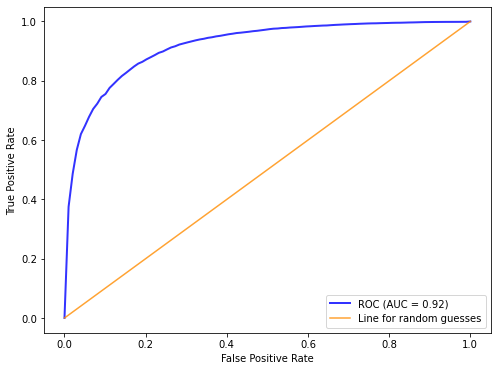

[       nan        nan        nan 0.25512439 0.27127151 0.24585644
 0.43300858 0.39226306 0.38452893 0.50313201 0.48590259 0.56269437
 0.69358001 0.75208956 0.87536915 0.89650312 0.92799539 0.93188056
 0.9377402  0.957178   0.96015468 0.95829738 0.96181438 0.97123453
 0.97703161 0.97329321 0.98095063 0.98137338 0.98587492 0.98769852
 0.99256276 0.99413943 0.9927965  0.99633359 0.9965165  0.99747493
 0.99820251 0.97562345 0.82930403]


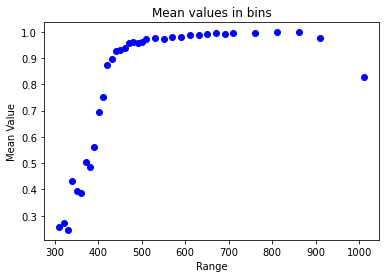

[       nan        nan        nan 0.32552876 0.35351326 0.32000664
 0.52209285 0.47334554 0.47066369 0.5869978  0.58066554 0.6530039
 0.79147995 0.83524348 0.92865487 0.94327413 0.96118873 0.95845367
 0.96576635 0.97823406 0.97749838 0.98156415 0.97934182 0.98517212
 0.99180821 0.98938462 0.99327517 0.99427233 0.99516487 0.99629143
 0.99727832 0.99792307 0.9987887  0.99913554 0.9991526  0.99879479
 0.9991569  0.99920461 1.        ]


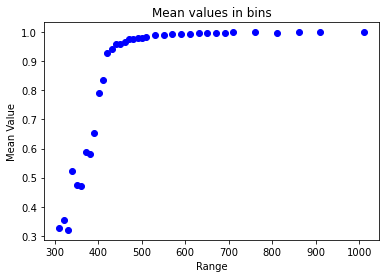

[       nan        nan        nan 0.19069734 0.19658452 0.17293716
 0.34291428 0.31118058 0.29808067 0.41926623 0.39113963 0.47225067
 0.59352863 0.66644191 0.82027512 0.8477886  0.89172444 0.90319373
 0.9070916  0.93545742 0.94033952 0.92790029 0.94172742 0.954267
 0.95768958 0.95356025 0.96352597 0.96426286 0.97143699 0.97404021
 0.9875403  0.9894561  0.98032663 0.99217306 0.99266761 0.99592524
 0.99721533 0.90031493 0.60260789]


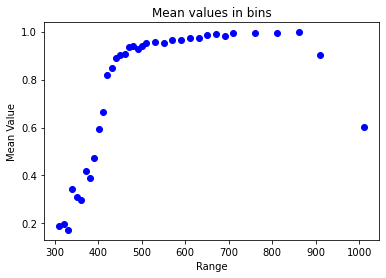

[0.67642915 0.10742897        nan        nan 0.62571905 0.39565595
 0.31796485 0.3899434  0.36205271 0.54904102 0.50591442 0.46746345
 0.58841396 0.62504318 0.65745578 0.64185687 0.7812204  0.82658474
 0.81368901 0.86944053 0.87965664 0.91226313 0.92111899 0.92775637
 0.94639615 0.95687035 0.96864556 0.96926513 0.97552064 0.97398167
 0.97801962 0.98956031 0.98131865 0.98663022 0.99440932 0.9941454
 0.99742886 0.99548481 0.99686134 0.99581789 0.99614195 0.99244543
 0.97877842 0.99866709 0.99825365 0.98908537 0.93007666 0.99871267
 0.99879867]


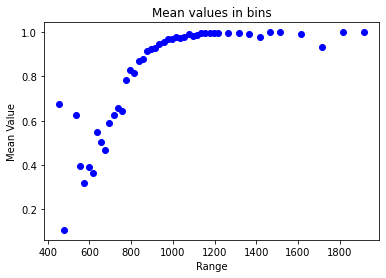

[0.81880559 0.17604505        nan        nan 0.73891037 0.47144477
 0.41377085 0.48574441 0.44222917 0.6198416  0.59038038 0.54287809
 0.65860861 0.69430796 0.72820553 0.71403158 0.83760209 0.88650821
 0.86499117 0.9127964  0.9222311  0.94849736 0.95634244 0.9609915
 0.97008632 0.97686592 0.98446919 0.98716278 0.98765091 0.98752885
 0.99206294 0.99586736 0.99645639 0.99844315 0.99885153 0.99778971
 0.99925493 0.99893299 0.99883255 0.9990144  0.99925461 0.99914912
 0.99950123 0.99933204 0.99917267 0.99943893 0.99988391 0.99957205
 0.99930363]


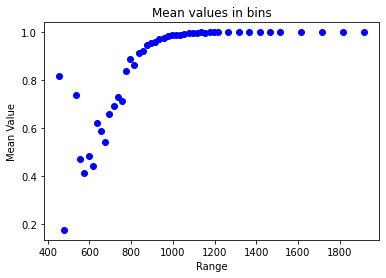

[0.5340527  0.03881289        nan        nan 0.51252773 0.31986714
 0.23959521 0.2941424  0.28310716 0.47824044 0.42305986 0.39204882
 0.51730365 0.55327109 0.58586089 0.56948078 0.72459405 0.76344039
 0.76190231 0.82399906 0.83076376 0.87356133 0.88411971 0.89216822
 0.92013253 0.93509426 0.95247723 0.9464165  0.96237301 0.95695166
 0.96138946 0.98230258 0.94049653 0.96289855 0.98458067 0.98986054
 0.99528854 0.99203662 0.99460369 0.98809891 0.98732521 0.97457208
 0.95120602 0.99800213 0.99727609 0.96095544 0.83793983 0.99753421
 0.99829371]


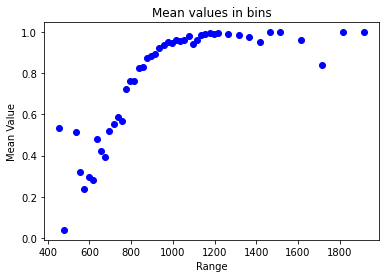

[0.72307867 0.72354439 0.73656701 0.72752854 0.71590538 0.74711134
 0.74676223 0.75580166 0.72867874 0.80419264 0.80459936 0.86850754
 0.86878404 0.88691847 0.88184039 0.91448598 0.93331822 0.93672845
 0.94358483 0.94741789 0.94129519 0.96558494 0.96150766 0.96953802
 0.97703745 0.98039088 0.9697703  0.97526371 0.95858184 0.98485022
 0.98316581 0.97684545 0.98341849 0.99633003 0.97225627 0.99326549
 0.99410395]


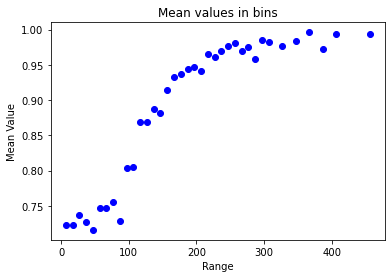

[0.75928385 0.75758701 0.77277483 0.7586912  0.75942093 0.78865256
 0.79058348 0.79731232 0.7786614  0.84745683 0.8556853  0.91420033
 0.92132817 0.93685348 0.93064327 0.95010013 0.9654677  0.96903053
 0.98163602 0.98212958 0.98475931 0.99341002 0.99126298 0.99339291
 0.99456022 0.99430372 0.9900151  0.99012136 0.97914398 0.99524166
 0.99233629 0.98818717 0.99664423 0.99840851 0.99123439 0.99819455
 0.99769874]


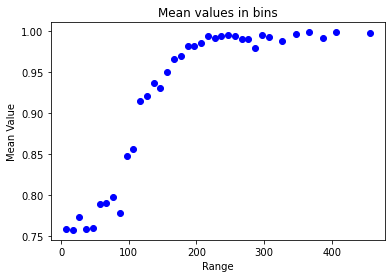

[0.68686931 0.68898683 0.7007835  0.69289669 0.67064824 0.70296716
 0.70200526 0.71226261 0.67612085 0.75936258 0.75188103 0.8219174
 0.8153452  0.83424295 0.83303273 0.87699146 0.89796652 0.90442638
 0.89810548 0.91198146 0.88880649 0.92800894 0.92350891 0.93897807
 0.95581814 0.96599872 0.94876802 0.9596608  0.93594804 0.96980052
 0.9733009  0.96447688 0.96940209 0.99403791 0.94972797 0.9870261
 0.99050916]


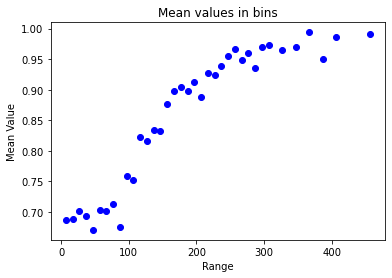

[0.42733542 0.50943359 0.67286846 0.74802922 0.85714769 0.89922825
 0.930566   0.95598206 0.95869438 0.96468811 0.96115025 0.97301496
 0.98794103 0.9912313  0.99177077 0.9563107  0.99318694 0.99638573
 0.99720858 0.99836651 0.99862375 0.9965273  0.9982624  0.99802181
 0.99890517]


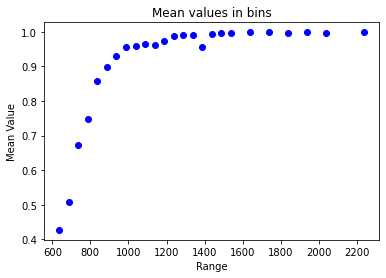

[0.5051636  0.59430405 0.74619263 0.8055754  0.89742979 0.93090949
 0.95609806 0.97448879 0.97453202 0.97868882 0.97769373 0.98867921
 0.99594387 0.99689507 0.99732733 0.99782349 0.99652376 0.99854516
 0.9987709  0.99962596 0.99945301 0.99899742 0.99975285 1.
 0.99970744]


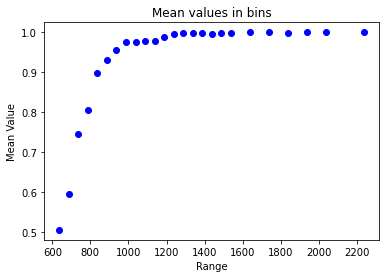

[0.35085596 0.42547294 0.59763501 0.68958489 0.81451601 0.86552785
 0.90166085 0.93540477 0.93787604 0.94659203 0.93643639 0.95070873
 0.97105493 0.98172833 0.97734897 0.90176664 0.98974632 0.99388117
 0.99535757 0.99687888 0.99761419 0.99405717 0.99642227 0.99520694
 0.99767747]


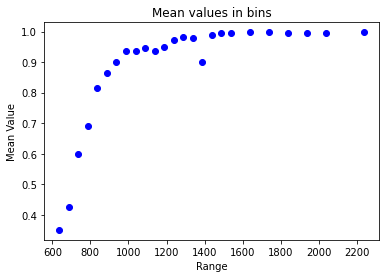

[0.67544792 0.75626942 0.73122523 0.75219233 0.8294596  0.72557895
 0.74172223 0.74580828 0.78953418 0.83936725 0.90390919 0.90736838
 0.93080283 0.90419507 0.97572166 0.94646765 0.99209318 0.99849919
 0.95762079 0.98488411]


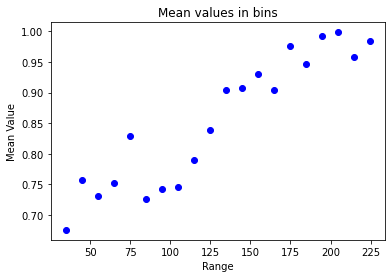

[0.75417128 0.81591447 0.7986892  0.81645829 0.86497687 0.78122906
 0.78502971 0.79179011 0.82945366 0.87766842 0.93080402 0.93750236
 0.96012455 0.94281772 0.99243514 0.98970457 0.9974579  0.99926906
 0.99279864 1.        ]


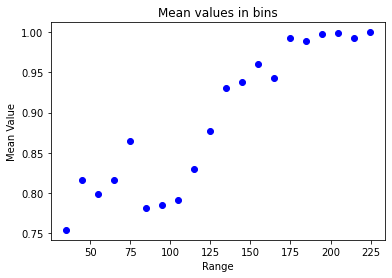

[0.59631686 0.69330115 0.66066941 0.68413804 0.79379384 0.66774988
 0.697366   0.70035608 0.74606199 0.79692296 0.87527292 0.87519674
 0.89813219 0.86552339 0.95123838 0.89284998 0.98672846 0.99772932
 0.92244295 0.9568951 ]


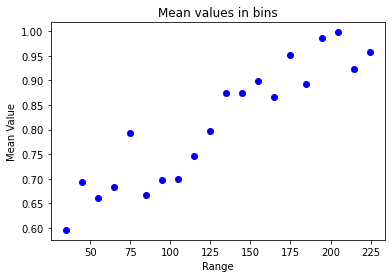

[       nan        nan        nan        nan        nan 0.76422062
 0.74861451 0.7278724  0.69943967 0.67618066 0.73149235 0.74172073
 0.79011947 0.75814834 0.80100558 0.84215389 0.87511713 0.86229096
 0.92626406 0.93788809 0.95397234 0.9615227  0.97615141 0.9688034
 0.98242174 0.9864522  0.98407659 0.99094844 0.98513038 0.99317773
 0.99367288 0.99837902 0.99863784 0.99878313 0.99912091 0.99914942
 0.99875363 0.99861803 0.99876694 0.99865117 0.99907383 0.99894991
 0.99734054 0.99855507]


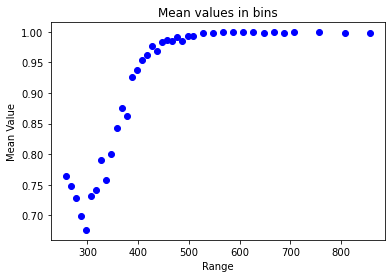

[       nan        nan        nan        nan        nan 0.82850291
 0.8039377  0.7886941  0.76397694 0.73442612 0.78540455 0.79794159
 0.83298374 0.8117282  0.84535247 0.88121689 0.91149961 0.90246784
 0.9541952  0.96225818 0.97288356 0.98055942 0.98839193 0.9907643
 0.98987061 0.99356369 0.99405593 0.99606687 0.99815751 0.99892197
 0.99883436 0.99927478 0.99943987 0.99930199 0.99960309 0.99951659
 0.9994449  0.99962903 0.99958206 0.99971452 0.99950869 0.99961352
 1.         0.9996634 ]


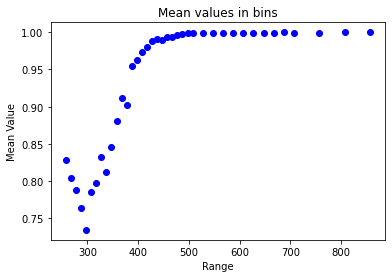

[       nan        nan        nan        nan        nan 0.70038667
 0.69306763 0.66521015 0.63509203 0.61699843 0.67719449 0.68126998
 0.74530091 0.70362709 0.75450507 0.80141769 0.8321772  0.81820494
 0.893524   0.91235567 0.9322992  0.93722322 0.959558   0.94023652
 0.97497288 0.9792284  0.96078432 0.98512136 0.94739682 0.97720789
 0.97910381 0.99748325 0.99771034 0.99826427 0.99862882 0.99878225
 0.99789799 0.99715993 0.99774225 0.9973945  0.99863898 0.99819732
 0.99363205 0.99716784]


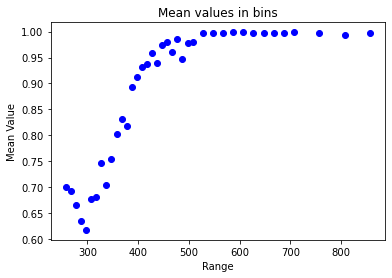

[0.76187606 0.78555002 0.8514836  0.87639359 0.86500872 0.85080328
 0.78295544 0.8292236  0.82430828 0.8669418  0.90724509 0.95893134
 0.88815831 0.9993966  0.98644125 0.99137138 0.99121343 0.99465209
 0.99327522        nan]


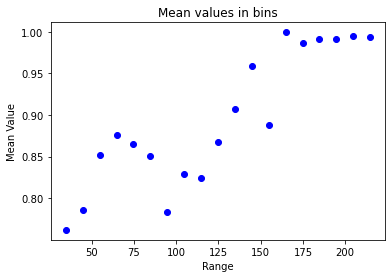

[0.81250296 0.8309925  0.89526507 0.91531062 0.90188948 0.89134721
 0.82644666 0.86924568 0.86105579 0.89795068 0.93179404 0.97461268
 0.90740022 0.99961599 0.99389117 0.9946191  0.99487109 0.99806654
 0.995082          nan]


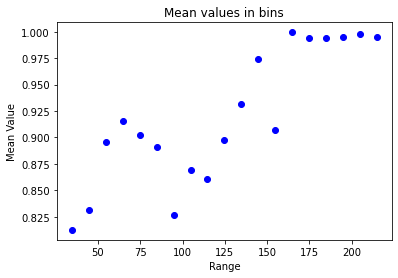

[0.70884164 0.73764665 0.80366111 0.83350776 0.8269806  0.807807
 0.73863789 0.78533357 0.78557699 0.83157678 0.88046082 0.93530395
 0.86737423 0.99917721 0.97652423 0.98812367 0.98755578 0.99012338
 0.99146844        nan]


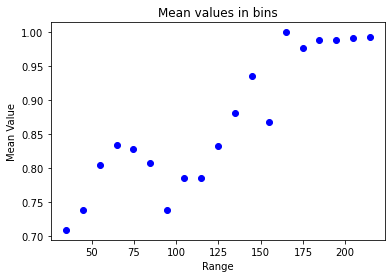

[       nan        nan        nan        nan        nan 0.63087411
 0.15677336 0.37658488 0.34663209 0.40695574 0.46358351 0.63922526
 0.67955194 0.64987581 0.73875657 0.8164817  0.86690286 0.89134492
 0.92490755 0.94778732 0.95552255 0.95780743 0.94512487 0.95682807
 0.95541798 0.97711277 0.97285469 0.97582714 0.98585902 0.99053598
 0.9895061  0.98937571 0.99219338 0.99174786 0.98985631 0.99668091
 0.99708439 0.99791876 0.99637435 0.9977323  0.99785936 0.98889563
 0.99862654 0.91528311 0.98940735 0.97214233 0.99844728 0.99870343
 0.99858374]


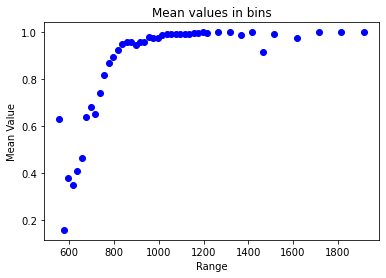

[       nan        nan        nan        nan        nan 0.7746404
 0.23114808 0.46350781 0.42793725 0.49000762 0.55676714 0.72053093
 0.76170585 0.72058113 0.80341901 0.8702789  0.91574629 0.92949528
 0.95672072 0.97284612 0.97595644 0.97996277 0.97241267 0.97570039
 0.97856873 0.99138451 0.9902247  0.99020668 0.99545083 0.99662201
 0.99653719 0.99506415 0.99846529 0.99858269 0.99942441 0.99877488
 0.99913384 0.99904485 0.99912404 0.9990305  0.9990928  0.99942151
 0.99935293 0.99955819 0.99953141 0.99947119 0.99971536 0.99931904
 0.99971994]


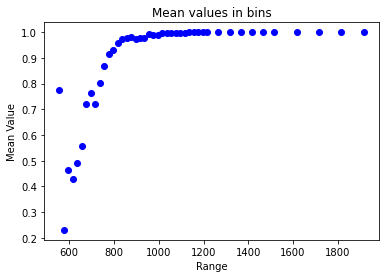

[       nan        nan        nan        nan        nan 0.48710782
 0.0929357  0.29220299 0.26794688 0.32390387 0.3698832  0.55776569
 0.5951932  0.577359   0.67243395 0.76261717 0.81625133 0.85206279
 0.89285123 0.91826691 0.93401002 0.92890592 0.91422966 0.9378249
 0.92955985 0.95972541 0.94642751 0.95593807 0.97017313 0.98353052
 0.97529482 0.98336332 0.98022366 0.97704777 0.9645146  0.994203
 0.99476048 0.99678656 0.99027244 0.99622425 0.99658817 0.95657912
 0.99780437 0.80263316 0.96164592 0.93621428 0.99664646 0.99808781
 0.99718528]


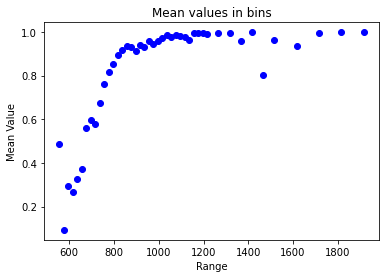

[0.07185624 0.21021475 0.40604748 0.62804828 0.80118852 0.90503784
 0.94965858 0.96625507 0.96024724 0.97628388 0.97964526 0.98110974
 0.98635843 0.9886869  0.99250669 0.99535726 0.99439663 0.99601411
 0.99069616 0.99810266 0.99822826 0.94720864 0.99839803 0.88659098
 0.88460983 0.99734054 0.99956256]


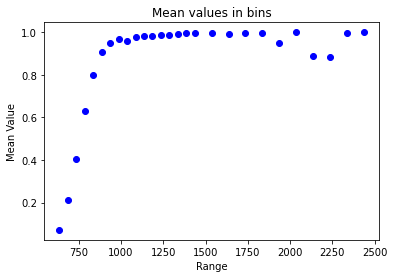

[0.12762781 0.28417908 0.50560256 0.71367155 0.86501741 0.94653176
 0.97583024 0.98340147 0.97936161 0.99129643 0.99352261 0.99377004
 0.99564766 0.99664792 0.99717417 0.99855445 0.99906144 0.99913091
 0.99903628 0.99908303 0.99921569 1.         0.99961389 0.99968781
 1.         1.         0.99969268]


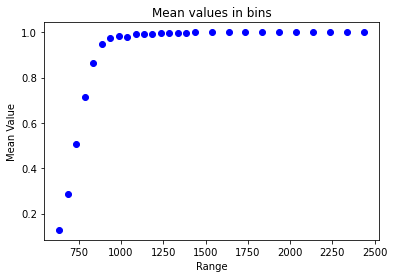

[0.029597   0.13755356 0.30638546 0.54184461 0.73610393 0.86163332
 0.9198449  0.94677633 0.93754145 0.95668395 0.96097774 0.96495587
 0.97068717 0.97777507 0.98766775 0.99181303 0.98494185 0.99119657
 0.96908157 0.9971223  0.99715185 0.77446295 0.99654401 0.73519852
 0.7325695  0.99363205 0.99943244]


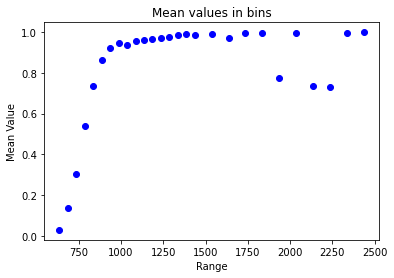

[0.28182923 0.11599797 0.23275916 0.39304989 0.55634811 0.72178885
 0.83779815 0.90064631 0.93037044 0.91840372 0.94356683 0.93683024
 0.96123243 0.97426768 0.98191456 0.98204691 0.98660132 0.98740331
 0.992528   0.9930505  0.99441315 0.99708258 0.99723168 0.94420295
 0.92997549]


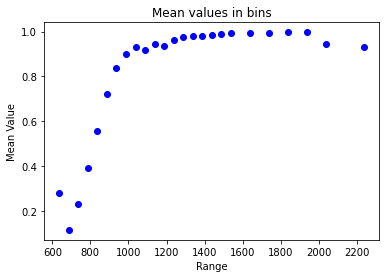

[0.403355   0.16682865 0.3087507  0.48033805 0.6344737  0.78657359
 0.88836162 0.94015965 0.95948751 0.94970416 0.96814876 0.96736983
 0.98402814 0.98977644 0.9934322  0.99405234 0.99513902 0.99636628
 0.99755182 0.99704773 0.999002   0.99887325 0.9985651  0.99952417
 0.99988593]


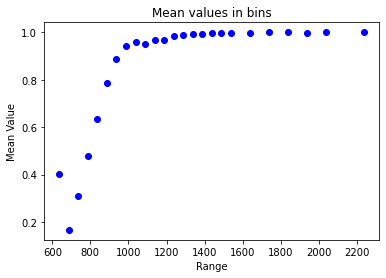

[0.20243709 0.06712228 0.15907772 0.30575818 0.47650893 0.65633818
 0.78562095 0.8588233  0.89888197 0.8853698  0.91540391 0.9041904
 0.93144563 0.95491299 0.96324561 0.96875333 0.97629615 0.97410667
 0.98413652 0.98872052 0.98709414 0.99504319 0.99584397 0.82823608
 0.83779748]


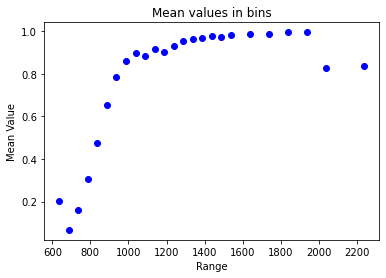

[0.78348137 0.8195417  0.85418127 0.82395934 0.8465756  0.77565688]


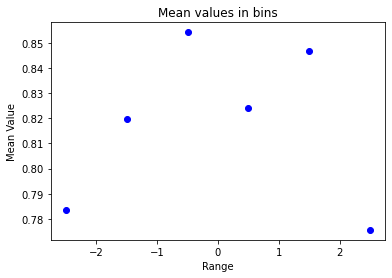

[0.86289667 0.86482526 0.88930716 0.86176157 0.88754221 0.85480923]


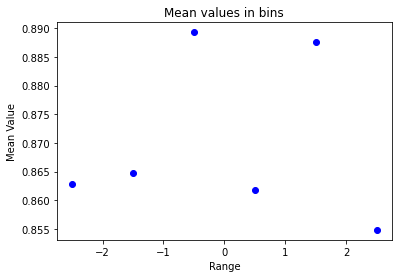

[0.69884715 0.77228815 0.81642728 0.78315243 0.8037665  0.69632723]


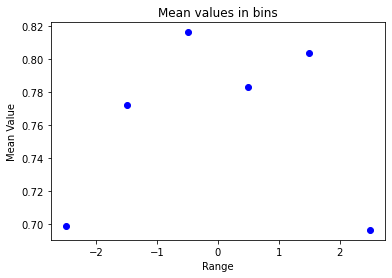

[0.80948831 0.8130969  0.85513054 0.83767676 0.81284299 0.68117674]


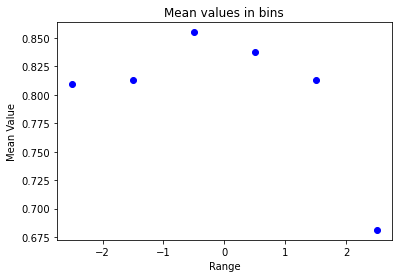

[0.88284204 0.85839479 0.89142597 0.87455076 0.85527973 0.73400747]


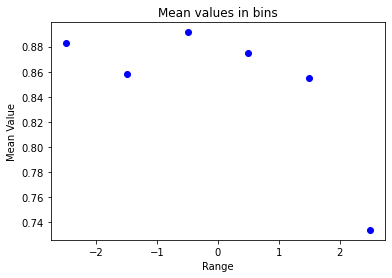

[0.73313912 0.76530496 0.81550269 0.79864535 0.76851707 0.62834601]


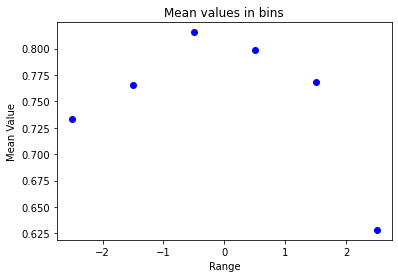

[0.83679074 0.84837793 0.81372618 0.80224147 0.87716866 0.84170098]


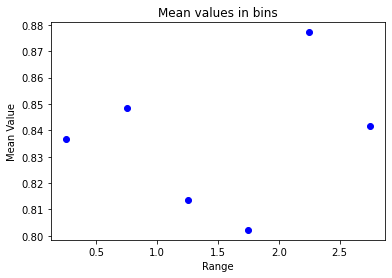

[0.87526761 0.88640984 0.85197186 0.85810602 0.90327959 0.90733386]


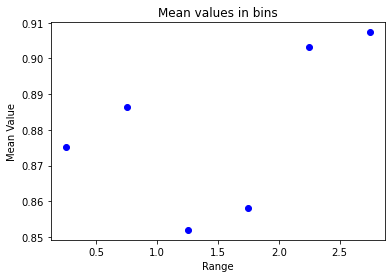

[0.7962191  0.80756162 0.7715869  0.74200887 0.85105772 0.77606809]


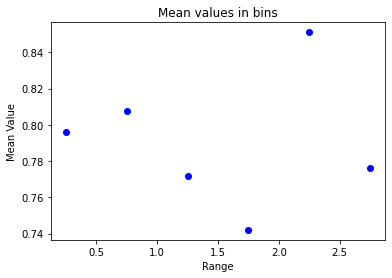

[0.99232834 0.83993889 0.87697834        nan 0.89550424        nan
        nan 0.84346129 0.82043715 0.99842048]


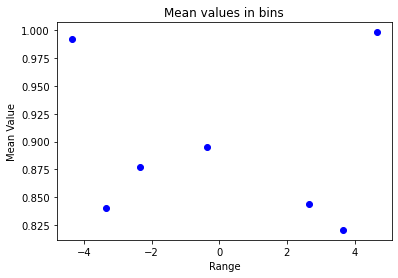

[0.99997268 0.87953316 0.91157702        nan 1.                nan
        nan 0.88025252 0.85997588 0.99979797]


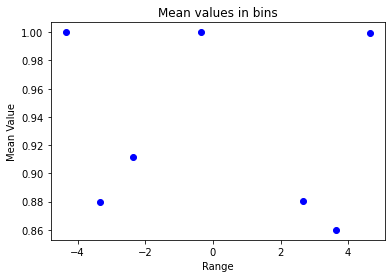

[0.97826824 0.79724932 0.84055774        nan 0.59699728        nan
        nan 0.80588102 0.77845601 0.99704298]


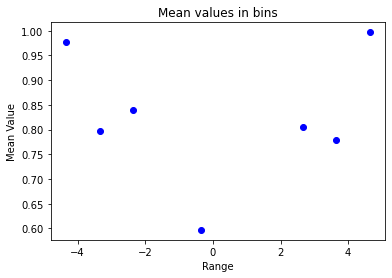

In [220]:
if sample == "ggF":
    
    pddf,features= RD_to_pandas(df_ggF, filter_all_meas, names_list_and_signal_trigger, names_list)


    y = pddf[signal_trigger].astype('bool')
    y = y*1
    y = y.astype(int).values
    
    X = features.values 
    
    # Get the gradient boosting predicted efficiencies and uncertainties
    mean_list_ggF, mean_plus_list_ggF, mean_minus_list_ggF = mean_and_standard_deviation(models, X, y, num_bins_list, range_min_list, range_max_list)

In [44]:
pddf,features= RD_to_pandas(df_ggF, filter_all_meas, names_list_and_signal_trigger, names_list)


y = pddf[signal_trigger].astype('bool')
y = y*1
y1 = y.astype(int).values
    
X1 = features.values 

In [46]:
auc_scores = []
test_accuracies = []

n_samples = 20

for i in range(n_samples):
    test_predictions = models[i].predict(X1)
    test_accuracy = accuracy_score(y1, test_predictions)
    test_accuracies.append(test_accuracy)

    # Calculate AUC-ROC score for each model
    y_scores = models[i].predict_proba(X1)[:, 1]  # Probability of positive class
    auc_score = roc_auc_score(y1, y_scores)
    auc_scores.append(auc_score)

    print(f"Model {i + 1} - Test Accuracy: {test_accuracy:.4f} - AUC-ROC Score: {auc_score:.4f}")

avg_test_accuracy = np.mean(test_accuracies)
avg_auc_score_ggF = np.mean(auc_scores)
print(f"\nAverage Test Accuracy across all models: {avg_test_accuracy:.4f}")
print(f"Average AUC-ROC Score across all models: {avg_auc_score_ggF:.4f}")

Model 1 - Test Accuracy: 0.8751 - AUC-ROC Score: 0.9109
Model 2 - Test Accuracy: 0.8798 - AUC-ROC Score: 0.9140
Model 3 - Test Accuracy: 0.8798 - AUC-ROC Score: 0.9242
Model 4 - Test Accuracy: 0.8851 - AUC-ROC Score: 0.9154
Model 5 - Test Accuracy: 0.8878 - AUC-ROC Score: 0.9269
Model 6 - Test Accuracy: 0.8782 - AUC-ROC Score: 0.9214
Model 7 - Test Accuracy: 0.8798 - AUC-ROC Score: 0.9177
Model 8 - Test Accuracy: 0.8825 - AUC-ROC Score: 0.9182
Model 9 - Test Accuracy: 0.8745 - AUC-ROC Score: 0.9176
Model 10 - Test Accuracy: 0.8867 - AUC-ROC Score: 0.9213
Model 11 - Test Accuracy: 0.8788 - AUC-ROC Score: 0.9186
Model 12 - Test Accuracy: 0.8841 - AUC-ROC Score: 0.9181
Model 13 - Test Accuracy: 0.8862 - AUC-ROC Score: 0.9249
Model 14 - Test Accuracy: 0.8841 - AUC-ROC Score: 0.9125
Model 15 - Test Accuracy: 0.8835 - AUC-ROC Score: 0.9215
Model 16 - Test Accuracy: 0.8819 - AUC-ROC Score: 0.9142
Model 17 - Test Accuracy: 0.8724 - AUC-ROC Score: 0.9127
Model 18 - Test Accuracy: 0.8925 - AUC-R

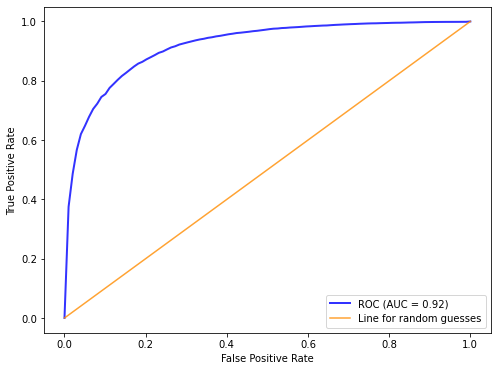

In [47]:
# Draw ROC curve for the ensemble
plt.figure(figsize=(8, 6))

# Calculate ROC curve for each model
mean_fpr_ggF = np.linspace(0, 1, 100)
tprs = []
for i in range(n_samples):
    y_scores = models[i].predict_proba(X1)[:, 1]
    fpr, tpr, _ = roc_curve(y1, y_scores)
    interp_tpr = np.interp(mean_fpr_ggF, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

# Calculate mean and standard deviation of ROC curve
mean_tpr_ggF = np.mean(tprs, axis=0)
mean_tpr_ggF[-1] = 1.0
std_tpr_ggF = np.std(tprs, axis=0)

plt.plot(mean_fpr_ggF, mean_tpr_ggF, color='b', label=f'ROC (AUC = {avg_auc_score_ggF:.2f})', lw=2, alpha=0.8)

# Plot the diagonal (random classifier)
plt.plot([0, 1], [0, 1], color='darkorange', alpha=0.8, label = 'Line for random guesses') 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#.title('ROC Curve for Ensemble of Models')
plt.legend(loc='lower right')
plt.show()

In [221]:

for j in range(0,len(num_bins_list)):    
    efficiency_plot_stds(eff_real_list_ggF[j],eff_meas_list_ggF[j], mean_list_ggF[j], mean_plus_list_ggF[j], mean_minus_list_ggF[j], None, "True efficiency","Measured efficiency", 
                         "GB mean efficiency","DNN efficiency","",y_min_list[j], y_max_list[j], range_min_list[j],range_max_list[j], names_list_plot[j],"STD_ggF_TEfficiency_"+names_list[j]+"_GB1_"+ run_name+".png","ggF")

Info in <TCanvas::Print>: png file STD_ggF_TEfficiency_HighestPt_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_ggF_TEfficiency_HT_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_ggF_TEfficiency_MET_pt_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_ggF_TEfficiency_mHH_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_ggF_TEfficiency_HighestMass_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_ggF_TEfficiency_SecondHighestPt_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_ggF_TEfficiency_SecondHighestMass_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_ggF_TEfficiency_FatHT_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_ggF_TEfficiency_MET_FatJet_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_ggF_TEfficiency_mHHwithMET_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_ggF

### VBF

Model 1 - Test Accuracy: 0.9681 - AUC-ROC Score: 0.9537
Model 2 - Test Accuracy: 0.9669 - AUC-ROC Score: 0.9586
Model 3 - Test Accuracy: 0.9683 - AUC-ROC Score: 0.9603
Model 4 - Test Accuracy: 0.9677 - AUC-ROC Score: 0.9520
Model 5 - Test Accuracy: 0.9675 - AUC-ROC Score: 0.9612
Model 6 - Test Accuracy: 0.9193 - AUC-ROC Score: 0.9091
Model 7 - Test Accuracy: 0.9655 - AUC-ROC Score: 0.9429
Model 8 - Test Accuracy: 0.9674 - AUC-ROC Score: 0.9533
Model 9 - Test Accuracy: 0.9273 - AUC-ROC Score: 0.9170
Model 10 - Test Accuracy: 0.9246 - AUC-ROC Score: 0.9182
Model 11 - Test Accuracy: 0.9513 - AUC-ROC Score: 0.9374
Model 12 - Test Accuracy: 0.9261 - AUC-ROC Score: 0.9127
Model 13 - Test Accuracy: 0.9645 - AUC-ROC Score: 0.9516
Model 14 - Test Accuracy: 0.9263 - AUC-ROC Score: 0.9103
Model 15 - Test Accuracy: 0.9633 - AUC-ROC Score: 0.9511
Model 16 - Test Accuracy: 0.9688 - AUC-ROC Score: 0.9608
Model 17 - Test Accuracy: 0.9650 - AUC-ROC Score: 0.9566
Model 18 - Test Accuracy: 0.9470 - AUC-R

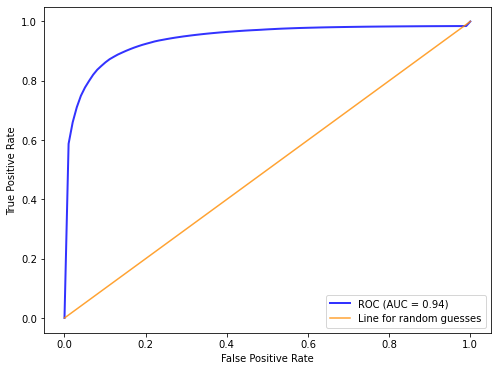

[       nan        nan        nan 0.40678362 0.44386578 0.4299232
 0.50927986 0.49023718 0.52713198 0.51953573 0.53100446 0.59335959
 0.69870337 0.78454516 0.85757053 0.9015656  0.91723109 0.93131268
 0.93988259 0.9460624  0.95457779 0.95762931 0.96223296 0.97012366
 0.97333512 0.9743261  0.97954685 0.98134359 0.98416089 0.9855788
 0.98843047 0.98970475 0.99165586 0.99288506 0.9934851  0.99232602
 0.98376719 0.96799124 0.94968632]


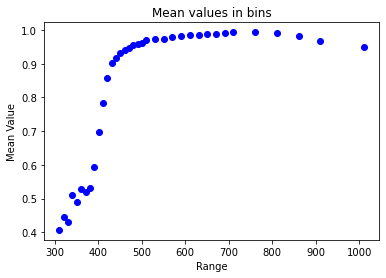

[       nan        nan        nan 0.47513269 0.51644645 0.50440234
 0.58271595 0.56829664 0.60370341 0.6033268  0.61799877 0.68443741
 0.78826151 0.86115249 0.91633174 0.94372636 0.95263863 0.96125248
 0.96749288 0.97062967 0.97591784 0.97775466 0.98070621 0.98528168
 0.98883563 0.99018751 0.99258562 0.99353868 0.99485873 0.99548214
 0.9964169  0.99701024 0.99790515 0.99846084 0.9987593  0.99890886
 0.99905473 0.99914855 0.99936812]


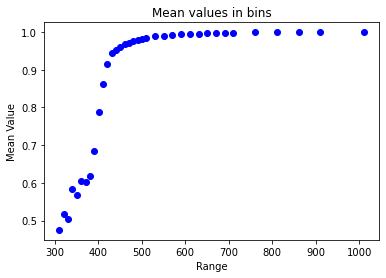

[       nan        nan        nan 0.33563078 0.36981894 0.35439512
 0.43478389 0.41141231 0.44959649 0.43421916 0.4429235  0.5010338
 0.608314   0.70750737 0.79711403 0.85772594 0.8808455  0.90003626
 0.90982011 0.92043166 0.93101576 0.93521242 0.94198497 0.95233277
 0.95347519 0.95483831 0.96240574 0.96491749 0.96933017 0.97209914
 0.97695801 0.97967708 0.98265233 0.98403091 0.9850202  0.98100558
 0.95976778 0.92222096 0.87790401]


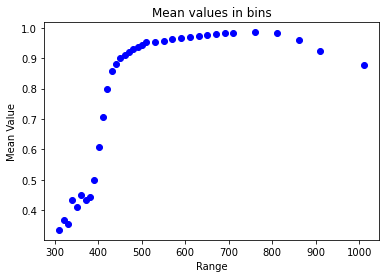

[0.69736019 0.74066784 0.60758717 0.54626392 0.55427965 0.5238207
 0.58937849 0.60146363 0.63861242 0.7194472  0.70258798 0.76897398
 0.81733009 0.86663345 0.88086061 0.90810909 0.92587096 0.92838796
 0.94016333 0.94462238 0.95190277 0.95980365 0.96816453 0.97410776
 0.97673698 0.97900705 0.98195836 0.98731405 0.98550507 0.98416316
 0.99031691 0.98777213 0.98779944 0.98679327 0.9860501  0.98231159
 0.98241733 0.97738643 0.96948594 0.96650528 0.96559219 0.95238759
 0.95056818 0.94243397 0.93601658]


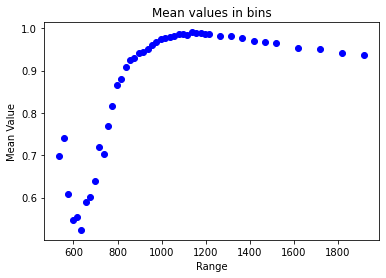

[0.78119018 0.80837079 0.67581333 0.6146775  0.62545238 0.59714233
 0.66739827 0.67369309 0.71038831 0.78367842 0.76722753 0.82622372
 0.87166757 0.91539918 0.92125539 0.94492618 0.95742968 0.96032798
 0.96898727 0.97206938 0.97762659 0.98084147 0.98618745 0.98885733
 0.99065128 0.99166974 0.99460198 0.99678712 0.99718822 0.99850688
 0.99854084 0.99843408 0.99864984 0.99880646 0.99881194 0.99893659
 0.99896277 0.99908277 0.99910634 0.99918815 0.99929293 0.99939021
 0.99943288 0.99948476 0.99948432]


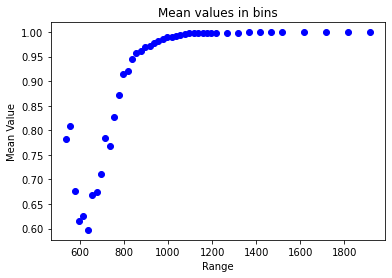

[0.6030959  0.67058196 0.53906102 0.4764178  0.48219783 0.45036037
 0.51065911 0.5286154  0.56644713 0.6544363  0.63676041 0.71020025
 0.76124396 0.81486443 0.8387075  0.86838217 0.89273739 0.89413952
 0.90949508 0.91460804 0.9237006  0.93627675 0.94826549 0.9564858
 0.95964921 0.96360765 0.96475524 0.97368663 0.96000507 0.95609779
 0.97806317 0.97156169 0.9713574  0.96815334 0.96614822 0.95804728
 0.95717406 0.9471148  0.92812802 0.92029786 0.91948047 0.88777601
 0.88391507 0.86705175 0.8529631 ]


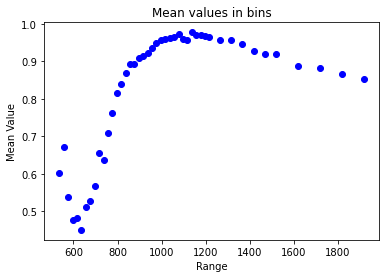

[0.91798107 0.89942444 0.89922873 0.89729478 0.89960475 0.89670787
 0.8967191  0.90902948 0.90542627 0.90851931 0.91597316 0.92703372
 0.93420047 0.94141339 0.94590977 0.95287497 0.95457257 0.9569823
 0.96136731 0.96781761 0.96573935 0.9650854  0.97652523 0.97865717
 0.98373061 0.98112758 0.98126738 0.98508617 0.98401533 0.98416136
 0.98432303 0.98597994 0.98519999 0.98595117 0.98836862 0.98902837
 0.99128507]


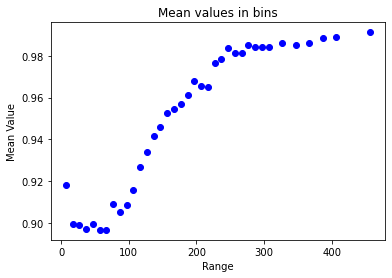

[0.93418421 0.91608743 0.91552224 0.91364577 0.91614017 0.91530311
 0.91575401 0.92774523 0.92707566 0.93208307 0.94125061 0.95243779
 0.95999105 0.96551949 0.96948849 0.97308593 0.97454659 0.97832518
 0.9881038  0.98795132 0.99196391 0.99414872 0.99372098 0.99331411
 0.99396293 0.99321447 0.99313471 0.99408294 0.99360849 0.9941398
 0.99394152 0.99442367 0.99464286 0.99491831 0.99612196 0.99663803
 0.99764046]


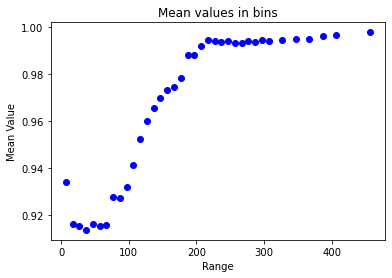

[0.90081251 0.88106807 0.88223801 0.8797106  0.8818958  0.87628831
 0.87621766 0.88873569 0.8828285  0.88363339 0.889741   0.90040778
 0.90689675 0.91637099 0.92094595 0.93161411 0.93323555 0.93446456
 0.92046407 0.94459678 0.93336494 0.91630241 0.95251973 0.96105341
 0.97228935 0.96713192 0.96763538 0.97484013 0.97355031 0.97175123
 0.97345655 0.97648539 0.9739218  0.97518486 0.97859033 0.97993353
 0.9824271 ]


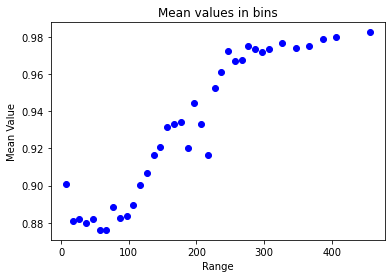

[0.57617644 0.60782299 0.636661   0.71909873 0.80291355 0.8673059
 0.90612996 0.93049517 0.9447848  0.95452773 0.95927343 0.96150712
 0.96579121 0.9654901  0.96109118 0.96799546 0.9689332  0.96670653
 0.9618742  0.96483447 0.9646698  0.96247296 0.96189867 0.95550056
 0.95731012 0.9512099  0.95907858 0.94267094 0.94113912]


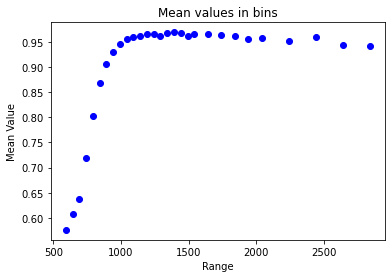

[0.65089909 0.68082881 0.70725337 0.78142012 0.85743053 0.90972846
 0.93891944 0.95795365 0.969279   0.97802043 0.9815545  0.98512674
 0.98704281 0.98888517 0.9887755  0.99026548 0.99272704 0.99194085
 0.99237461 0.99471412 0.99503795 0.99635903 0.99642867 0.9971972
 0.99701316 0.99896817 0.99872737 0.99734319 0.99945595]


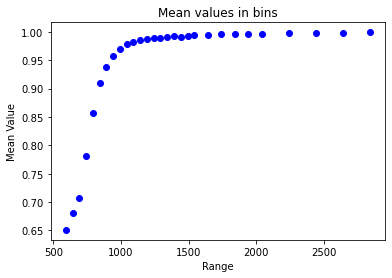

[0.50136587 0.53326459 0.56472367 0.65546346 0.74661951 0.82240564
 0.87099934 0.90069707 0.9162064  0.92459022 0.93058413 0.92959185
 0.93654735 0.93438689 0.92442938 0.93730469 0.93536545 0.93158746
 0.91938788 0.92499836 0.92323738 0.91488849 0.91662872 0.90036768
 0.90593983 0.88862184 0.90605431 0.86966567 0.86303661]


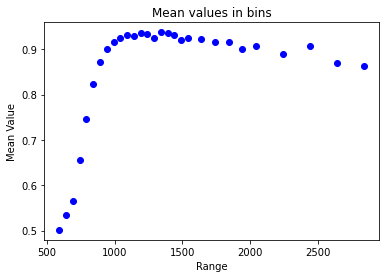

[       nan 0.85665143 0.87208715 0.86612918 0.88798679 0.89281482
 0.87878714 0.90095283 0.91853884 0.93154945 0.94941708 0.95486897
 0.95209462 0.93755813 0.90557064 0.90812032 0.87742018 0.89168085
 0.92938778 0.97944911 0.91101024 0.93491988 0.95950612 0.99839679
 0.98754291 0.885658   0.9984914  0.99782537]


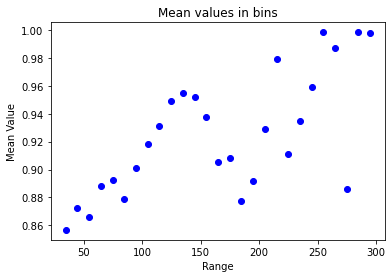

[       nan 0.89983664 0.91049829 0.90897177 0.92377887 0.9278069
 0.91711359 0.93037397 0.9439723  0.95541189 0.97338043 0.98373818
 0.99164877 0.99325773 0.99355593 0.99820328 0.99795209 0.99504803
 0.99779882 0.9990291  0.99959592 0.99872063 0.99957657 0.99937841
 0.99888479 0.99947115 0.99911341 0.99902779]


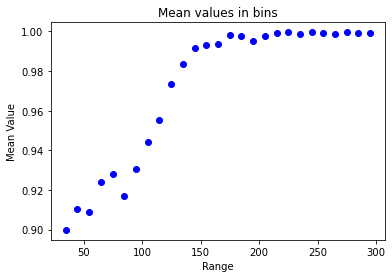

[       nan 0.81003294 0.83124113 0.81974403 0.84842122 0.85383694
 0.83609927 0.86753796 0.88956067 0.90329041 0.91943334 0.91734435
 0.89947543 0.86417711 0.78929356 0.79218088 0.72141034 0.75377488
 0.83944753 0.95583349 0.7955368  0.85395386 0.89258409 0.99741516
 0.94314157 0.73502871 0.99786939 0.99632035]


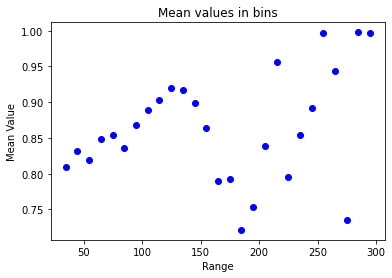

[       nan        nan        nan        nan        nan 0.87431044
 0.86669478 0.85246446 0.84669611 0.85425693 0.83520478 0.85746716
 0.86328516 0.87265248 0.87571834 0.89243596 0.90404518 0.91954698
 0.93374812 0.94590776 0.95776551 0.96493888 0.96903665 0.96720032
 0.97110972 0.97025242 0.97296788 0.98036075 0.97651173 0.97901351
 0.9826499  0.98456044 0.98250181 0.97559665 0.97627517 0.97730411
 0.98221199 0.97756604 0.976602   0.98206705 0.97571153 0.97626814
 0.97739853 0.97351265]


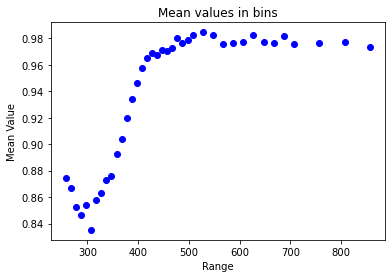

[       nan        nan        nan        nan        nan 0.92806017
 0.92135787 0.90856289 0.9002892  0.90777806 0.8861068  0.90473519
 0.9104022  0.91758727 0.91906033 0.93655148 0.94201884 0.95631157
 0.96846663 0.98018601 0.98618425 0.98823243 0.98940959 0.99261443
 0.99282782 0.99356889 0.99644858 0.99647944 0.99757616 0.99837436
 0.99887216 0.99911049 0.99923203 0.99928803 0.9992815  0.9993585
 0.99931642 0.99936216 0.999448   0.99938965 0.99942307 0.99949035
 0.99953475 0.99954818]


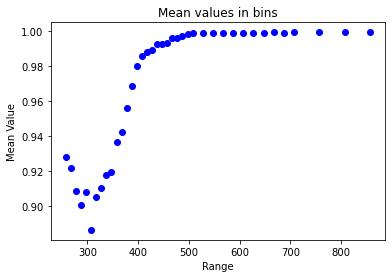

[       nan        nan        nan        nan        nan 0.81365871
 0.80471601 0.78852754 0.78516663 0.79249799 0.77812828 0.80269265
 0.80791205 0.82160444 0.8259645  0.84110082 0.86078032 0.875393
 0.89229829 0.90289991 0.9212741  0.93502291 0.94325351 0.93320968
 0.94059403 0.93891988 0.94183183 0.95684044 0.94549631 0.94919967
 0.95752675 0.96149514 0.9578657  0.94268583 0.94489944 0.94641128
 0.95877623 0.94832422 0.94397787 0.95932319 0.94358426 0.94576389
 0.94594788 0.93886399]


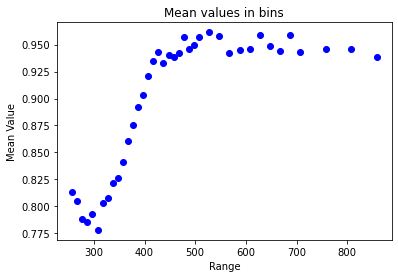

[       nan 0.87555749 0.88952293 0.91172048 0.92860967 0.94123422
 0.93651815 0.93749674 0.93537167 0.94814573 0.96267115 0.9802835
 0.98498083 0.98562976 0.98978263 0.9753347  0.99537871 0.97892985
 0.99397826 0.99952493 0.99830736 0.99854365 0.90496565 0.99913638
 0.99730722 0.99873052 0.99945067 0.99963155]


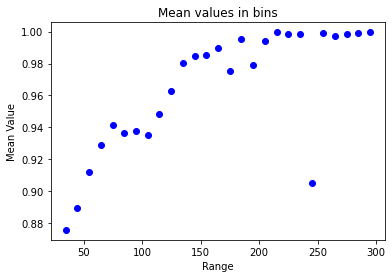

[       nan 0.94210471 0.96184274 0.97487444 0.97495686 0.9724361
 0.96286819 0.95922756 0.95450478 0.96153651 0.9741741  0.98756183
 0.99205077 0.98913177 0.99945677 0.99718481 0.99784334 0.99940526
 0.99985343 0.99973274 1.         1.         0.99980136 0.99959423
 1.         1.         0.99968312 0.99981472]


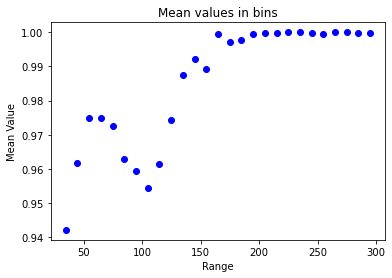

[       nan 0.79603638 0.79654476 0.83048378 0.87044621 0.90225631
 0.90483504 0.91211282 0.91123848 0.93265491 0.94768192 0.97132845
 0.97536333 0.98180146 0.96899089 0.9477783  0.99264374 0.95414524
 0.97263221 0.99931712 0.99637998 0.99587934 0.78755667 0.99867852
 0.99093674 0.99683878 0.99921822 0.99944838]


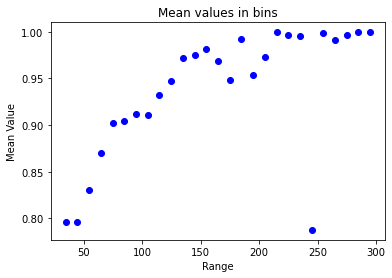

[       nan 0.62368477 0.48820095 0.42378383 0.50000143 0.51365457
 0.57317399 0.60516021 0.66376463 0.7358733  0.78746378 0.84588296
 0.87625185 0.91345891 0.93151007 0.9389624  0.95406907 0.95843353
 0.96159603 0.96125146 0.96413482 0.96814353 0.97482132 0.98031529
 0.98366943 0.98779141 0.98803296 0.98680716 0.99146311 0.98935704
 0.98846443 0.99059731 0.9883797  0.98696992 0.98225879 0.9798043
 0.97912019 0.97441461 0.97199469 0.96707589 0.96213099 0.95272713
 0.95224627 0.94189612 0.93768587]


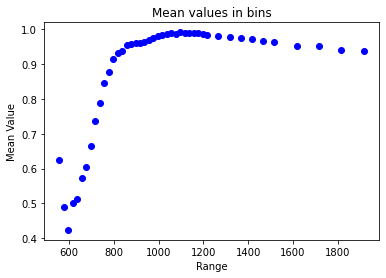

[       nan 0.69368569 0.56525089 0.49255964 0.57442349 0.5917406
 0.65531485 0.68739874 0.74142967 0.80452697 0.8504549  0.89642179
 0.92032832 0.9499488  0.96273003 0.96730209 0.97619103 0.97967348
 0.98223423 0.98235034 0.98442179 0.9866401  0.98986369 0.9936317
 0.99539029 0.9964177  0.9968769  0.99773724 0.99800445 0.99833038
 0.9985982  0.99865833 0.99883486 0.99884453 0.99879564 0.99894257
 0.99899877 0.99913085 0.99914697 0.99918923 0.99932179 0.99938861
 0.99946476 0.99947379 0.99949724]


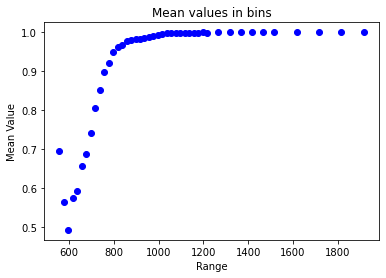

[       nan 0.55368384 0.40994975 0.35500802 0.4241896  0.43444167
 0.49043589 0.52235674 0.5850967  0.66631191 0.72377532 0.79400689
 0.8305154  0.87444831 0.89767892 0.90721721 0.93021247 0.93426211
 0.93833724 0.93770298 0.94128968 0.94672434 0.9571664  0.9623081
 0.96627445 0.97552464 0.97357737 0.9689893  0.97989099 0.97253762
 0.97101284 0.97736246 0.97089414 0.96813001 0.9581356  0.95084894
 0.95110517 0.93900675 0.93295968 0.92198589 0.91109579 0.88848644
 0.88830211 0.86498622 0.85624183]


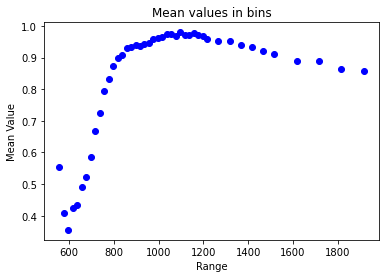

[       nan 0.1349289  0.07704961 0.2146985  0.39512693 0.66363615
 0.80843765 0.90378462 0.93671326 0.95925991 0.96774344 0.97328979
 0.97694195 0.98069928 0.98435477 0.98666152 0.98933449 0.99096009
 0.99302187 0.99464505 0.99477429 0.99094623 0.96963583 0.96132602
 0.95336954 0.93238119 0.92487843 0.91390731 0.89876768]


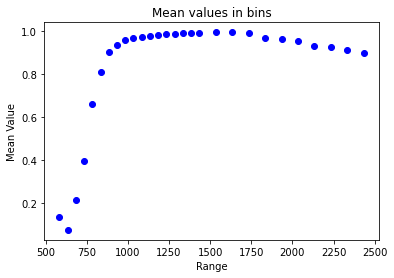

[       nan 0.20253309 0.11249086 0.28362132 0.48485666 0.74289124
 0.87295741 0.94536604 0.96520418 0.97912681 0.98579539 0.9893438
 0.99211797 0.99345139 0.99459292 0.99527298 0.99636643 0.99775147
 0.99836908 0.99867854 0.99889344 0.99898817 0.99911243 0.99921381
 0.99936451 0.99940857 0.99948924 0.99957818 0.99961971]


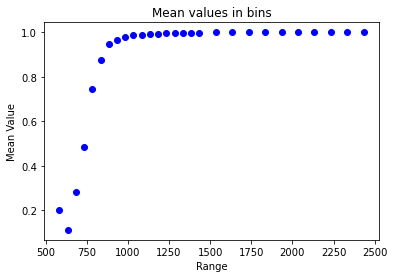

[       nan 0.0673247  0.04179672 0.14583836 0.30532855 0.58401566
 0.74323035 0.8606733  0.90655015 0.93711414 0.94570385 0.95397834
 0.95773786 0.96374904 0.97049873 0.97495813 0.97903557 0.98111835
 0.98496751 0.98771998 0.98748037 0.97645853 0.92515454 0.90680134
 0.88618792 0.83726181 0.82132034 0.79425689 0.75883696]


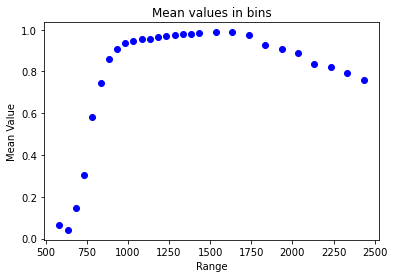

[       nan 0.2923335  0.22674273 0.28064364 0.43079063 0.59983584
 0.74147809 0.8330846  0.87686703 0.90495912 0.92881447 0.94546146
 0.94932655 0.95764102 0.96671489 0.9682393  0.97205694 0.97791801
 0.9798827  0.98307937 0.9867494  0.9873623  0.98710339 0.97594552
 0.96724147 0.94999377 0.93050505 0.90781101 0.89186235]


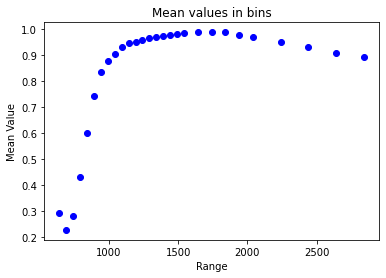

[       nan 0.35868725 0.29696619 0.34838683 0.50549993 0.67635712
 0.8042545  0.88212752 0.91766536 0.93767621 0.95715871 0.9697907
 0.97120815 0.97847324 0.98352625 0.98352899 0.98535413 0.98994613
 0.99073481 0.99197713 0.99440298 0.99461558 0.99665893 0.99647998
 0.99797706 0.99773301 0.99898455 0.99864938 0.9990643 ]


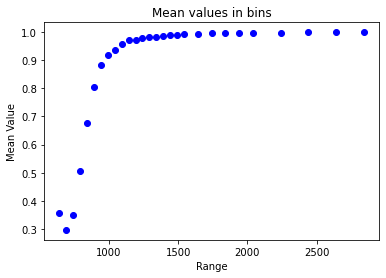

[       nan 0.22597975 0.15680836 0.21254927 0.35607513 0.52277968
 0.67827921 0.78266625 0.83467269 0.86998938 0.89811292 0.91865005
 0.92448242 0.93222643 0.94693113 0.95013876 0.95539794 0.96312442
 0.96561531 0.97099238 0.97636255 0.97672263 0.97043853 0.9465407
 0.92201117 0.88244955 0.83323943 0.78787796 0.75664729]


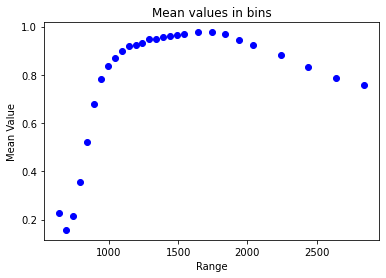

[0.87516904 0.92302936 0.93797589 0.93545553 0.92411824 0.89405584]


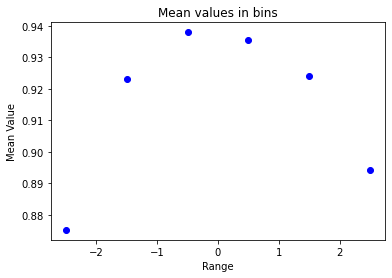

[0.9152463  0.95096835 0.97138983 0.96926704 0.95167512 0.92608165]


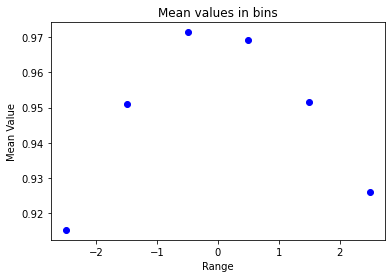

[0.82994084 0.89062831 0.89559379 0.8931052  0.8918322  0.85897728]


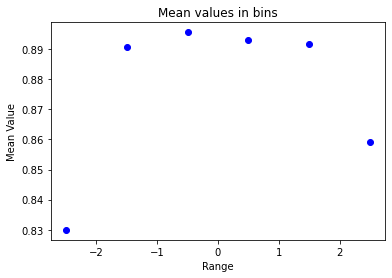

[0.8979711  0.92762083 0.93462817 0.93562803 0.92988552 0.90901948]


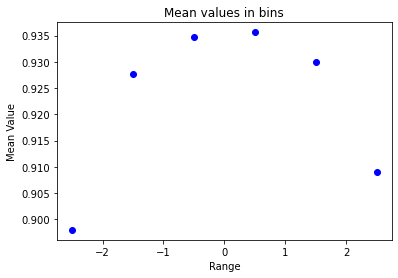

[0.93026909 0.95455729 0.96886058 0.96950992 0.95625428 0.93851716]


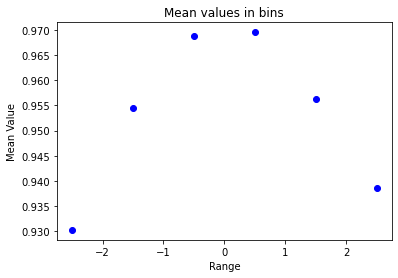

[0.86168311 0.89585904 0.89131946 0.89336649 0.89853902 0.87747238]


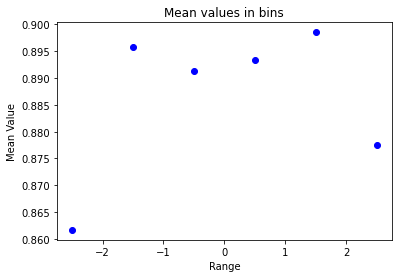

[0.93549452 0.93431941 0.93225119 0.93266847 0.93203007 0.90520678
 0.88686992 0.82746855 0.81970203]


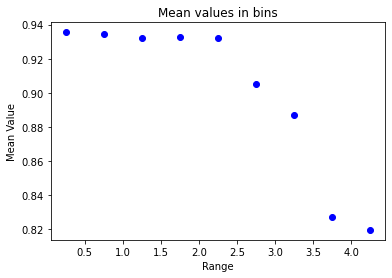

[0.9713601  0.96717918 0.96265574 0.95897165 0.95608444 0.93308284
 0.91457965 0.87248453 0.88440636]


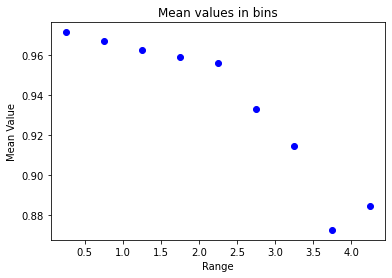

[0.88993222 0.89337853 0.8949578  0.90170845 0.90413636 0.87457653
 0.85591206 0.78233423 0.75484531]


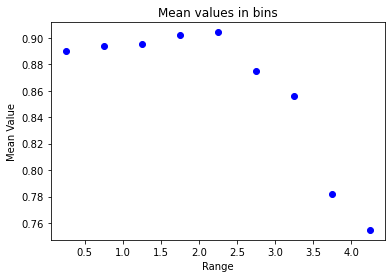

[0.93823745 0.93588254 0.92696027 0.99618586        nan 0.62808196
 0.99730387 0.92357429 0.93357473 0.99438277]


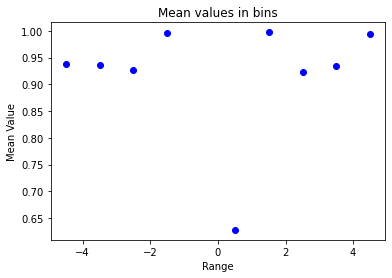

[0.9928019  0.96957839 0.95234062 0.99838959        nan 1.
 0.9992205  0.95050336 0.96680816 0.9994588 ]


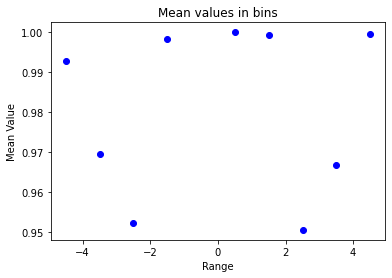

[0.87448818 0.89395735 0.89750383 0.99397869        nan 0.16937851
 0.99501878 0.89170033 0.89178222 0.98879933]


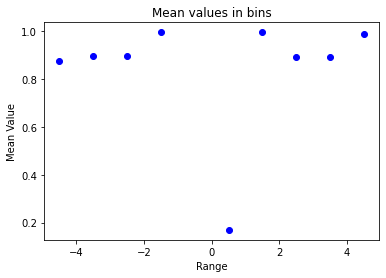

In [224]:
if sample == "VBF":
    
    pddf,features= RD_to_pandas(df_VBF, filter_all_meas, names_list_and_signal_trigger, names_list)


    y = pddf[signal_trigger].astype('bool')
    y = y*1
    y = y.astype(int).values
    
    X = features.values 
    
    # Get the gradient boosting predicted efficiencies and uncertainties
    mean_list_VBF, mean_plus_list_VBF, mean_minus_list_VBF = mean_and_standard_deviation(models, X, y, num_bins_list, range_min_list, range_max_list)

In [48]:
# Evaluate the model
pddf2,features2= RD_to_pandas(df_VBF, filter_all_meas, names_list_and_signal_trigger,names_list)


y2 = pddf2["Combo"].astype('bool')
y2 = y2*1
y2 = y2.astype(int).values
    
X2 = features2.values

auc_scores = []
test_accuracies = []

for i in range(n_samples):
    test_predictions = models[i].predict(X2)
    test_accuracy = accuracy_score(y2, test_predictions)
    test_accuracies.append(test_accuracy)

    # Calculate AUC-ROC score for each model
    y_scores = models[i].predict_proba(X2)[:, 1]  # Probability of positive class
    auc_score = roc_auc_score(y2, y_scores)
    auc_scores.append(auc_score)

    print(f"Model {i + 1} - Test Accuracy: {test_accuracy:.4f} - AUC-ROC Score: {auc_score:.4f}")

avg_test_accuracy = np.mean(test_accuracies)
avg_auc_score_VBF = np.mean(auc_scores)
print(f"\nAverage Test Accuracy across all models: {avg_test_accuracy:.4f}")
print(f"Average AUC-ROC Score across all models: {avg_auc_score_VBF:.4f}")

Model 1 - Test Accuracy: 0.9681 - AUC-ROC Score: 0.9537
Model 2 - Test Accuracy: 0.9669 - AUC-ROC Score: 0.9586
Model 3 - Test Accuracy: 0.9683 - AUC-ROC Score: 0.9603
Model 4 - Test Accuracy: 0.9677 - AUC-ROC Score: 0.9520
Model 5 - Test Accuracy: 0.9675 - AUC-ROC Score: 0.9612
Model 6 - Test Accuracy: 0.9193 - AUC-ROC Score: 0.9091
Model 7 - Test Accuracy: 0.9655 - AUC-ROC Score: 0.9429
Model 8 - Test Accuracy: 0.9674 - AUC-ROC Score: 0.9533
Model 9 - Test Accuracy: 0.9273 - AUC-ROC Score: 0.9170
Model 10 - Test Accuracy: 0.9246 - AUC-ROC Score: 0.9182
Model 11 - Test Accuracy: 0.9513 - AUC-ROC Score: 0.9374
Model 12 - Test Accuracy: 0.9261 - AUC-ROC Score: 0.9127
Model 13 - Test Accuracy: 0.9645 - AUC-ROC Score: 0.9516
Model 14 - Test Accuracy: 0.9263 - AUC-ROC Score: 0.9103
Model 15 - Test Accuracy: 0.9633 - AUC-ROC Score: 0.9511
Model 16 - Test Accuracy: 0.9688 - AUC-ROC Score: 0.9608
Model 17 - Test Accuracy: 0.9650 - AUC-ROC Score: 0.9566
Model 18 - Test Accuracy: 0.9470 - AUC-R

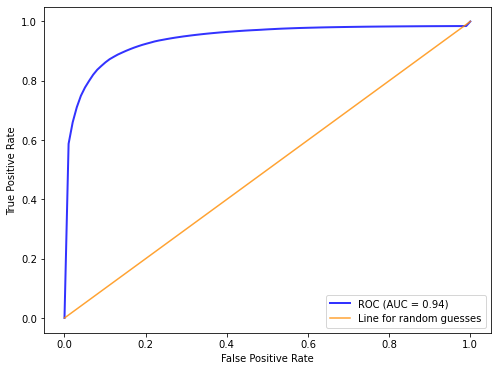

In [49]:
# Draw ROC curve for the ensemble
plt.figure(figsize=(8, 6))

# Calculate ROC curve for each model
mean_fpr_VBF = np.linspace(0, 1, 100)
tprs = []
for i in range(n_samples):
    y_scores = models[i].predict_proba(X2)[:, 1]
    fpr, tpr, _ = roc_curve(y2, y_scores)
    interp_tpr = np.interp(mean_fpr_VBF, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

# Calculate mean and standard deviation of ROC curve
mean_tpr_VBF = np.mean(tprs, axis=0)
mean_tpr_VBF[-1] = 1.0
std_tpr_VBF = np.std(tprs, axis=0)

plt.plot(mean_fpr_VBF, mean_tpr_VBF, color='b', label=f'ROC (AUC = {avg_auc_score_VBF:.2f})', lw=2, alpha=0.8)

# Plot the diagonal (random classifier)
plt.plot([0, 1], [0, 1], color='darkorange', alpha=0.8, label = 'Line for random guesses') 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#.title('ROC Curve for Ensemble of Models')
plt.legend(loc='lower right')
plt.show()

In [225]:

for j in range(0,len(num_bins_list)):    
    efficiency_plot_stds(eff_real_list_VBF[j],eff_meas_list_VBF[j], mean_list_VBF[j], mean_plus_list_VBF[j], mean_minus_list_VBF[j], None, "True efficiency","Measured efficiency", 
                         "GB mean efficiency","DNN efficiency","",y_min_list[j], y_max_list[j], range_min_list[j],range_max_list[j], names_list_plot[j],"STD_VBF_TEfficiency_"+names_list[j]+"_GB1_"+ run_name+".png","VBF")

Info in <TCanvas::Print>: png file STD_VBF_TEfficiency_HighestPt_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_VBF_TEfficiency_HT_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_VBF_TEfficiency_MET_pt_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_VBF_TEfficiency_mHH_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_VBF_TEfficiency_HighestMass_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_VBF_TEfficiency_SecondHighestPt_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_VBF_TEfficiency_SecondHighestMass_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_VBF_TEfficiency_FatHT_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_VBF_TEfficiency_MET_FatJet_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_VBF_TEfficiency_mHHwithMET_GB1_gradu.png has been created
Info in <TCanvas::Print>: png file STD_VBF

In [1]:
#ratio_plot(h_gb_pt_VBF, VBF_eff_real_pt, VBF_eff_meas_list_pt[0], num_bins_pt, range_min_pt, range_max_pt, "VBF_", "Highest FatJet pT")


## 4) Real Data

Now we repeat the previous processes, but use real data. 

### Measure efficiency and train the GB algorithm

In [37]:
# Efficiency plots
eff_list_DATA = []
for j in range(0,len(variable_list)):
    eff_DATA = efficiency_plot_DATA(df_DATA,sample,signal_trigger,ref_trigger_list[0],variable_list[j], names_list_plot[j], names_list[j],"", range_min_list[j],range_max_list[j],num_bins_list[j],y_min_list[j],y_max_list[j],
                                       sample+"_TEfficiency_"+names_list[j]+"_"+ref_trigger_list[0] +"_"+run_name+".png")
    eff_list_DATA.append(eff_DATA)

Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: png file DATA_TEfficiency_HighestPt_HLT_AK8PFJet260_gradu.png has been created
Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: png file DATA_TEfficiency_HT_HLT_AK8PFJet260_gradu.png has been created
Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: png file DATA_TEfficiency_MET_pt_HLT_AK8PFJet260_gradu.png has been created
Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: png file DATA_TEfficiency_mHH_HLT_AK8PFJet260_gradu.png has been created
Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: png file DATA_TEfficiency_HighestMass_HLT_AK8PFJet260_gradu.png has been created
Info in <TCanvas::Print>: ps file c.ps has been created
Info in <TCanvas::Print>: png file DATA_TEfficiency_SecondHighestPt_HLT_AK8PFJet260_gradu.png has been created
Info in <TCanvas::Print>: ps file c.ps has

In [36]:
filename = 'gb_models_newest_DATA.sav'
#pickle.dump(models_DATA, open(filename, 'wb'))


# load the model from disk
models_DATA = pickle.load(open(filename, 'rb'))

Model 1 - Test Accuracy: 0.8971 - AUC-ROC Score: 0.9586
Model 2 - Test Accuracy: 0.8964 - AUC-ROC Score: 0.9576
Model 3 - Test Accuracy: 0.8977 - AUC-ROC Score: 0.9589
Model 4 - Test Accuracy: 0.8960 - AUC-ROC Score: 0.9585
Model 5 - Test Accuracy: 0.8966 - AUC-ROC Score: 0.9594
Model 6 - Test Accuracy: 0.8961 - AUC-ROC Score: 0.9583
Model 7 - Test Accuracy: 0.8967 - AUC-ROC Score: 0.9579
Model 8 - Test Accuracy: 0.8964 - AUC-ROC Score: 0.9581
Model 9 - Test Accuracy: 0.8971 - AUC-ROC Score: 0.9578
Model 10 - Test Accuracy: 0.8954 - AUC-ROC Score: 0.9579
Model 11 - Test Accuracy: 0.8959 - AUC-ROC Score: 0.9581
Model 12 - Test Accuracy: 0.8960 - AUC-ROC Score: 0.9578
Model 13 - Test Accuracy: 0.8972 - AUC-ROC Score: 0.9580
Model 14 - Test Accuracy: 0.8966 - AUC-ROC Score: 0.9574
Model 15 - Test Accuracy: 0.8948 - AUC-ROC Score: 0.9570
Model 16 - Test Accuracy: 0.8969 - AUC-ROC Score: 0.9586
Model 17 - Test Accuracy: 0.8961 - AUC-ROC Score: 0.9580
Model 18 - Test Accuracy: 0.8953 - AUC-R

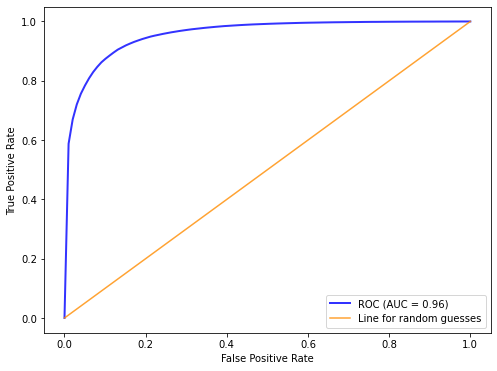

[0.04301471 0.11261617 0.08399516 0.07235423 0.07703128 0.09340441
 0.10812667 0.11059872 0.12706292 0.16619728 0.20760401 0.22183612
 0.21455854 0.27649426 0.30411302 0.36903855 0.41033091 0.59698593
 0.67852614 0.74727779 0.81153908 0.81828525 0.84241835 0.86448693
 0.88667593 0.90325646 0.93699414 0.95675333 0.97132995 0.9813944
 0.98754225 0.98988336 0.99081584 0.99279023 0.99449392 0.99566509
 0.99621448 0.99689132 0.99658655 0.99742671 0.99761286]


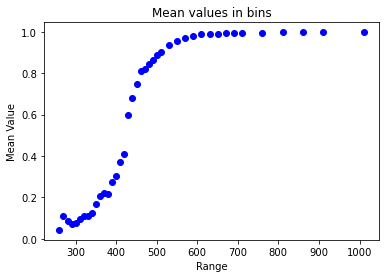

[0.08962907 0.16879296 0.13278095 0.10737676 0.10820887 0.13060502
 0.14523884 0.15201414 0.16808048 0.21720773 0.26075736 0.278167
 0.26854246 0.34334634 0.37396587 0.44460345 0.49776488 0.6871661
 0.75620166 0.81670189 0.86886252 0.8721353  0.89160032 0.90689731
 0.92545453 0.9383222  0.96160186 0.97587875 0.98387256 0.99079416
 0.99359742 0.99470438 0.99630907 0.99637741 0.99734363 0.99767614
 0.99773193 0.99806847 0.99818404 0.99848046 0.99851184]


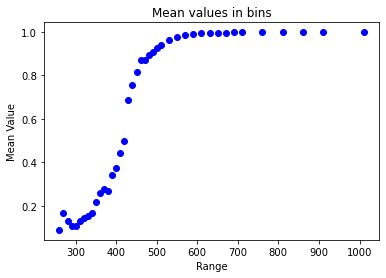

[0.01213753 0.058322   0.04449725 0.04146121 0.04666169 0.05789146
 0.07204195 0.07068743 0.08693271 0.11539823 0.15460778 0.16574158
 0.16074382 0.20971519 0.234372   0.29334594 0.32282699 0.50638649
 0.60037679 0.67762216 0.75375961 0.76360294 0.79240015 0.82121056
 0.84778357 0.86757304 0.91110751 0.9366595  0.95722859 0.97015564
 0.98037997 0.98421703 0.98306951 0.98862017 0.99009808 0.99277412
 0.99433219 0.99567932 0.99393338 0.99620783 0.99663779]


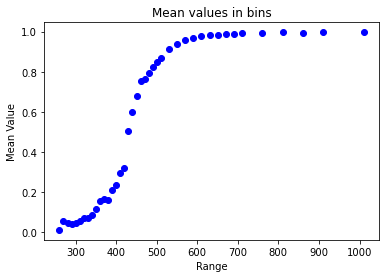

[0.34505104 0.16266322 0.07010415 0.12184929 0.17480561 0.07404256
 0.09072332 0.07001675 0.09137154 0.1186926  0.12072435 0.14344713
 0.15037602 0.18385843 0.17786635 0.19586537 0.22306469 0.24999873
 0.28585552 0.33140094 0.36888851 0.43588944 0.51166742 0.59017476
 0.64154078 0.67214937 0.70943239 0.73644322 0.80748772 0.83548911
 0.84439527 0.86028949 0.89232416 0.91211763 0.92424339 0.94371961
 0.95536355 0.97172691 0.98355277 0.98451226 0.98360012 0.98474023
 0.99111533 0.99370238 0.99466398 0.99531629 0.99522625 0.99552234
 0.9964173  0.99641644 0.99689454 0.99741298 0.99783189]


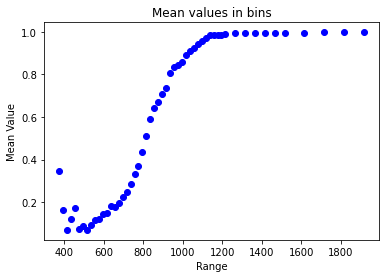

[0.43991021 0.24939806 0.12361864 0.15286517 0.24295068 0.11433419
 0.135632   0.1008043  0.12363194 0.16347789 0.1624603  0.1869623
 0.19411321 0.22893072 0.2236991  0.24395904 0.27350783 0.30606719
 0.34341314 0.39602295 0.43719431 0.50748045 0.5847242  0.66730774
 0.71451346 0.74082477 0.77673948 0.79980934 0.86234628 0.88369772
 0.8898375  0.90521821 0.92969219 0.94411204 0.95324757 0.96686198
 0.97703132 0.98876049 0.99122221 0.99203428 0.99338581 0.99412361
 0.99536316 0.99670236 0.99724701 0.99746335 0.9977667  0.99758051
 0.99795837 0.99809508 0.99823854 0.99838702 0.99868993]


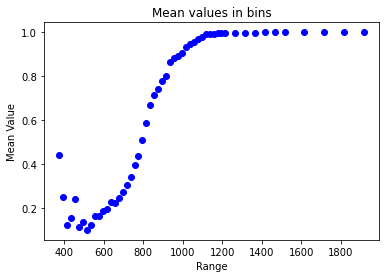

[0.25058109 0.07999166 0.01925583 0.09620835 0.11158422 0.0395915
 0.0491755  0.04140221 0.05987442 0.07692369 0.07977293 0.10061407
 0.10770671 0.1392141  0.13268736 0.14795222 0.17275675 0.19411709
 0.22844233 0.26682009 0.30109175 0.36410247 0.43901951 0.51318239
 0.56853318 0.60341818 0.64199526 0.6730771  0.7524456  0.78715288
 0.79882769 0.81510276 0.85491068 0.87956852 0.89373104 0.91902965
 0.93158035 0.95064406 0.97428696 0.97603398 0.97004138 0.97063087
 0.98614263 0.99035559 0.9917188  0.99263886 0.99095892 0.9928197
 0.9942318  0.99395801 0.99499369 0.99633323 0.99686097]


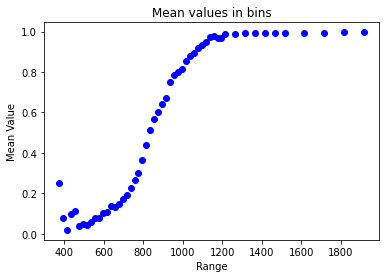

[0.55971071 0.55914779 0.56680394 0.58655112 0.6019233  0.63168853
 0.64112587 0.67233047 0.68749753 0.73066669 0.73620856 0.78505341
 0.75286527 0.7958652  0.81826867 0.83567098 0.84736929 0.86953699
 0.88053898 0.89299601 0.89789683 0.91661579 0.92160295 0.96089732
 0.95978939 0.96262238 0.94589137 0.96774887 0.9652469  0.96957502
 0.96920436 0.97890241 0.97936272 0.98179492 0.94875987 0.98795516
 0.98830699]


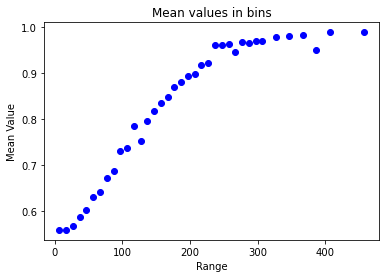

[0.59834319 0.59316845 0.59867676 0.62041683 0.63476015 0.66578345
 0.67550047 0.71215911 0.73108628 0.77827114 0.78583751 0.83263041
 0.80766937 0.84972489 0.87380488 0.88754628 0.89610789 0.92423631
 0.92909425 0.9395419  0.95073636 0.95539258 0.97299616 0.98160747
 0.98825959 0.98448471 0.98532031 0.98278846 0.98304149 0.99056017
 0.98528067 0.9907909  0.98943573 0.99010899 0.98841829 0.99521703
 0.99531589]


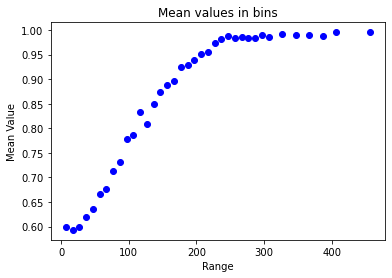

[0.52033132 0.52520395 0.53503611 0.55290812 0.56882494 0.59754116
 0.60662127 0.63226135 0.64371419 0.68242339 0.68613661 0.73672523
 0.69765184 0.74191177 0.76093099 0.78362502 0.79784982 0.81382831
 0.83156525 0.84514732 0.84092246 0.87600036 0.86765889 0.93993284
 0.92434385 0.93459435 0.89734003 0.95217131 0.9468362  0.9475982
 0.95213084 0.96643192 0.96928971 0.97286138 0.90121978 0.97991529
 0.9812981 ]


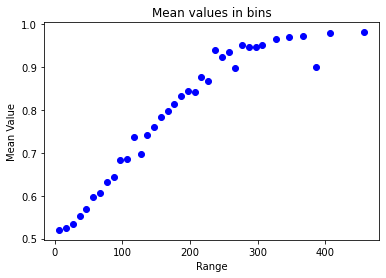

[0.46356559 0.1731025  0.1897577  0.15940693 0.21809718 0.25594277
 0.31002814 0.39411994 0.4853407  0.58467653 0.65022258 0.70451812
 0.7474561  0.78425709 0.7853109  0.83518947 0.82208161 0.83442901
 0.85019357 0.87010524 0.86872173 0.86748744 0.88465732 0.89636069
 0.87943846 0.87360107 0.90164193 0.90856103 0.9210711  0.91407745
 0.93127415 0.91806149 0.94073191 0.97769822]


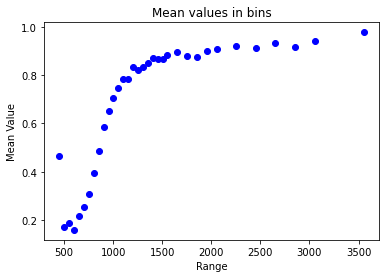

[0.55152631 0.24258463 0.24737483 0.21252131 0.26889634 0.30521116
 0.36648218 0.45261697 0.54234485 0.64078335 0.69916675 0.74718416
 0.7891307  0.82136266 0.81949839 0.86444184 0.84867596 0.85860074
 0.87547927 0.89403062 0.89024343 0.88845723 0.90499394 0.917005
 0.90016085 0.89339494 0.92149955 0.92787229 0.93965052 0.93284044
 0.95268822 0.94118145 0.96460697 0.99037343]


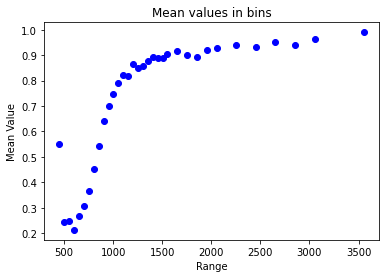

[0.38270848 0.10844429 0.13484491 0.10829112 0.16795869 0.20684547
 0.2534396  0.33557433 0.42753045 0.52829332 0.60098253 0.66176163
 0.70533482 0.74617672 0.75025132 0.80538783 0.79504174 0.80996832
 0.82367735 0.84557878 0.846501   0.84593959 0.863065   0.87556997
 0.85818483 0.8532164  0.88128739 0.8892905  0.90155758 0.89427112
 0.90983177 0.89335402 0.91580269 0.96499805]


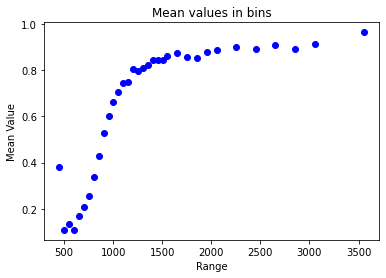

[0.34988153 0.51996434 0.61922002 0.61139358 0.68851526 0.73607038
 0.74142527 0.67856121 0.63310718 0.62013348 0.71420078 0.75372503
 0.81546671 0.84101028 0.87578563 0.88908822 0.9225042  0.9584797
 0.97179791 0.96844064 0.98199767 0.96643341 0.9621193  0.98942452
 0.99871997 0.99864609 0.99107883 0.99871487]


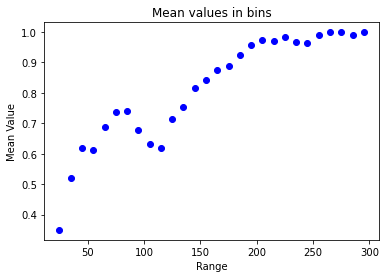

[0.40935546 0.56931153 0.66399327 0.65281323 0.72377118 0.7696146
 0.77326427 0.71622521 0.6680489  0.65737368 0.74841897 0.7938863
 0.85035923 0.87554353 0.90331278 0.91677262 0.94655133 0.97585709
 0.98714682 0.97975883 0.99927523 0.9909096  0.98349691 0.99918905
 0.99924181 0.99904737 0.99957812 0.99914522]


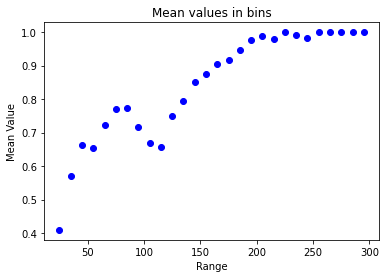

[0.29061161 0.47055375 0.57416559 0.56966137 0.65279189 0.70188414
 0.70936677 0.6409855  0.59836596 0.58241308 0.68001444 0.71330166
 0.77995502 0.80565031 0.84718768 0.86134061 0.89528313 0.94029153
 0.956449   0.95687405 0.96186351 0.94090861 0.93934422 0.97767882
 0.99819813 0.9982448  0.9635011  0.99828452]


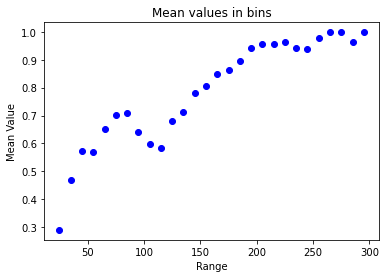

[0.29776911 0.33860508 0.32858334 0.31766079 0.35261505 0.41213004
 0.35475524 0.35808639 0.36905017 0.35040213 0.3823048  0.43573538
 0.44558604 0.48948113 0.54042076 0.56404124 0.65517331 0.69030932
 0.7284094  0.73305374 0.80354679 0.82199703 0.86777569 0.8971221
 0.91503211 0.93380394 0.93583451 0.95044051 0.95698246 0.96486264
 0.97771056 0.98877601 0.99476496 0.99601365 0.99643039 0.99609229
 0.9966763  0.99709052 0.9968595  0.99735706 0.99690785 0.9975499
 0.99737746 0.99757001 0.99771192]


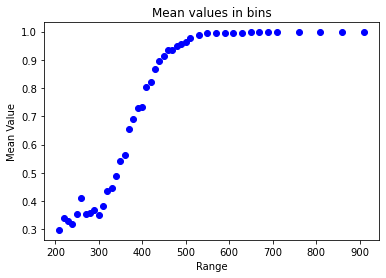

[0.36649579 0.40086783 0.38456875 0.37631899 0.41004864 0.46790283
 0.40785069 0.41088354 0.42216029 0.39984411 0.43181801 0.4853678
 0.49481427 0.54101927 0.59073158 0.61792288 0.70590342 0.74352069
 0.7784371  0.78289593 0.84992139 0.86693995 0.90531145 0.92838204
 0.94091597 0.95662523 0.96033289 0.96901189 0.9748512  0.98049845
 0.98944857 0.99447207 0.99693781 0.99755688 0.99769594 0.99771156
 0.99800605 0.99815257 0.99803923 0.99825148 0.99818432 0.99841584
 0.99831874 0.99867563 0.99853717]


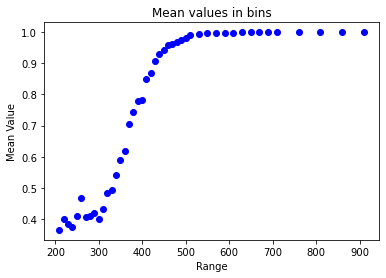

[0.23020732 0.27828947 0.27267402 0.26038034 0.29560486 0.3563865
 0.30189135 0.30517132 0.31570659 0.30135579 0.33300627 0.38604063
 0.39563497 0.43741677 0.48962594 0.5096271  0.60380793 0.63691172
 0.67716658 0.683107   0.75602334 0.77679278 0.82976223 0.86541132
 0.88855646 0.90975476 0.91000303 0.93125085 0.9375577  0.94839702
 0.96330036 0.98160031 0.99252064 0.99442959 0.99514496 0.9941502
 0.99500737 0.99600764 0.99561664 0.99636475 0.99487107 0.99668396
 0.99643434 0.99539127 0.99688666]


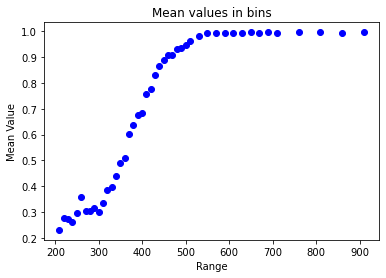

[0.34775548 0.51333063 0.56183775 0.6201701  0.66111417 0.69440977
 0.7243426  0.72223879 0.74866778 0.77763129 0.82567204 0.84633194
 0.8744014  0.94128594 0.95966275 0.96539157 0.97817119 0.98671792
 0.99501831 0.99799463 0.99768787 0.99842649 0.99777931 0.99848357
 0.99846687 0.99853478 0.9985357  0.99888026]


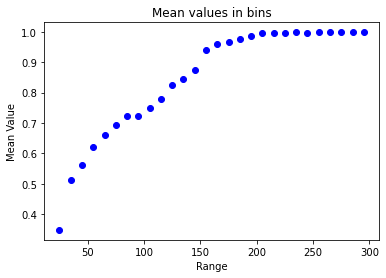

[0.40201449 0.55982986 0.60492968 0.66203258 0.70232093 0.73272307
 0.7590118  0.75721672 0.78176834 0.80706036 0.85128869 0.87253661
 0.89797505 0.95709552 0.97301867 0.97704304 0.98452881 0.99169474
 0.99746278 0.99877185 0.99857643 0.99910278 0.99868705 0.99922347
 0.99905146 0.99914233 0.99901143 0.99930534]


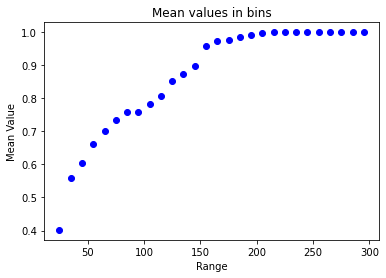

[0.29386032 0.46676362 0.51824235 0.5781189  0.6196766  0.6557712
 0.68931937 0.68671619 0.71526329 0.74768755 0.79930344 0.81968386
 0.84963728 0.92393001 0.9448448  0.95356213 0.97175775 0.98163422
 0.99257383 0.9972174  0.99679931 0.99765149 0.99687157 0.99772761
 0.99788228 0.99792723 0.99805997 0.99845517]


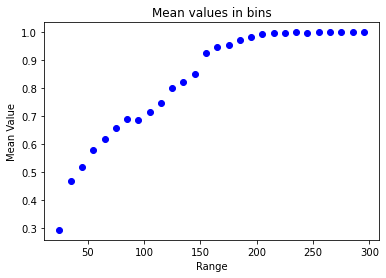

[0.35375551 0.03101689 0.59901376 0.04462436 0.09121963 0.09805135
 0.08026855 0.07205139 0.09766108 0.11244392 0.12108217 0.14754995
 0.18187913 0.20964045 0.20147571 0.24778735 0.27044734 0.3136762
 0.35609625 0.44650918 0.48161112 0.55680721 0.59232731 0.6779787
 0.73097706 0.77433868 0.80934107 0.83775194 0.85430557 0.88217329
 0.89933438 0.9067111  0.9154979  0.95874043 0.96390986 0.96767823
 0.98077254 0.9810269  0.99069405 0.99153167 0.99291439 0.99328013
 0.99363196 0.99468034 0.99523414 0.99618697 0.99606708 0.99577656
 0.99591911 0.99667159 0.99719902 0.99725891 0.99787717]


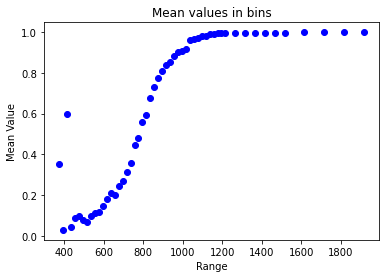

[0.52778364 0.07593384 0.71294252 0.10917153 0.16649421 0.14965359
 0.1280301  0.11133413 0.14113859 0.15759804 0.16112634 0.19356284
 0.22778475 0.26338714 0.25490935 0.30272778 0.32647579 0.37360179
 0.41975255 0.5175969  0.55548873 0.63199786 0.6693455  0.75158181
 0.79483229 0.83360153 0.8640041  0.88558074 0.90068582 0.92070459
 0.93477136 0.9415729  0.95159591 0.97716998 0.9813482  0.98381215
 0.99181026 0.99248782 0.99555142 0.99577252 0.99633573 0.99728393
 0.99687973 0.99714887 0.99733807 0.9977354  0.99784961 0.99771029
 0.99785617 0.99821562 0.99832132 0.99836974 0.9986476 ]


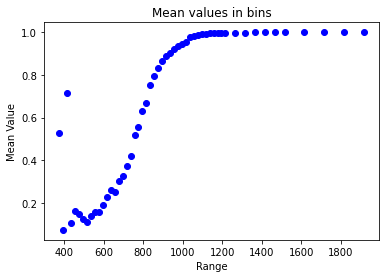

[0.18851743 0.         0.48508499 0.00568031 0.02393271 0.0533311
 0.03952768 0.03541705 0.05625239 0.06882626 0.08126006 0.10190528
 0.13668965 0.15650758 0.14845724 0.19300578 0.21452017 0.25354323
 0.29235386 0.37539955 0.40798198 0.48151983 0.51485481 0.60433291
 0.66705809 0.71506172 0.75451566 0.7897986  0.80736927 0.84332564
 0.86322431 0.87135888 0.878391   0.93942224 0.94507674 0.94918873
 0.96496323 0.96640647 0.98459796 0.98665575 0.98881459 0.98498287
 0.98929548 0.99154522 0.99300427 0.99442007 0.99368127 0.99378711
 0.99308626 0.9937979  0.99563532 0.99602682 0.99710675]


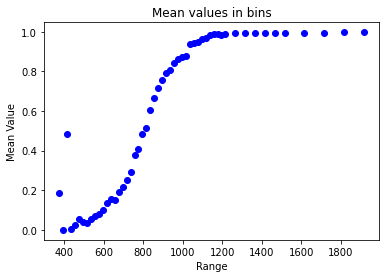

[0.02755462 0.0371359  0.06642544 0.1501469  0.26056772 0.40728458
 0.58013954 0.73351856 0.83277371 0.88211956 0.92523997 0.95361988
 0.971557   0.98301781 0.98925659 0.99312647 0.99426175 0.99519011
 0.99581745 0.99633598 0.99737242 0.99657623 0.99718111 0.99719478
 0.99796518 0.99800857 0.99742445 0.99780379 0.99748659]


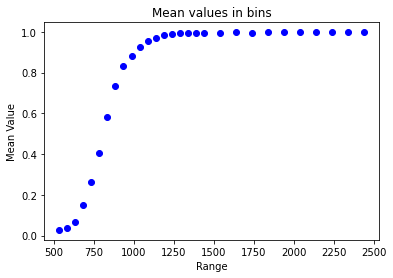

[0.04865554 0.06211057 0.10126043 0.20410146 0.32537723 0.47928126
 0.65254364 0.79725145 0.8815081  0.92041808 0.95281719 0.9723896
 0.9842069  0.9915209  0.9949735  0.99666636 0.99753973 0.99752139
 0.99768893 0.99788268 0.99832626 0.99818016 0.99828903 0.99855632
 0.99872174 0.99874648 0.99835518 0.99857574 0.99858089]


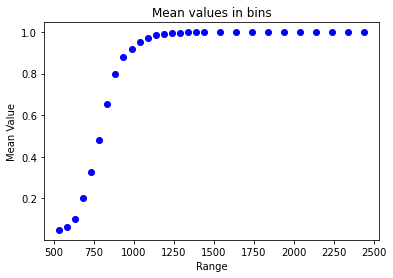

[0.0096189  0.01489883 0.03272767 0.09656421 0.19593541 0.33512803
 0.50762691 0.66945415 0.7828437  0.84295465 0.89672136 0.93365451
 0.95780994 0.97344991 0.98178238 0.98852638 0.98979866 0.99208058
 0.99347895 0.99421274 0.996409   0.9939723  0.99589849 0.99480926
 0.99720863 0.99727066 0.99649371 0.99703184 0.99639228]


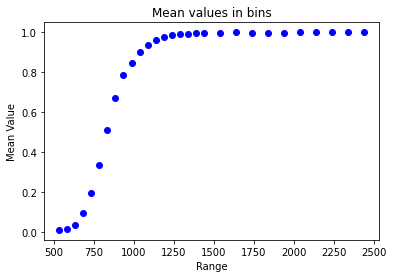

[0.1598704  0.05809314 0.06636042 0.05051097 0.06449384 0.108385
 0.15038286 0.22018147 0.29505762 0.4050194  0.50830729 0.59076355
 0.64807123 0.7022699  0.76120298 0.77910746 0.79823464 0.81061014
 0.84057578 0.8482139  0.86713629 0.86537283 0.88319447 0.90902694
 0.87483332 0.89431523 0.90576029 0.91137805 0.92172152 0.92124045
 0.93011905 0.93063537 0.93374553 0.98039907]


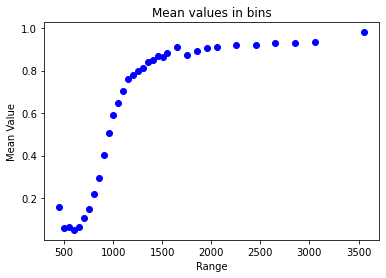

[0.32082638 0.1184574  0.09492453 0.08549058 0.09662829 0.14749466
 0.19251639 0.26942221 0.35299004 0.46735229 0.56921659 0.64652936
 0.7001311  0.7509648  0.80526075 0.81817347 0.83465826 0.84268218
 0.87137614 0.87505516 0.89157309 0.89125466 0.90510174 0.92872584
 0.89804202 0.91248706 0.92392629 0.92978199 0.94097956 0.94039468
 0.94818366 0.95412332 0.95782997 0.99160262]


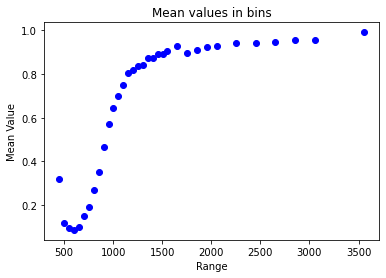

[0.         0.00630689 0.04424413 0.02061411 0.03490916 0.07030276
 0.10918577 0.17109615 0.23723511 0.3418004  0.44738739 0.53512132
 0.59551314 0.65326044 0.71657832 0.73935652 0.76173695 0.77772797
 0.80875712 0.82064146 0.84171902 0.83881911 0.86006534 0.88842311
 0.85106167 0.87519932 0.88747129 0.89275277 0.90205185 0.90101331
 0.91101416 0.90712442 0.90780201 0.96917531]


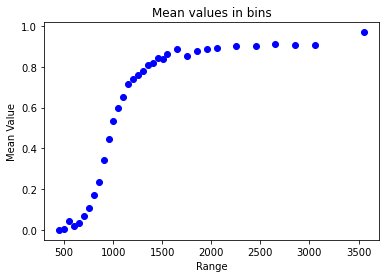

[0.5482766  0.65577057 0.68561189 0.68197716 0.65066498 0.56889626]


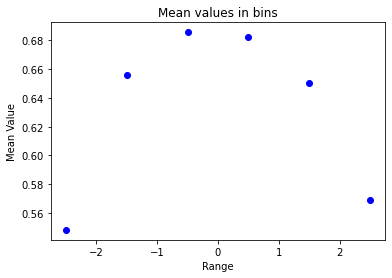

[0.60414171 0.69493044 0.72238464 0.71867297 0.68744888 0.62207805]


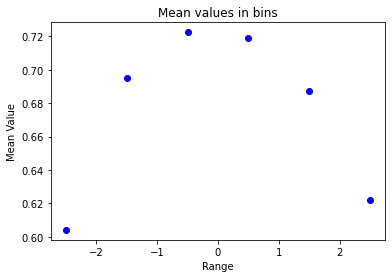

[0.49193736 0.61635821 0.64850268 0.64489301 0.61361202 0.51555373]


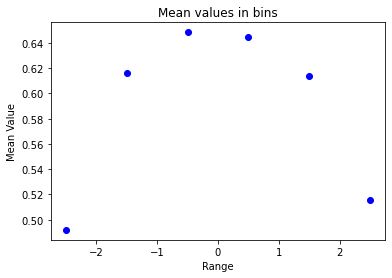

[0.59977938 0.65801301 0.67876767 0.67864212 0.65605384 0.57835402]


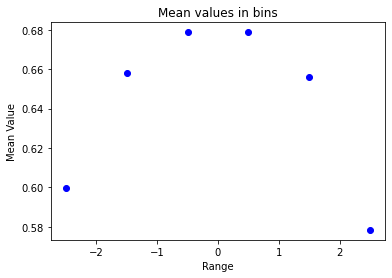

[0.66120624 0.69928794 0.71343016 0.71326894 0.69436731 0.62740086]


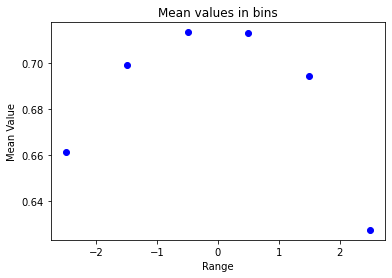

[0.53834528 0.61674849 0.6435222  0.64351715 0.61751259 0.52947534]


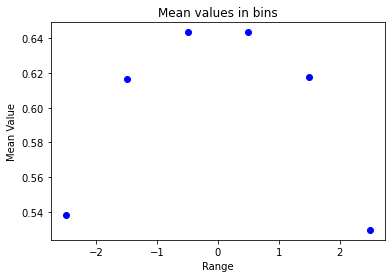

[0.64827956 0.6622069  0.67162937 0.66923382 0.68262777 0.66203744
 0.6387192  0.67117218 0.65039726 0.73029622]


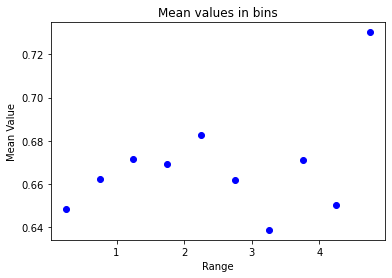

[0.68824731 0.69885594 0.70823849 0.70633275 0.72040729 0.70159843
 0.68319106 0.73013259 0.71579313 0.84263809]


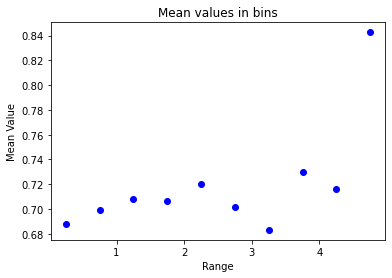

[0.60796745 0.62526329 0.6346803  0.63182222 0.64472787 0.62188154
 0.59375935 0.61310335 0.58321541 0.61971236]


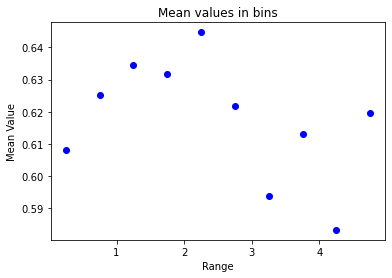

[0.7670445  0.65999983 0.63819871 0.76293291 0.95858942 0.92770837
 0.83674133 0.66967697 0.66751884 0.75462283]


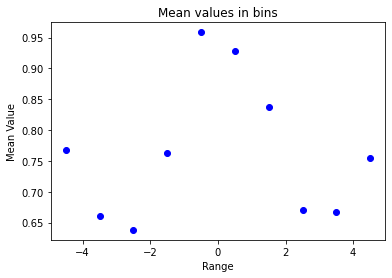

[0.84922695 0.69637551 0.67846187 0.80761114 0.9951912  0.96364468
 0.8885079  0.71102867 0.70549259 0.8295364 ]


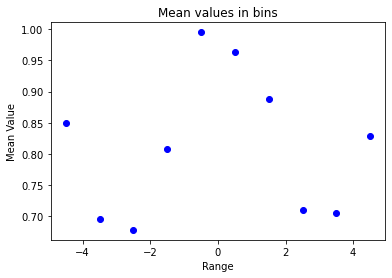

[0.68096223 0.62339904 0.5976225  0.71577727 0.90754643 0.89177206
 0.77679217 0.6279323  0.62929602 0.67798044]


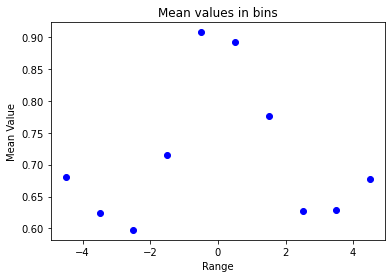

In [38]:
if sample == "DATA":
    
    pddf,features= RD_to_pandas(df_DATA, filter_all_meas, names_list_and_signal_trigger, names_list)


    y = pddf[signal_trigger].astype('bool')
    y = y*1
    y = y.astype(int).values
    
    X = features.values 
    
    # Get the gradient boosting predicted efficiencies and uncertainties
    mean_list_DATA, mean_plus_list_DATA, mean_minus_list_DATA = mean_and_standard_deviation(models_DATA, X, y, num_bins_list, range_min_list, range_max_list)

In [28]:
"""
# Development

pddf_DATA,features_DATA= RD_to_pandas(df_DATA, filter_all_meas, 0.3,["nFatJet", "HighestPt", "HT", "MET_pt", "mHH","HighestMass","SecondHighestPt", 
                                                           "SecondHighestMass", "Combo", "FatHT", "MET_FatJet", "mHHwithMET", "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"],
                             ["HighestPt", "HT","MET_pt", "mHH","HighestMass","SecondHighestPt", "SecondHighestMass", "FatHT", "MET_FatJet","mHHwithMET",
                              "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"])

#random_state=0

y = pddf_DATA["Combo"].astype('bool')
y = y*1
y = y.astype(int).values
    
X = features_DATA.values 


X_train_DATA, X_test_DATA, y_train_DATA, y_test_DATA = train_test_split(X, y, test_size=0.2)


n_samples = 20

models_DATA = []
indices_x_DATA = []

for i in range(n_samples):
    index_x = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
    indices_x_DATA.append(index_x)
    X_sample = X[index_x, :]

    y_sample = y[index_x]

    # Split the data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X_sample, y_sample, test_size=0.2, random_state=1)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

    model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.25, max_depth=2, random_state=0).fit(X_train, y_train)
    models_DATA.append(model)

    y_pred = model.predict(X_test)
    
    # Monitor the model's performance on the validation set for early stopping
    val_predictions = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    print(f"Iteration {i + 1} - Validation Accuracy: {val_accuracy:.4f}")
    
# Evaluate the final model(s) on the test set
for i, model in enumerate(models_DATA):
    test_predictions = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    print(f"Model {i + 1} - Test Accuracy: {test_accuracy:.4f}")

    
"""

Iteration 1 - Validation Accuracy: 0.8985
Iteration 2 - Validation Accuracy: 0.9017
Iteration 3 - Validation Accuracy: 0.8876
Iteration 6 - Validation Accuracy: 0.9050
Iteration 7 - Validation Accuracy: 0.9001
Iteration 8 - Validation Accuracy: 0.9017
Iteration 9 - Validation Accuracy: 0.8897
Iteration 10 - Validation Accuracy: 0.8936
Iteration 11 - Validation Accuracy: 0.8952
Iteration 12 - Validation Accuracy: 0.9023
Iteration 13 - Validation Accuracy: 0.8968
Iteration 14 - Validation Accuracy: 0.8919
Iteration 15 - Validation Accuracy: 0.8925
Iteration 16 - Validation Accuracy: 0.8968
Iteration 17 - Validation Accuracy: 0.9001
Iteration 18 - Validation Accuracy: 0.8925
Iteration 19 - Validation Accuracy: 0.8936
Iteration 20 - Validation Accuracy: 0.8886
Model 1 - Test Accuracy: 0.8909
Model 2 - Test Accuracy: 0.8887
Model 3 - Test Accuracy: 0.8936
Model 4 - Test Accuracy: 0.8980
Model 5 - Test Accuracy: 0.8996
Model 6 - Test Accuracy: 0.8963
Model 7 - Test Accuracy: 0.8942
Model 8 -

In [32]:
pddf_DATA,features_DATA= RD_to_pandas(df_DATA, filter_all_meas, ["nFatJet", "HighestPt", "HT", "MET_pt", "mHH","HighestMass","SecondHighestPt", 
                                                           "SecondHighestMass", "Combo", "FatHT", "MET_FatJet", "mHHwithMET", "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"],
                             ["HighestPt", "HT","MET_pt", "mHH","HighestMass","SecondHighestPt", "SecondHighestMass", "FatHT", "MET_FatJet","mHHwithMET",
                              "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"])



y = pddf_DATA["Combo"].astype('bool')
y = y*1
y_DATA = y.astype(int).values
    
X_DATA = features_DATA.values 


Model 1 - Test Accuracy: 0.8971 - AUC-ROC Score: 0.9586
Model 2 - Test Accuracy: 0.8964 - AUC-ROC Score: 0.9576
Model 3 - Test Accuracy: 0.8977 - AUC-ROC Score: 0.9589
Model 4 - Test Accuracy: 0.8960 - AUC-ROC Score: 0.9585
Model 5 - Test Accuracy: 0.8966 - AUC-ROC Score: 0.9594
Model 6 - Test Accuracy: 0.8961 - AUC-ROC Score: 0.9583
Model 7 - Test Accuracy: 0.8967 - AUC-ROC Score: 0.9579
Model 8 - Test Accuracy: 0.8964 - AUC-ROC Score: 0.9581
Model 9 - Test Accuracy: 0.8971 - AUC-ROC Score: 0.9578
Model 10 - Test Accuracy: 0.8954 - AUC-ROC Score: 0.9579
Model 11 - Test Accuracy: 0.8959 - AUC-ROC Score: 0.9581
Model 12 - Test Accuracy: 0.8960 - AUC-ROC Score: 0.9578
Model 13 - Test Accuracy: 0.8972 - AUC-ROC Score: 0.9580
Model 14 - Test Accuracy: 0.8966 - AUC-ROC Score: 0.9574
Model 15 - Test Accuracy: 0.8948 - AUC-ROC Score: 0.9570
Model 16 - Test Accuracy: 0.8969 - AUC-ROC Score: 0.9586
Model 17 - Test Accuracy: 0.8961 - AUC-ROC Score: 0.9580
Model 18 - Test Accuracy: 0.8953 - AUC-R

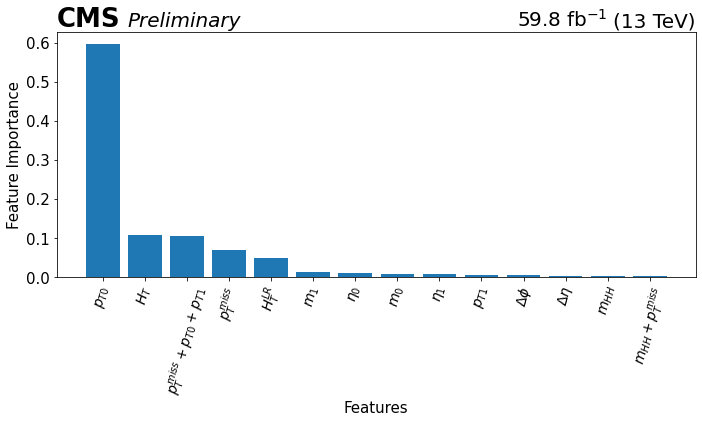

In [33]:
# Evaluate the model using AUC and accuracy, plot the feature importance

auc_scores = []
test_accuracies = []

n_samples = 20

for i in range(n_samples):
    test_predictions = models_DATA[i].predict(X_DATA)
    test_accuracy = accuracy_score(y_DATA, test_predictions)
    test_accuracies.append(test_accuracy)

    # Calculate AUC-ROC score for each model
    y_scores = models_DATA[i].predict_proba(X_DATA)[:, 1]  # Probability of positive class
    auc_score = roc_auc_score(y_DATA, y_scores)
    auc_scores.append(auc_score)

    print(f"Model {i + 1} - Test Accuracy: {test_accuracy:.4f} - AUC-ROC Score: {auc_score:.4f}")

avg_test_accuracy = np.mean(test_accuracies)
avg_auc_score = np.mean(auc_scores)
print(f"\nAverage Test Accuracy across all models_DATA: {avg_test_accuracy:.4f}")
print(f"Average AUC-ROC Score across all models_DATA: {avg_auc_score:.4f}")

# Feature Importance Ranking
feature_importance = np.zeros(X_DATA.shape[1])

#"p_{T0} [GeV]","H_{T} [GeV]","p_{T}^{miss} [GeV]", "m_{HH} [GeV]","m_{0} [GeV]","p_{T1} [GeV]", "m_{1} [GeV]",
 #                  "LR H_{T} [GeV]", "p_{T}^{miss}+p_{T0}+p_{T1} [GeV]","m_{HH}+p_{T}^{miss} [GeV]","#eta_{0}", "#eta_{1}", "#Delta#eta", "#Delta#phi"

new_names = [r'$p_{T0}$',r'$H_{T}$',r"$p_{T}^{miss}$",r"$m_{HH}$", r"$m_{0}$",r"$p_{T1}$", r"$m_{1}$",
                   r"$H_{T}^{LR}$", r"$p_{T}^{miss}+p_{T0}+p_{T1}$",r"$m_{HH}+p_{T}^{miss}$",r"$\eta_{0}$", r"$\eta_{1}$", r"$\Delta\eta$", r"$\Delta\phi$"]

for model in models_DATA:
    feature_importance += model.feature_importances_

average_feature_importance = feature_importance / len(models_DATA)

# Sort features by importance
sorted_indices = np.argsort(average_feature_importance)[::-1]
sorted_features = [new_names[i] for i in sorted_indices]
sorted_importance = average_feature_importance[sorted_indices]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), sorted_importance, align='center')
plt.xticks(range(X.shape[1]), sorted_features, rotation=75,size=14)
    
# Add text to the plot similar to ROOT
plt.text(0, 1.02, "CMS", fontdict={'fontsize': 26, 'fontweight': 'bold'}, transform=plt.gca().transAxes)
if sample == "DATA":
    plt.text(0.11, 1.02, "Preliminary", fontdict={'fontsize': 20, 'style': 'italic'}, transform=plt.gca().transAxes)
    plt.text(0.72, 1.02, "59.8 fb$^{-1}$", fontdict={'fontsize': 20}, transform=plt.gca().transAxes)
else:
    plt.text(0.11, 1.02, "Simulation Preliminary", fontdict={'fontsize': 20, 'style': 'italic'}, transform=plt.gca().transAxes)

plt.text(0.87, 1.02, "(13 TeV)", fontdict={'fontsize': 20}, transform=plt.gca().transAxes)
plt.yticks(size=15)
plt.xlabel('Features',size=15)
plt.ylabel('Feature Importance',size=15)
#plt.title('Feature Importance Ranking')
plt.tight_layout()
plt.show()


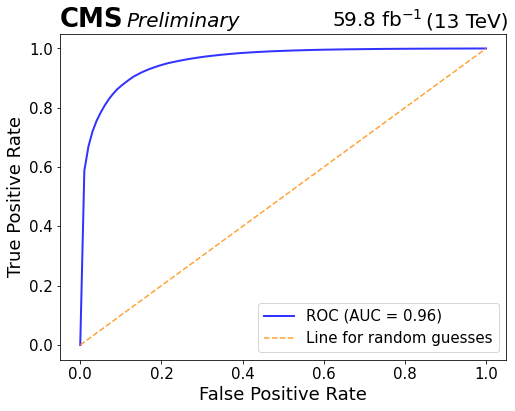

In [34]:
# Draw ROC curve for the ensemble
plt.figure(figsize=(8, 6))

# Calculate ROC curve for each model
mean_fpr = np.linspace(0, 1, 100)
tprs = []
for i in range(n_samples):
    y_scores = models_DATA[i].predict_proba(X_DATA)[:, 1]
    fpr, tpr, _ = roc_curve(y_DATA, y_scores)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

# Calculate mean and standard deviation of ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
std_tpr = np.std(tprs, axis=0)

plt.plot(mean_fpr, mean_tpr, color='b', label=f'ROC (AUC = {avg_auc_score:.2f})', lw=2, alpha=0.8)

# Plot the diagonal (random classifier)
plt.plot([0, 1], [0, 1], color='darkorange', alpha=0.8, linestyle='--', label = 'Line for random guesses') 

plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
    
plt.tick_params(axis='both', which='major', labelsize=15)
    
# Add text to the plot similar to ROOT
plt.text(0, 1.02, "CMS", fontdict={'fontsize': 26, 'fontweight': 'bold'}, transform=plt.gca().transAxes)
if sample == "DATA":
    plt.text(0.15, 1.02, "Preliminary", fontdict={'fontsize': 20, 'style': 'italic'}, transform=plt.gca().transAxes)
    plt.text(0.61, 1.02, "59.8 fb$^{-1}$", fontdict={'fontsize': 20}, transform=plt.gca().transAxes)
else:
    plt.text(0.11, 1.02, "Simulation Preliminary", fontdict={'fontsize': 20, 'style': 'italic'}, transform=plt.gca().transAxes)

plt.text(0.82, 1.02, "(13 TeV)", fontdict={'fontsize': 20}, transform=plt.gca().transAxes)
    
plt.legend(loc='lower right', fontsize=15)
plt.show()
#.title('ROC Curve for Ensemble of Models')

### 2D plots

Accuracy: 0.8818553888130969
AUC: 0.9490852288290875


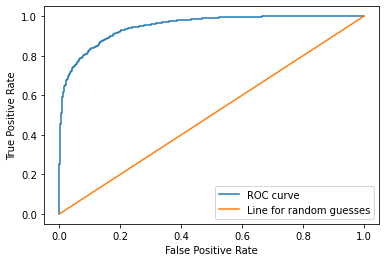

(0.0, 1500.0)

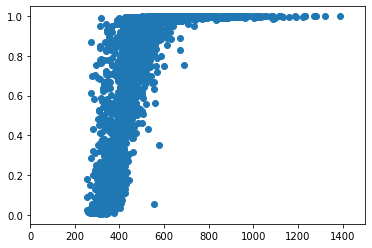

In [45]:
"""
DATA_pddf,DATA_features = RD_to_pandas(df_DATA, filter_all_meas,
                                ["HighestPt", "HT", "MET_pt", "mHH","HighestMass","SecondHighestPt", 
                                                           "SecondHighestMass", "Combo", "FatHT", "MET_FatJet", "mHHwithMET", "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"],
                             ["HighestPt", "HT","MET_pt", "mHH","HighestMass","SecondHighestPt", "SecondHighestMass", "FatHT", "MET_FatJet","mHHwithMET",
                              "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"])

gb_DATA = GradientBoostingClassifier(n_estimators=200, learning_rate=0.25, max_depth=2, random_state=0)

X_test_gb_DATA, y_test_gb_DATA, y_prob_gb_DATA, gb_trained_DATA, X_train_DATA, y_train_DATA  = train_ML_model(DATA_pddf,"Combo", DATA_features, gb_DATA, 0.2)
plt.plot(X_test_gb_DATA[:,0],y_prob_gb_DATA, "o")
plt.xlim(0,1500)
"""

In [47]:
filename = 'gb_model_DATA_new.sav'
#pickle.dump(gb_trained_DATA, open(filename, 'wb'))

# load the model from disk
gb_trained_DATA = pickle.load(open(filename, 'rb'))
#result = gb_trained

Accuracy: 0.8993178717598909
AUC: 0.9603518456933822


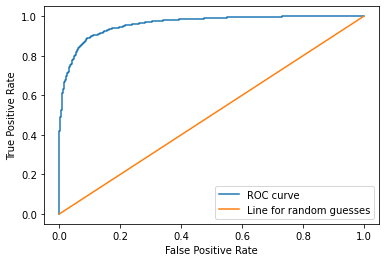

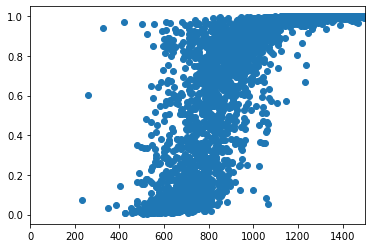

In [48]:
pddf_DATA,features_DATA= RD_to_pandas(df_DATA, filter_all_meas,["nFatJet", "HighestPt", "HT", "MET_pt", "mHH","HighestMass","SecondHighestPt", 
                                                           "SecondHighestMass", "Combo", "FatHT", "MET_FatJet", "mHHwithMET", "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"],
                             ["HighestPt", "HT","MET_pt", "mHH","HighestMass","SecondHighestPt", "SecondHighestMass", "FatHT", "MET_FatJet","mHHwithMET",
                              "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"])


y = pddf_DATA["Combo"].astype('bool')
y = y*1
y = y.astype(int).values
    
X = features_DATA.values 

X_train_DATA, X_test_DATA, y_train_DATA, y_test_DATA = train_test_split(X, y, test_size=0.2)

y_pred_DATA = gb_trained_DATA.predict(X_test_DATA)

y_prob_DATA = gb_trained_DATA.predict_proba(X_test_DATA)[:,1]


accuracy = accuracy_score(y_test_DATA, y_pred_DATA)
print("Accuracy:", accuracy)
# Calculate the AUC
print("AUC:",metrics.roc_auc_score(y_test_DATA,y_prob_DATA))

# Line for random guesses
x = (0.0,1.0)
y = x
    
# Plot the ROC curve and the line for random guesses
false_positive, true_positive, _ = metrics.roc_curve(y_test_DATA,y_prob_DATA)
plt.plot(false_positive, true_positive, label = "ROC curve")
plt.legend()
plt.plot(x,y,label="Line for random guesses")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

plt.plot(X_test_DATA[:,1],y_prob_DATA, "o")
plt.xlim(0,1500)
plt.show()

In [55]:
y_pred_DATA = gb_trained_DATA.predict(X)

y_prob_DATA = gb_trained_DATA.predict_proba(X)[:,1]

In [78]:
# Slices for the Pt and HT plots


HT_slices = []

df_ht_slice1 = df_DATA.Filter("HT<600", "")
HT_slices.append(df_ht_slice1)
df_ht_slice2 = df_DATA.Filter("600<HT && HT<900", "")
HT_slices.append(df_ht_slice2)
df_ht_slice3 = df_DATA.Filter("900<HT && HT<1200", "")
HT_slices.append(df_ht_slice3)
df_ht_slice4 = df_DATA.Filter("1200<HT && HT<1400", "")
HT_slices.append(df_ht_slice4)
df_ht_slice5 = df_DATA.Filter("1400<HT", "")
HT_slices.append(df_ht_slice5)

pt_slices = []

df_pt_slice1 = df_DATA.Filter("HighestPt<400", "")
pt_slices.append(df_pt_slice1)
df_pt_slice2 = df_DATA.Filter("400<HighestPt && HighestPt<600", "")
pt_slices.append(df_pt_slice2)
df_pt_slice3 = df_DATA.Filter("600<HighestPt && HighestPt<900", "")
pt_slices.append(df_pt_slice3)
df_pt_slice4 = df_DATA.Filter("900<HighestPt && HighestPt<1100", "")
pt_slices.append(df_pt_slice4)
df_pt_slice5 = df_DATA.Filter("1100<HighestPt", "")
pt_slices.append(df_pt_slice5)

In [79]:
# HT slices for the Pt plots
pt_meas_pass, pt_meas_all = create_slices(HT_slices, None, None, filter_pass_meas, filter_all_meas)

# Pt slices for the HT plots
HT_meas_pass, HT_meas_all = create_slices(pt_slices, None, None, filter_pass_meas, filter_all_meas)

# Pt efficiencies

eff_real_list = []
eff_meas_list = []

for i in range(0,len(pt_meas_pass)):
    #eff_real = efficiency_plot(pt_pass[i],pt_all[i],pt,"HighestPtTau",""," ") # TTbar_TEfficiency_HighestPtreal_slice"+str(i)+".png
    #eff_real_list.append(eff_real)
    
    eff_meas = efficiency_plot(pt_meas_pass[i],pt_meas_all[i],pt,"HighestPt",""," ") # TTbar_TEfficiency_HighestPtmeas_slice"+str(i)+".png
    eff_meas_list.append(eff_meas)
    
# HT efficiencies

eff_HT_real_list = []
eff_HT_meas_list = []

for i in range(0,len(HT_meas_pass)):
    #eff_HT_real = efficiency_plot(HT_pass[i],HT_all[i],HT,"HT_pt",""," ") # TEfficiency_HT_pt_real_slice"+str(i)+".png
    #eff_HT_real_list.append(eff_HT_real)
    
    eff_HT_meas = efficiency_plot(HT_meas_pass[i],HT_meas_all[i],HT,"HT",""," ") # TTbar_TEfficiency_HT_pt_meas_slice"+str(i)+".png
    eff_HT_meas_list.append(eff_HT_meas)

Info in <TCanvas::Print>: ps file   has been created
Info in <TCanvas::Print>: ps file   has been created
Info in <TCanvas::Print>: ps file   has been created
Info in <TCanvas::Print>: ps file   has been created
Info in <TCanvas::Print>: ps file   has been created
Info in <TCanvas::Print>: ps file   has been created
Info in <TCanvas::Print>: ps file   has been created
Info in <TCanvas::Print>: ps file   has been created
Info in <TCanvas::Print>: ps file   has been created
Info in <TCanvas::Print>: ps file   has been created


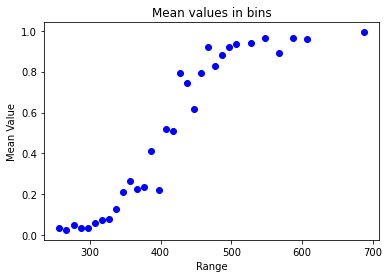

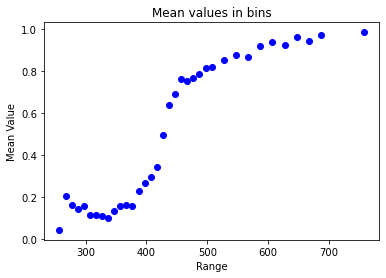

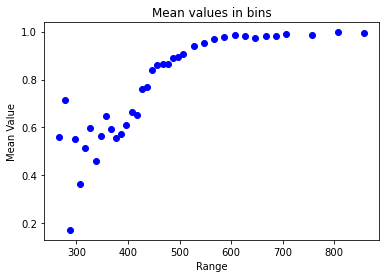

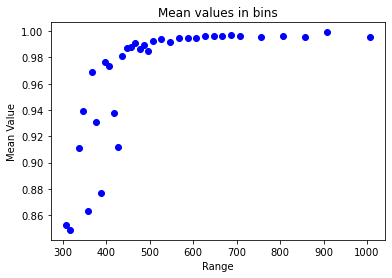

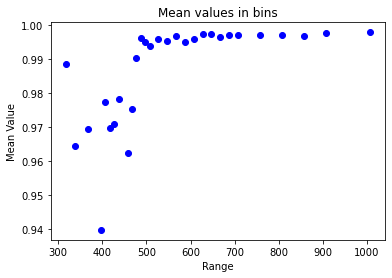

Info in <TCanvas::Print>: png file DATA_TEfficiency_HighestPt_sliced_HT_0_600_gradu.png has been created
Info in <TCanvas::Print>: png file DATA_TEfficiency_HighestPt_sliced_HT_600_900_gradu.png has been created
Info in <TCanvas::Print>: png file DATA_TEfficiency_HighestPt_sliced_HT_900_1200_gradu.png has been created
Info in <TCanvas::Print>: png file DATA_TEfficiency_HighestPt_sliced_HT_1200_1400_gradu.png has been created
Info in <TCanvas::Print>: png file DATA_TEfficiency_HighestPt_sliced_HT_1400_2500_gradu.png has been created


In [103]:
# Pt plots

ranges_min = [0,600,900,1200,1400]
ranges_max = [600,900,1200,1400,2500]

for i in range(0,len(eff_meas_list)):
    efficiency_slices(X[:,1], X[:,0], y_prob_DATA, eff_meas_list[i], None, 'HT', 'HighestPt', ranges_min[i],ranges_max[i], num_bins_pt, 250, 900, "Measured efficiency", None,
                      "ML efficiency", 'p_{T0} [GeV]', str(ranges_min[i])+" GeV < H_{T} < " +str(ranges_max[i]) + " GeV",
                      "DATA_TEfficiency_HighestPt_sliced_HT_"+str(ranges_min[i])+"_"+str(ranges_max[i])+"_"+ run_name +".png" )

In [ ]:
for i in range(0,len(eff_meas_list)):
    efficiency_slices(X[:,1], X[:,0], y_prob_DATA, eff_meas_list[i], None, 'HT', 'HighestPt', ranges_min[i],ranges_max[i], num_bins_pt, 250, 900, "Measured efficiency", None,
                      "ML efficiency", 'p_{T0} [GeV]', str(ranges_min[i])+" GeV < H_{T} < " +str(ranges_max[i]) + " GeV",
                      "DATA_TEfficiency_HighestPt_sliced_HT_"+str(ranges_min[i])+"_"+str(ranges_max[i])+"_"+ run_name +".png" )

[0.05277714 0.06243302 0.11377754 0.04650844 0.0886969  0.0530218
 0.07285768 0.11118248 0.11199857 0.11677962 0.11942057 0.1343187
 0.12126209 0.11867062 0.12127263 0.14044645 0.16839738 0.17619395
 0.20091971 0.19963276 0.20462502 0.31302651 0.30654985 0.31544553
 0.39026352 0.38628715 0.54125153 0.53674886 0.46225228 0.55925068
 0.5890412  0.5915572  0.56297885 0.64399167 0.74485359 0.82192248
 0.79040329 0.84066772 0.91150057 0.66587072 0.91156825 0.9556085
 0.94717134 0.92686602 0.94186356 0.95623832 0.97621885 0.96934637
        nan        nan        nan]


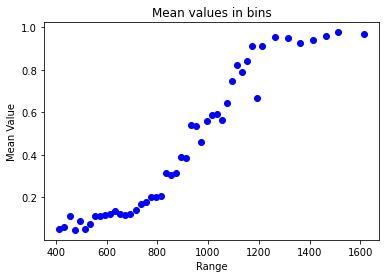

[       nan 0.9701041  0.65484007 0.75760644 0.87610603 0.87622438
 0.81757976 0.75577308 0.68332397 0.7053129  0.57453216 0.56505717
 0.54200007 0.61775317 0.53526406 0.49764979 0.48592598 0.48088323
 0.50576836 0.55856499 0.6223316  0.657474   0.70345273 0.7297462
 0.75873092 0.7689858  0.82553937 0.85082922 0.86742134 0.88059059
 0.91342104 0.9315376  0.93348274 0.94723718 0.95862068 0.96724403
 0.98201611 0.98571525 0.98451927 0.98575842 0.98841579 0.99154166
 0.99169568 0.99284268 0.99405603 0.99156448 0.99365917 0.99245658
 0.99694377 0.99537785        nan]


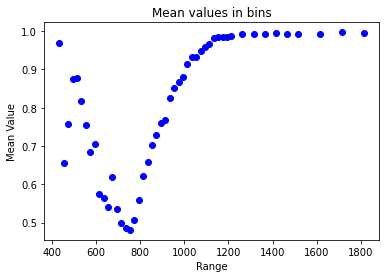

[       nan        nan        nan        nan        nan        nan
        nan 0.95999387        nan 0.99259932        nan 0.98653173
 0.94552517 0.99270967 0.9872405         nan        nan 0.99109403
        nan        nan 0.87753128 0.94097382 0.92301601 0.9341183
 0.95706563 0.92380487 0.92130883 0.9418246  0.94955389 0.95698607
 0.94704559 0.96376311 0.97173888 0.96960008 0.98063881 0.97553612
 0.99361353 0.99458719 0.99525526 0.99546659 0.99576716 0.99594077
 0.99608468 0.9967041  0.99660873 0.99684113 0.99699957 0.9973386
 0.99710542 0.99685946 0.99815866]


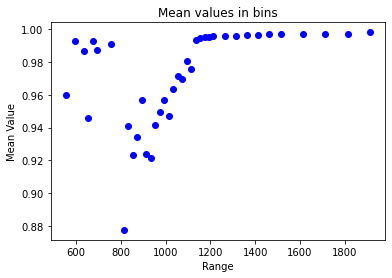

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.99885132 0.99934321
 0.99581274        nan 0.9989055  0.99653788 0.99769569 0.99683325
 0.99751825 0.99774905 0.9979795 ]


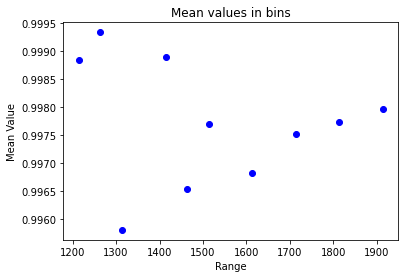

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.99899728
        nan        nan        nan        nan        nan 0.99868654
 0.99847491 0.99716503 0.99875512]


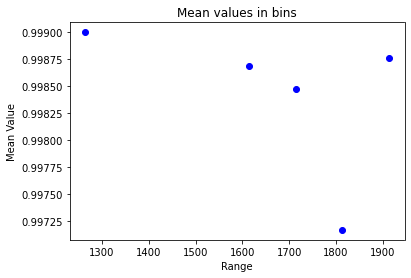

Info in <TCanvas::Print>: png file DATA_TEfficiency_HT_sliced_HighestPt_0_400_gradu.png has been created
Info in <TCanvas::Print>: png file DATA_TEfficiency_HT_sliced_HighestPt_400_600_gradu.png has been created
Info in <TCanvas::Print>: png file DATA_TEfficiency_HT_sliced_HighestPt_600_900_gradu.png has been created
Info in <TCanvas::Print>: png file DATA_TEfficiency_HT_sliced_HighestPt_900_1100_gradu.png has been created
Info in <TCanvas::Print>: png file DATA_TEfficiency_HT_sliced_HighestPt_1100_1800_gradu.png has been created


In [137]:
# HT plots

ranges_min = [0,400,600,900,1100]
ranges_max = [400,600,900,1100,1800]


for i in range(0,len(eff_HT_meas_list)):
    efficiency_slices(X[:,0], X[:,1], y_prob_DATA, eff_HT_meas_list[i], None, 'HighestPt', 'HT',ranges_min[i],ranges_max[i], num_bins_HT, 550, 
                      1950,  "Measured efficiency", None, "ML efficiency","H_{T} [GeV]", str(ranges_min[i])+" GeV < p_{T0} < " +str(ranges_max[i]) + " GeV", 
                      "DATA_TEfficiency_HT_sliced_HighestPt_"+str(ranges_min[i])+"_"+str(ranges_max[i])+"_"+ run_name +".png" )

### DNN 

In [232]:
#model.save("dnn_model_DATA_newest.keras")

dnn_model = tf.keras.models.load_model("dnn_model_DATA_newest.keras")

In [233]:
pddf,features= RD_to_pandas(df_DATA, filter_all_meas,["nFatJet", "HighestPt", "HT", "MET_pt", "mHH","HighestMass","SecondHighestPt", 
                                                           "SecondHighestMass", "Combo", "FatHT", "MET_FatJet", "mHHwithMET", "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"],
                             [ "HighestPt", "HT","MET_pt", "mHH","HighestMass","SecondHighestPt", "SecondHighestMass", "FatHT", "MET_FatJet","mHHwithMET",
                              "HighestEta", "SecondHighestEta", "DeltaEta", "DeltaPhi"])



y_dnn = pddf["Combo"].astype('bool')
y_dnn = y_dnn*1
y_dnn = y_dnn.astype(int).values
X_dnn = features.values # tähän nFatJet, FatJet_pt[0], HT

#X_train_dnn, X_test_dnn, y_train_dnn, y_test_dnn = train_test_split(X_dnn, y_dnn, test_size=0.9)

y_pred_dnn = dnn_model.predict(X_dnn)

573/573 [==============================] - 1s 947us/step


[0.05189475 0.10627986 0.08677753 0.07183547 0.08038424 0.0976124
 0.11581795 0.11945562 0.13880109 0.17202815 0.20017457 0.2380799
 0.23990041 0.30530267 0.34110731 0.39055787 0.4309298  0.50046264
 0.55638261 0.6031325  0.6656623  0.71277215 0.76902536 0.8026434
 0.83443338 0.88365345 0.92092723 0.94390385 0.96201257 0.97372183
 0.98158866 0.98706493 0.99137741 0.99388359 0.99512307 0.99730541
 0.99862485 0.99933131 0.9997397  0.99989061 0.99997015]


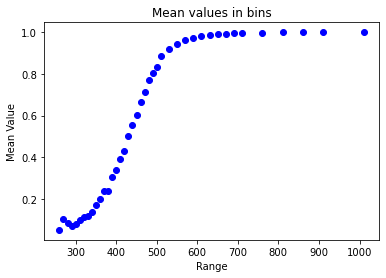

[0.28565223 0.07038947 0.06971802 0.10342438 0.1394889  0.08054703
 0.09413973 0.08598779 0.10485001 0.11938388 0.10990572 0.13223906
 0.14123152 0.17141728 0.18417189 0.20160733 0.23186617 0.26441531
 0.29855222 0.33750832 0.36302931 0.40131932 0.46547115 0.52086427
 0.55428202 0.60112856 0.64928845 0.68738973 0.74505035 0.77848935
 0.80505052 0.83226663 0.86468444 0.87817596 0.89371181 0.91406854
 0.92898356 0.94007861 0.95234908 0.95417144 0.96158116 0.96461627
 0.97436402 0.98273031 0.99011011 0.99457035 0.9933607  0.99729915
 0.99852728 0.99910314 0.9994899  0.9999453  0.99996329]


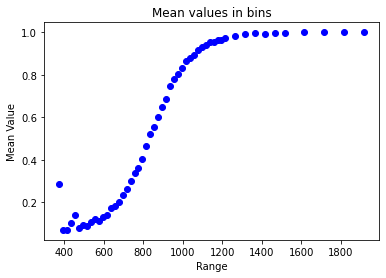

[0.53790165 0.52517511 0.53909066 0.55948348 0.57687952 0.61052895
 0.62954868 0.65513119 0.67971128 0.70574269 0.71598504 0.75081649
 0.7308968  0.74943694 0.78253465 0.80079637 0.82289186 0.8400487
 0.85349456 0.878173   0.90560142 0.91206002 0.91386917 0.94425267
 0.96131485 0.95818642 0.9523052  0.96967936 0.97527132 0.97722046
 0.98462184 0.99167335 0.9943829  0.99664174 0.99570315 0.99944302
 0.99979527]


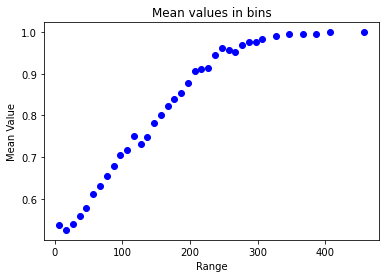

[0.48595102 0.18372747 0.18426915 0.16963617 0.21807979 0.25008801
 0.30830942 0.38158018 0.46320907 0.54082944 0.60216905 0.65881638
 0.70993077 0.75387204 0.76021339 0.81333982 0.79563765 0.81104467
 0.82160601 0.84781637 0.84329565 0.84335617 0.86472582 0.87300743
 0.86503987 0.86022704 0.88322022 0.8928158  0.90770352 0.90059299
 0.9046235  0.91704413 0.92217469 0.95461445]


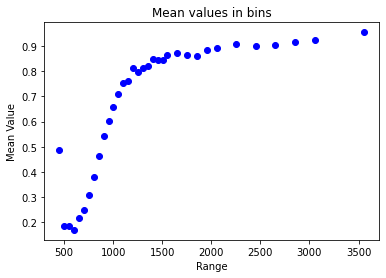

[0.35192002 0.48939112 0.58762636 0.59348376 0.66910291 0.71436926
 0.71165043 0.65170492 0.61045485 0.59595311 0.68977329 0.73060341
 0.78491098 0.80753287 0.84553179 0.86127072 0.90134533 0.92552551
 0.95771963 0.95885223 0.9848598  0.97410844 0.98768739 0.98995423
 0.9987608  0.99982718 0.99987513 0.99987445]


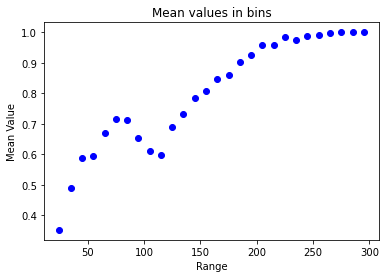

[0.38404988 0.32567874 0.34634001 0.36314017 0.35164856 0.37484284
 0.42544472 0.43430428 0.47562571 0.52083372 0.54441908 0.61307853
 0.64285431 0.67327368 0.68154526 0.73448426 0.74726766 0.79012718
 0.82927574 0.85645205 0.89060989 0.91173685 0.92799291 0.93800518
 0.95343371 0.96743722 0.9768557  0.98627136 0.99099304 0.99447414
 0.99629536 0.99787562 0.99863737 0.99915035 0.9993623  0.99974006
 0.99991682 0.99997271 0.99997206 0.99999872 0.99999852]


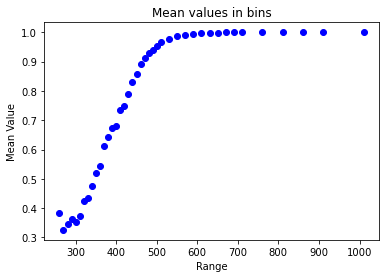

[0.35586564 0.5051746  0.55143057 0.59304968 0.6374488  0.65230514
 0.68295378 0.69857536 0.72823731 0.75265389 0.80276972 0.82978618
 0.86122298 0.93489405 0.95312442 0.96425303 0.97819007 0.9865772
 0.99278301 0.99841842 0.9981354  0.99929733 0.99808837 0.9998885
 0.99944346 0.99998801 0.99954781 0.99999572]


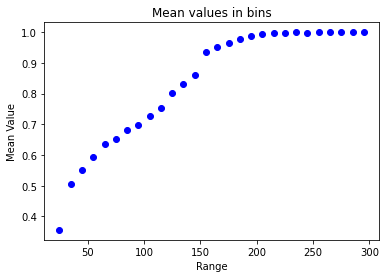

[0.15934286 0.00350201 0.33969482 0.01692953 0.08074005 0.10378813
 0.08300375 0.08771537 0.11934993 0.12494806 0.12641878 0.15446012
 0.18057228 0.19906355 0.20264449 0.24514509 0.27467969 0.32176226
 0.35358983 0.42598342 0.44660994 0.50340573 0.52493559 0.59732495
 0.63793186 0.67354772 0.73487577 0.77585288 0.81249218 0.84090723
 0.8741629  0.89365721 0.90094842 0.92834636 0.93623773 0.94256255
 0.95956989 0.95896735 0.96651383 0.97536912 0.97543291 0.98309125
 0.98371699 0.99075676 0.99342835 0.99712003 0.99522559 0.99817936
 0.99903721 0.99927485 0.99988591 0.99995723 0.99998659]


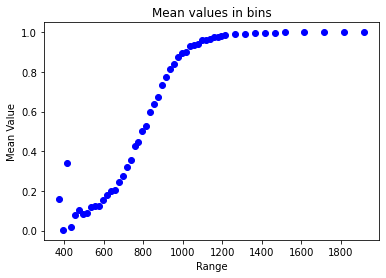

[0.01953768 0.04445846 0.08769379 0.15827062 0.26624406 0.40182033
 0.52489973 0.64538724 0.74637075 0.83430916 0.90597155 0.9418031
 0.9598613  0.97231389 0.98335565 0.98852303 0.99395216 0.99549953
 0.99698221 0.99871223 0.99948954 0.99973085 0.99989997 0.99992702
 0.99994709 0.99997872 0.99998897 0.99999786 0.99999991]


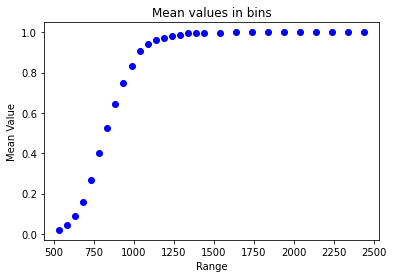

[0.09232912 0.0138474  0.03889153 0.04072189 0.07208065 0.11336688
 0.15447861 0.22518118 0.29441903 0.38301671 0.47702705 0.54168135
 0.60744795 0.66133256 0.72452076 0.74389521 0.7763879  0.78344365
 0.81494214 0.82565885 0.84040308 0.83859428 0.86295538 0.88754453
 0.85712954 0.87958977 0.89006223 0.89827206 0.90363207 0.90960156
 0.91261574 0.91255799 0.92256027 0.95849569]


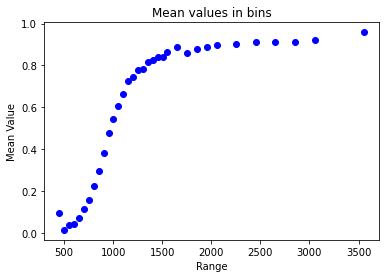

[0.51508864 0.64705769 0.6504946  0.65988846 0.63431818 0.52884319]


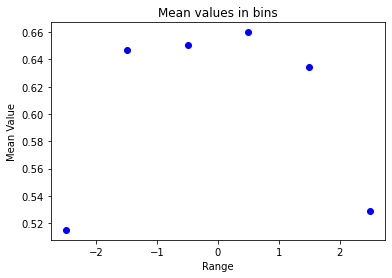

[0.57413944 0.63073829 0.66014107 0.66173458 0.62880921 0.53618881]


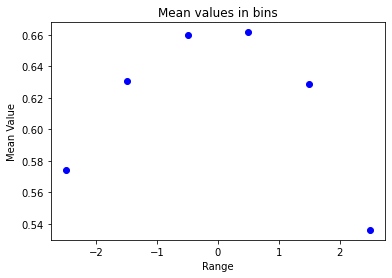

[0.62726163 0.64094344 0.65125009 0.64526026 0.65175774 0.63791702
 0.61845801 0.64262583 0.64386317 0.5531386 ]


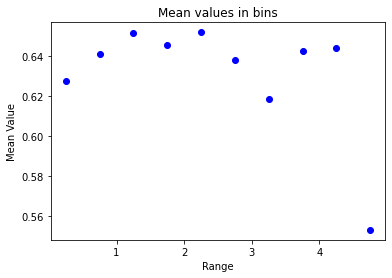

[0.71247398 0.63582685 0.62263154 0.72219884 0.97623297 0.6555636
 0.79753194 0.6468737  0.64518694 0.71619901]


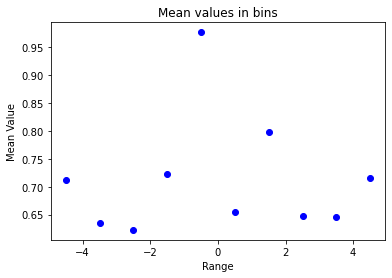

In [234]:
h_dnn_pt_DATA=mean_efficiency(X_dnn[:,0],y_pred_dnn[:,0], num_bins_pt, range_min_pt, range_max_pt)

h_dnn_HT_DATA=mean_efficiency(X_dnn[:,1],y_pred_dnn[:,0], num_bins_HT, range_min_HT, range_max_HT)

h_dnn_MET_DATA=mean_efficiency(X_dnn[:,2],y_pred_dnn[:,0], num_bins_MET, range_min_MET, range_max_MET)

h_dnn_mHH_DATA=mean_efficiency(X_dnn[:,3],y_pred_dnn[:,0], num_bins_mHH, range_min_mHH, range_max_mHH)

h_dnn_mass_DATA=mean_efficiency(X_dnn[:,4],y_pred_dnn[:,0], num_bins_mass, range_min_mass, range_max_mass)

h_dnn_pt1_DATA=mean_efficiency(X_dnn[:,5],y_pred_dnn[:,0], num_bins_pt, range_min_pt, range_max_pt)

h_dnn_mass1_DATA=mean_efficiency(X_dnn[:,6],y_pred_dnn[:,0], num_bins_mass, range_min_mass, range_max_mass)

h_dnn_FJHT_DATA=mean_efficiency(X_dnn[:,7],y_pred_dnn[:,0], num_bins_HT, range_min_HT, range_max_HT)

h_dnn_METfj_DATA=mean_efficiency(X_dnn[:,8],y_pred_dnn[:,0], num_bins_METfj, range_min_METfj, range_max_METfj)

h_dnn_mHHwMET_DATA=mean_efficiency(X_dnn[:,9],y_pred_dnn[:,0], num_bins_mHH, range_min_mHH, range_max_mHH)

h_dnn_eta_DATA=mean_efficiency(X_dnn[:,10],y_pred_dnn[:,0], num_bins_eta, range_min_eta, range_max_eta)

h_dnn_eta1_DATA=mean_efficiency(X_dnn[:,11],y_pred_dnn[:,0], num_bins_eta, range_min_eta, range_max_eta)

h_dnn_deltaeta_DATA=mean_efficiency(X_dnn[:,12],y_pred_dnn[:,0], num_bins_delta, range_min_delta, range_max_delta)

h_dnn_deltaphi_DATA=mean_efficiency(X_dnn[:,13],y_pred_dnn[:,0], num_bins_phi, range_min_phi, range_max_phi)


DNN_DATA = [h_dnn_pt_DATA, h_dnn_HT_DATA, h_dnn_MET_DATA, h_dnn_mHH_DATA, h_dnn_mass_DATA, h_dnn_pt1_DATA, h_dnn_mass1_DATA,h_dnn_FJHT_DATA, 
             h_dnn_METfj_DATA, h_dnn_mHHwMET_DATA, h_dnn_eta_DATA, h_dnn_eta1_DATA, h_dnn_deltaeta_DATA, h_dnn_deltaphi_DATA]



### STD plots

In [236]:
for j in range(0,len(num_bins_list)):    
    efficiency_plot_stds(eff_list_DATA[j],None, mean_list_DATA[j], mean_plus_list_DATA[j], mean_minus_list_DATA[j], DNN_DATA[j], "Measured efficiency"," ", 
                         "GB mean efficiency","DNN efficiency","",y_min_list[j], y_max_list[j], range_min_list[j],range_max_list[j], names_list_plot[j],"STD_DATA_TEfficiency_"+names_list[j]+"_GB1_"+ run_name+".png", "DATA")
    

Info in <TCanvas::Print>: png file STD_DATA_TEfficiency_HighestPt_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_DATA_TEfficiency_HT_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_DATA_TEfficiency_MET_pt_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_DATA_TEfficiency_mHH_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_DATA_TEfficiency_HighestMass_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_DATA_TEfficiency_SecondHighestPt_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_DATA_TEfficiency_SecondHighestMass_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_DATA_TEfficiency_FatHT_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_DATA_TEfficiency_MET_FatJet_GB1_DNN_gradu.png has been created
Info in <TCanvas::Print>: png file STD_DATA_TEfficiency_mHHwithMET_GB1_DNN_gradu.png has been 

### ONNX

In [84]:
"""

# ONNX 
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

X = DATA_features.values 

onx = to_onnx(gb_model_DATA1, X.astype(np.float32))

# Save the ONNX model to a file
with open("GB_model_HH_test.onnx", "wb") as f:
    f.write(onx.SerializeToString())

import onnxruntime as rt


predictions_list =[]

for i in range(n_samples):
    sess = rt.InferenceSession("GB_model_HH_all_"+str(i+1)+".onnx", providers=["CPUExecutionProvider"])
    input_name = sess.get_inputs()[0].name
    label_name = sess.get_outputs()[0].name

    # Predictions
    pred_onx = sess.run(None, {input_name: X.astype(np.float32)})

    # Probabilities for the events to pass the trigger
    second_terms = [element[1] for element in pred_onx[1]]
    predictions_list.append(second_terms)
    
    

mean_values_DATA = np.mean(predictions_list, axis = 0)

std_deviations_DATA = np.std(predictions_list, axis = 0)

upper_bounds = mean_values + std_values
lower_bounds = mean_values - std_values

# Calculate the standard deviation between the different predictions for the same event 
std_deviation_DATA = np.std(individual_predictions_DATA)
    
# Calculate the mean 
mean_DATA = np.mean(individual_predictions_DATA)
    
std_deviations_DATA.append(std_deviation_DATA)
    
mean_values_DATA.append(mean_DATA)

"""